## REDD: supervised learning on the energy disaggregation problem

##### Here we test some machine learning algorithm on extracting the refrigerator energy from mains consumptions. REDD contains data of 6 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

---



In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17969773376466681450
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2734532575848521005
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3124440301703115323
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329991476
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2624604225197267445
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

In [6]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i], '\n')


House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

# Data Pre processing 

In [7]:
import pandas as pd
def read_merge_data(house):
    
    path = 'low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [8]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))
    

House 1 data has shape:  (406748, 20)


mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-05-24 19:56:27   235.46    38.61     0.0     0.0           190.0   
2011-05-24 19:56:30   235.98    38.77     0.0     0.0           189.0   
2011-05-24 19:56:34   235.29    38.83     0.0     0.0           186.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-05-24 19:56:27          0.0               24.0               20.0   
2011-05-24 19:56:30          0.0               24.0               20.0   
2011-05-24 19:56:34          0.0               26.0               20.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-05-24 19:56:27         2.0              0.0           4.0   
2011-05-24 19:56:30         2.0              0.0           4.0   
2011-05-24 19:56:34         2.0              0.0           4.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-05-24 19:56:27              1.0               0.0       0.0   
2011-05-24 19:56:30              1.0               0.0       0.0   
2011-05-24 19:56:34              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-05-24 19:56:27                 1.0                 0.0          0.0   
2011-05-24 19:56:30                 1.0                 0.0          0.0   
2011-05-24 19:56:34                 1.0                 0.0          0.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-05-24 19:56:27          1.0              0.0              0.0  
2011-05-24 19:56:30          1.0              0.0              0.0  
2011-05-24 19:56:34          1.0              0.0              0.0

House 2 data has shape:  (316840, 11)


mains_1  mains_2  kitchen_outlets_3  lighting_4  stove_5  \
2011-05-22 23:59:01    10.84   252.61                0.0         9.0      0.0   
2011-05-22 23:59:04    10.88   253.02                0.0         9.0      0.0   
2011-05-22 23:59:08    10.84   252.77                0.0         9.0      0.0   

                     microwave_6  washer_dryer_7  kitchen_outlets_8  \
2011-05-22 23:59:01          5.0             0.0                2.0   
2011-05-22 23:59:04          4.0             0.0                2.0   
2011-05-22 23:59:08          4.0             0.0                2.0   

                     refrigerator_9  dishwaser_10  disposal_11  
2011-05-22 23:59:01           158.0           0.0          0.0  
2011-05-22 23:59:04           160.0           0.0          0.0  
2011-05-22 23:59:08           157.0           0.0          0.0

In [9]:
df[1].head()

mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-04-18 13:22:13   222.20   118.83     0.0     0.0             6.0   
2011-04-18 13:22:16   223.17   119.19     0.0     0.0             6.0   
2011-04-18 13:22:20   223.60   118.92     0.0     0.0             6.0   
2011-04-18 13:22:23   222.91   119.16     0.0     0.0             6.0   
2011-04-18 13:22:26   222.94   118.83     0.0     0.0             6.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-04-18 13:22:13          0.0               34.0               21.0   
2011-04-18 13:22:16          0.0               34.0               21.0   
2011-04-18 13:22:20          0.0               34.0               22.0   
2011-04-18 13:22:23          1.0               35.0               21.0   
2011-04-18 13:22:26          0.0               34.0               21.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-04-18 13:22:13        81.0              0.0           5.0   
2011-04-18 13:22:16        81.0              0.0           5.0   
2011-04-18 13:22:20        81.0              0.0           5.0   
2011-04-18 13:22:23        81.0              0.0           5.0   
2011-04-18 13:22:26        81.0              0.0           5.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-04-18 13:22:13              1.0               0.0       0.0   
2011-04-18 13:22:16              1.0               0.0       0.0   
2011-04-18 13:22:20              1.0               0.0       0.0   
2011-04-18 13:22:23              1.0               0.0       0.0   
2011-04-18 13:22:26              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-04-18 13:22:13                 2.0                 0.0         65.0   
2011-04-18 13:22:16                 2.0                 0.0         65.0   
2011-04-18 13:22:20                 2.0                 0.0         65.0   
2011-04-18 13:22:23                 1.0                 0.0         65.0   
2011-04-18 13:22:26                 2.0                 0.0         65.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-04-18 13:22:13         46.0              0.0              0.0  
2011-04-18 13:22:16         46.0              0.0              0.0  
2011-04-18 13:22:20         46.0              0.0              0.0  
2011-04-18 13:22:23         46.0              0.0              0.0  
2011-04-18 13:22:26         46.0              0.0              0.0

In [10]:
df[2].head()

mains_1  mains_2  kitchen_outlets_3  lighting_4  stove_5  \
2011-04-18 05:31:40    15.71    22.61                1.0         8.0      1.0   
2011-04-18 05:31:44    15.71    22.61                0.0         8.0      1.0   
2011-04-18 05:31:47    15.72    22.61                1.0         8.0      1.0   
2011-04-18 05:31:50    15.70    22.57                0.0         8.0      1.0   
2011-04-18 05:32:05    15.64    22.61                1.0         8.0      1.0   

                     microwave_6  washer_dryer_7  kitchen_outlets_8  \
2011-04-18 05:31:40          4.0             4.0                4.0   
2011-04-18 05:31:44          5.0             5.0                4.0   
2011-04-18 05:31:47          4.0             4.0                4.0   
2011-04-18 05:31:50          4.0             4.0                3.0   
2011-04-18 05:32:05          4.0             4.0                3.0   

                     refrigerator_9  dishwaser_10  disposal_11  
2011-04-18 05:31:40             6.0           1.0          0.0  
2011-04-18 05:31:44             6.0           0.0          0.0  
2011-04-18 05:31:47             6.0           1.0          0.0  
2011-04-18 05:31:50             7.0           0.0          0.0  
2011-04-18 05:32:05             7.0           1.0          0.0

In [11]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



# Plot total energy sonsumption of each appliance from two houses


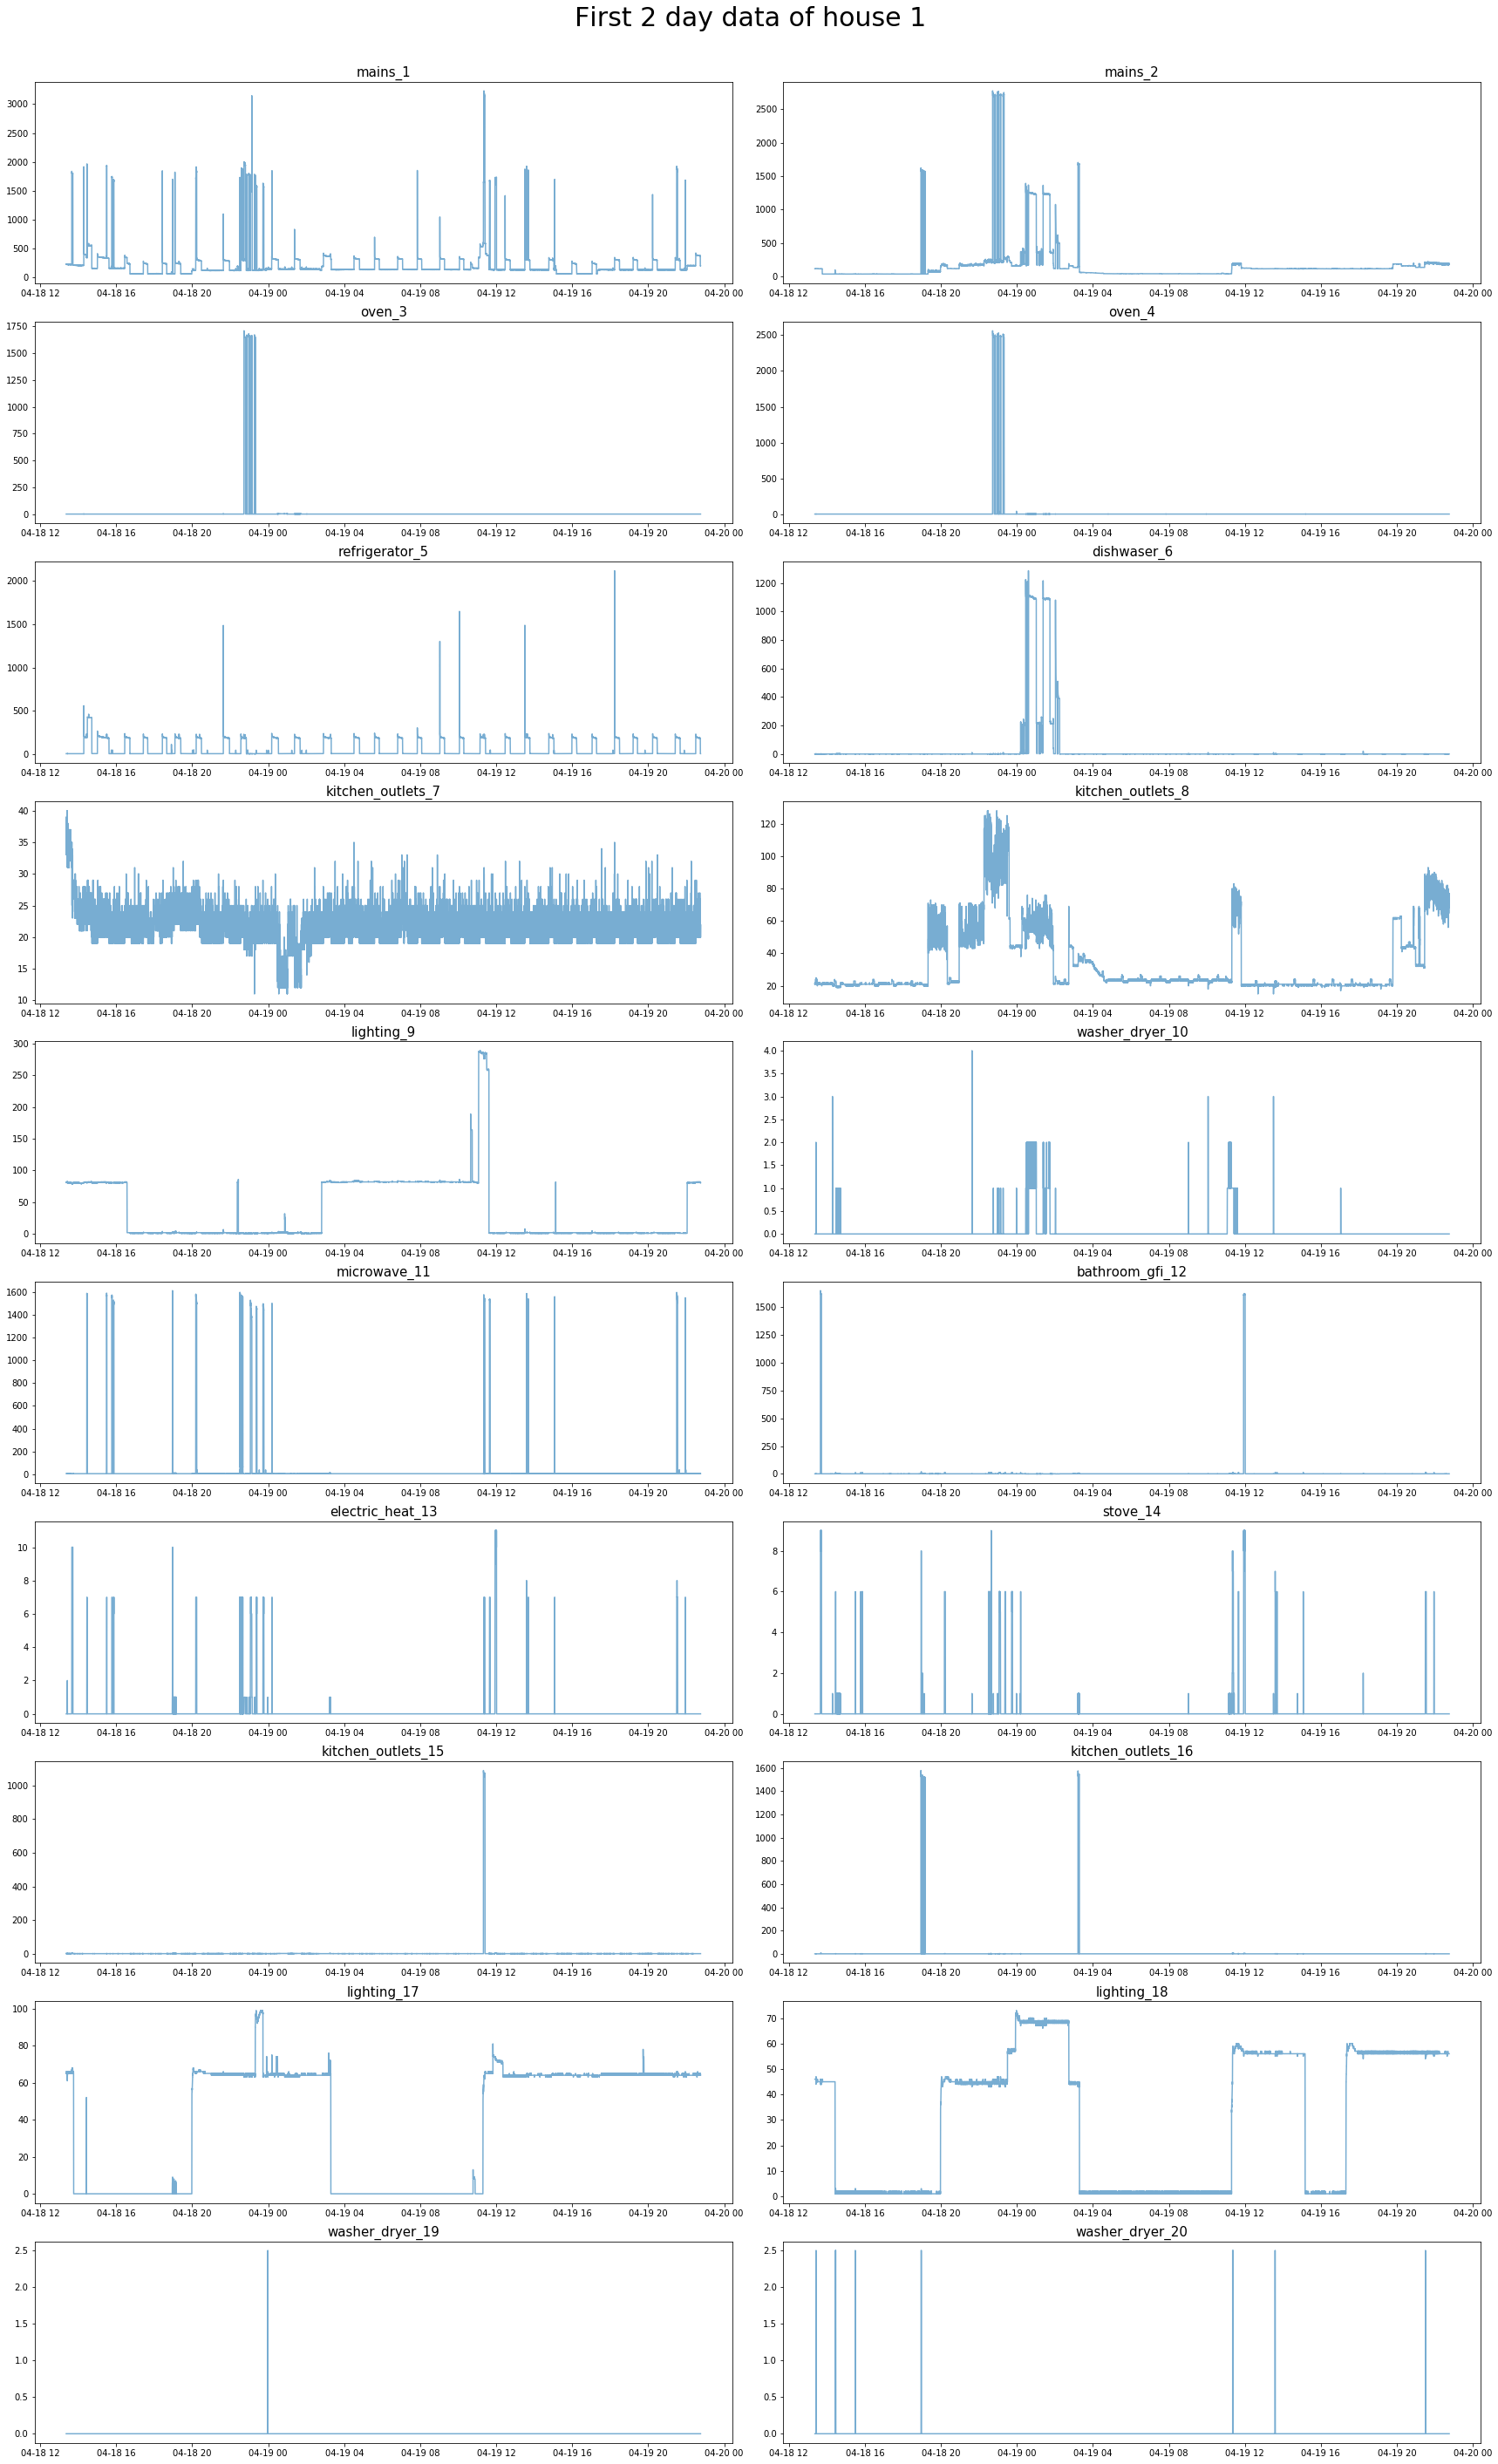

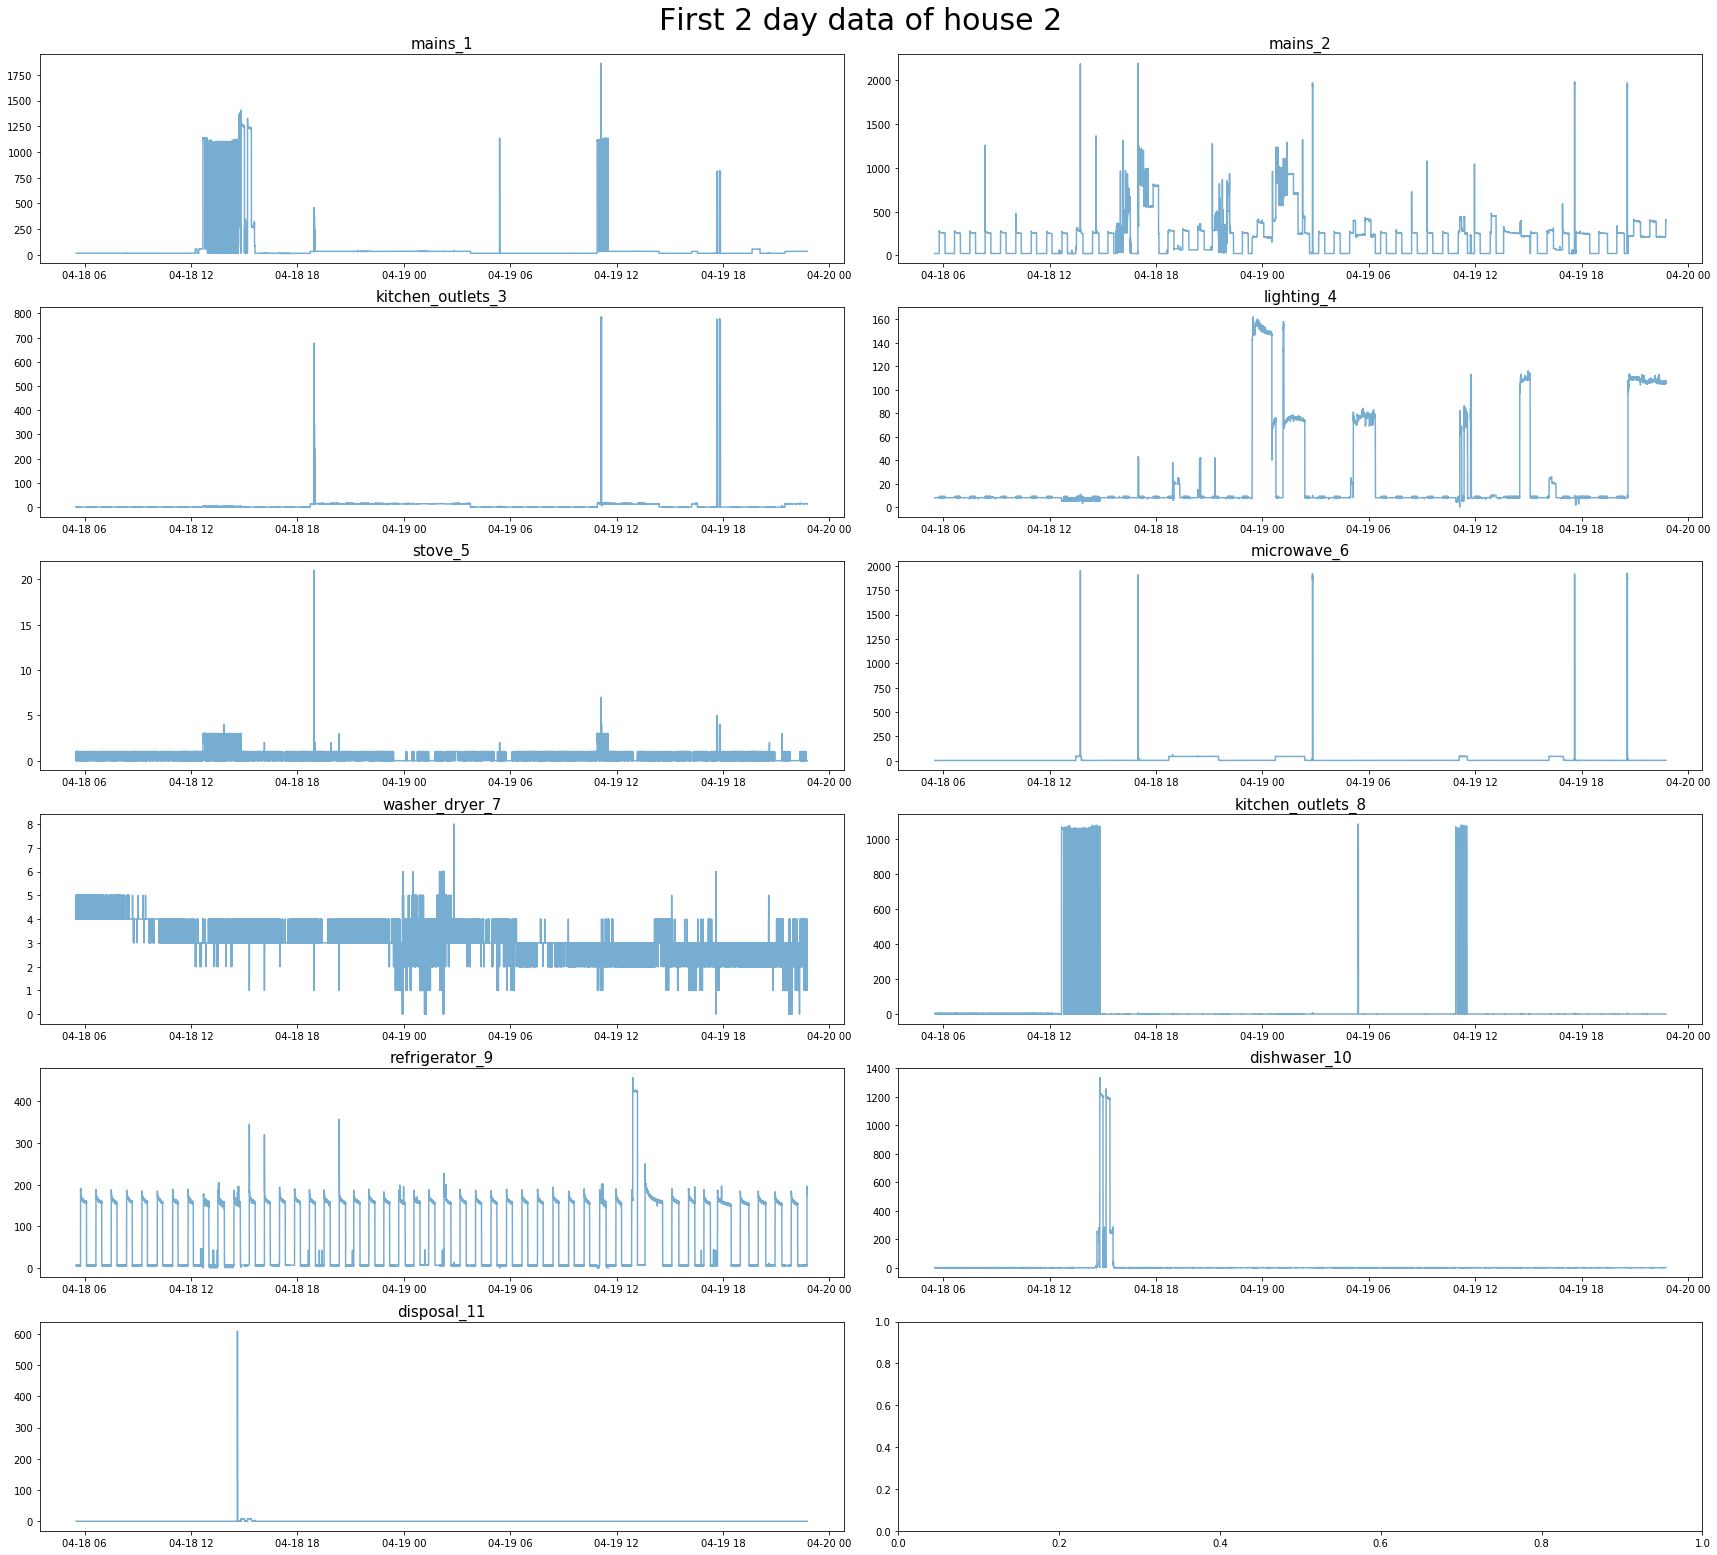

In [12]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,3):
    plot_df(df[i].ix[:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5, 1.0, 'House 2')

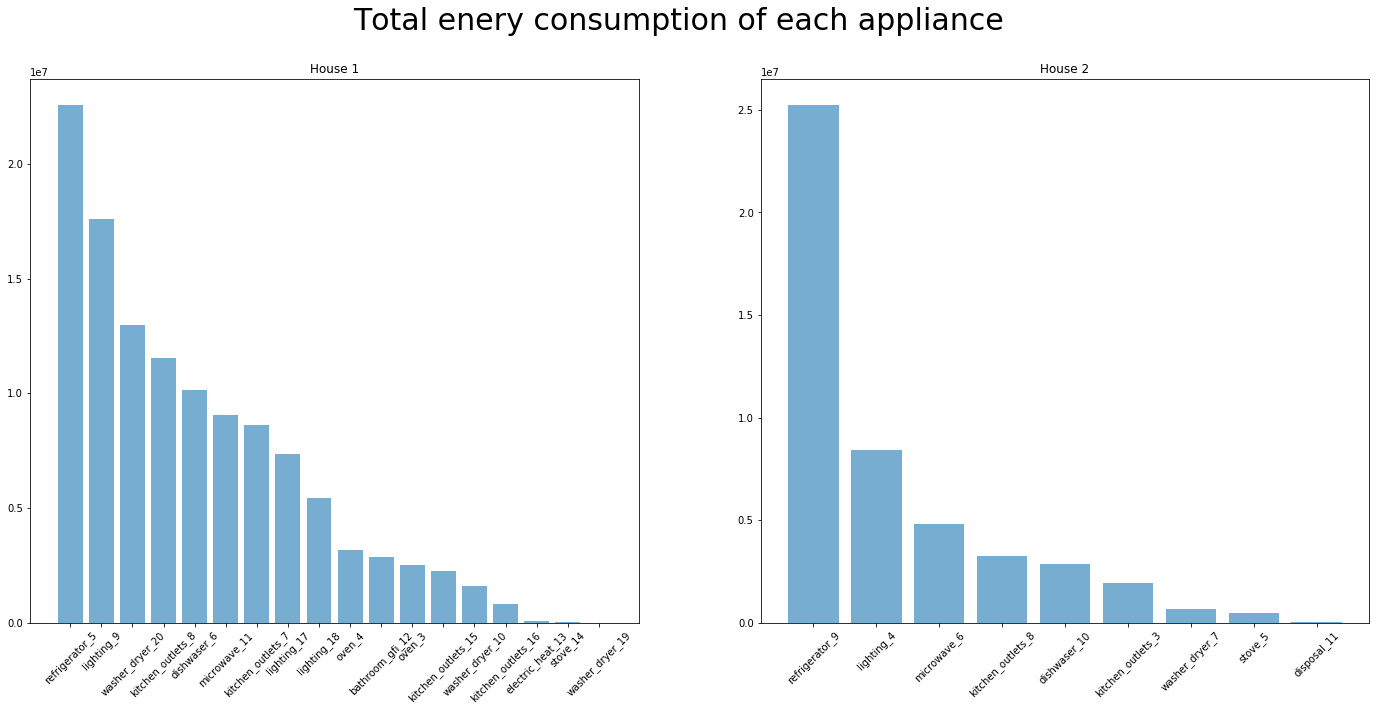

In [13]:
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')



### Train and test on house 1 - Decision tree regression

In [12]:
# Separate house 1 data into train, validation and test data
df1_train = df[1].ix[:dates[1][10]]
df1_val = df[1].ix[dates[1][11]:dates[1][16]]
df1_test = df[1].ix[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (214816, 20)
df_val.shape:  (104875, 20)
df_test.shape:  (87057, 20)


In [13]:
df1_test.head()

mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-05-11 07:19:47    97.52    38.38     0.0     0.0             6.0   
2011-05-11 07:20:08    95.61    38.29     0.0     0.0             7.0   
2011-05-11 07:20:17    94.86    38.56     0.0     0.0             7.0   
2011-05-11 07:20:20    95.21    38.29     0.0     0.0             6.0   
2011-05-11 07:20:24    95.82    38.35     0.0     0.0             7.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-05-11 07:19:47          0.0               23.0               20.0   
2011-05-11 07:20:08          0.0               21.0               20.0   
2011-05-11 07:20:17          0.0               22.0               20.0   
2011-05-11 07:20:20          0.0               24.0               21.0   
2011-05-11 07:20:24          0.0               22.0               20.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-05-11 07:19:47        42.0              0.0           4.0   
2011-05-11 07:20:08        42.0              0.0           4.0   
2011-05-11 07:20:17        42.0              0.0           4.0   
2011-05-11 07:20:20        42.0              0.0           4.0   
2011-05-11 07:20:24        42.0              0.0           4.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-05-11 07:19:47              1.0               0.0       0.0   
2011-05-11 07:20:08              1.0               0.0       0.0   
2011-05-11 07:20:17              1.0               0.0       0.0   
2011-05-11 07:20:20              1.0               0.0       0.0   
2011-05-11 07:20:24              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-05-11 07:19:47                 1.0                 0.0          0.0   
2011-05-11 07:20:08                 1.0                 0.0          0.0   
2011-05-11 07:20:17                 1.0                 0.0          0.0   
2011-05-11 07:20:20                 1.0                 0.0          0.0   
2011-05-11 07:20:24                 1.0                 0.0          0.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-05-11 07:19:47          1.0              0.0              0.0  
2011-05-11 07:20:08          1.0              0.0              0.0  
2011-05-11 07:20:17          1.0              0.0              0.0  
2011-05-11 07:20:20          1.0              0.0              0.0  
2011-05-11 07:20:24          1.0              0.0              0.0

In [14]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


In [16]:
X_train1

array([[222.2 , 118.83],
       [223.17, 119.19],
       [223.6 , 118.92],
       ...,
       [354.5 ,  41.28],
       [347.06,  41.11],
       [347.43,  41.38]])

In [17]:
y_train1

array([  6.,   6.,   6., ..., 226., 221., 221.])

In [19]:
y_test1

array([  6.,   7.,   7., ..., 190., 189., 186.])

In [20]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)

from sklearn.tree import DecisionTreeRegressor

def tree_reg(X_train, y_train, X_val, y_val, min_samples_split):
    clfs = []
    losses = []
    start = time.time()
    for split in min_samples_split:
        clf = DecisionTreeRegressor(min_samples_split = split)
        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)
        clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
    print('Trainning time: ', time.time() - start)
    return clfs, losses
tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1, min_samples_split)

Trainning time:  29.555415391921997


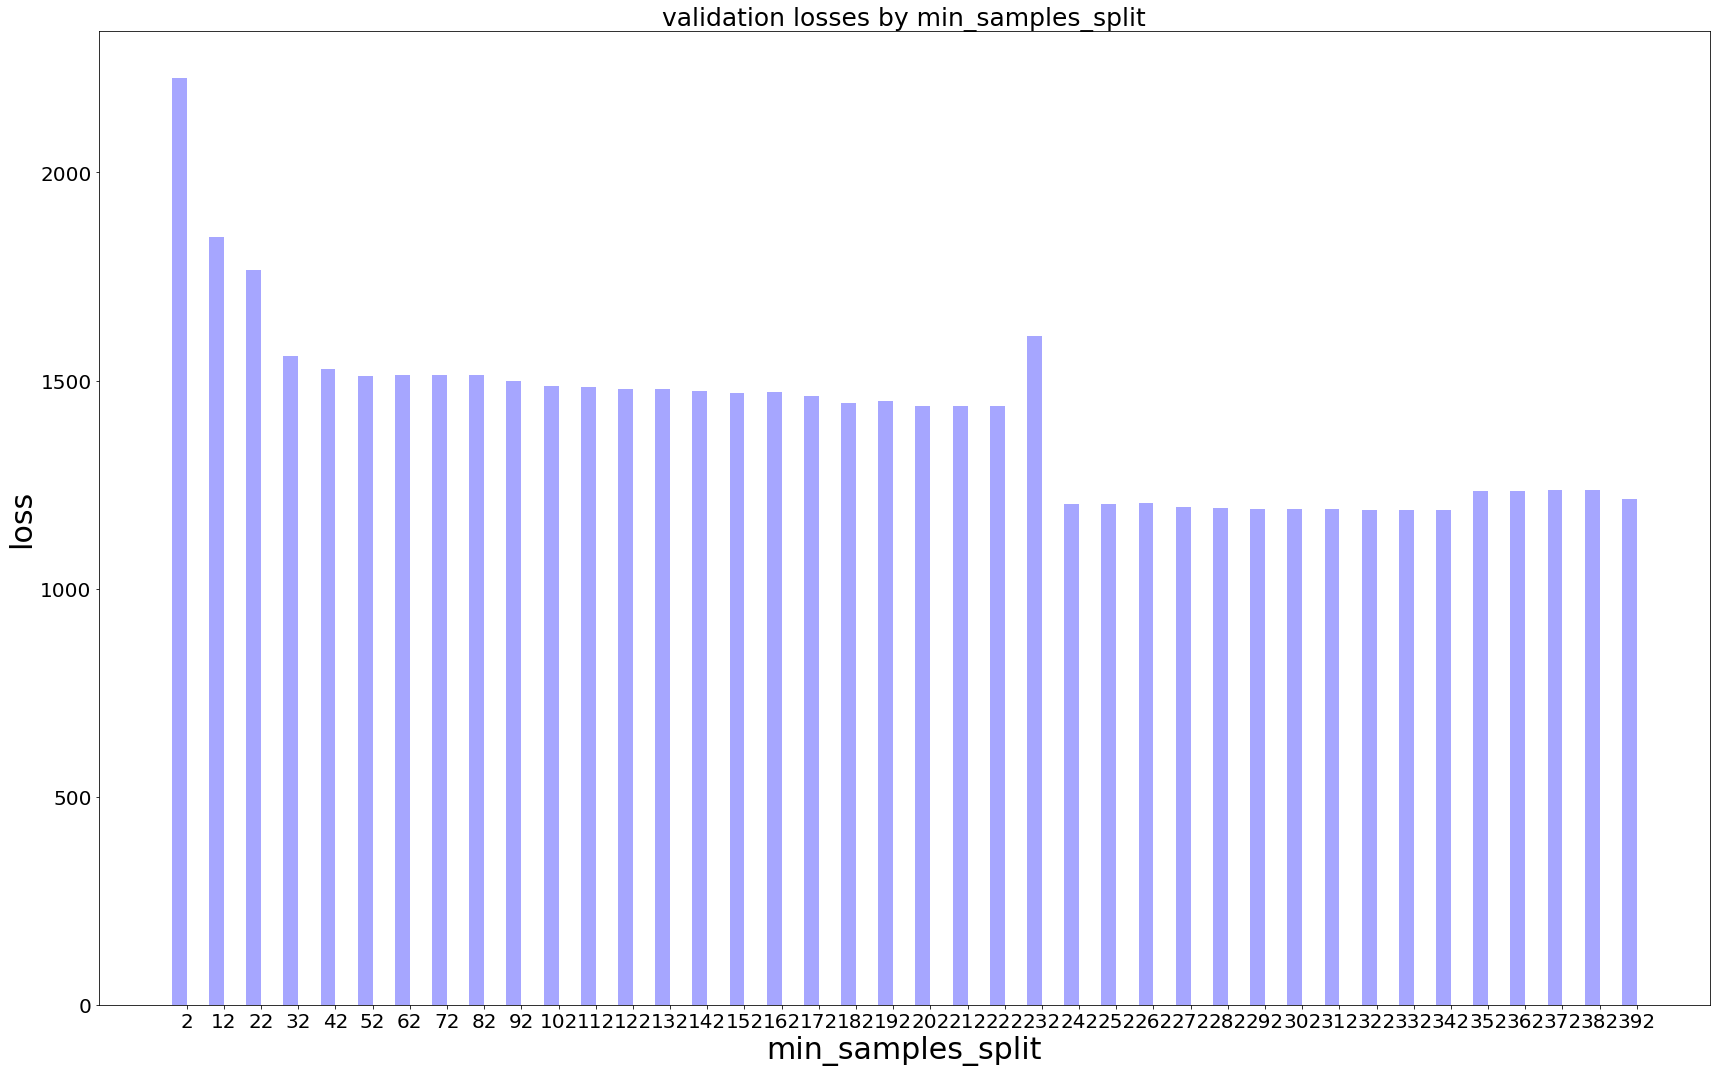

In [22]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.4
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()

plot_losses(tree_losses_1, min_samples_split)

In [23]:
# Choose the best model and predict refrigerator consumption on the test set
ind = np.argmin(tree_losses_1)
tree_clf_1 = tree_clfs_1[ind]
y_test_predict_1 = tree_clf_1.predict(X_test1)
mse_tree_1 = mse_loss(y_test_predict_1, y_test1)
mae_tree_1 = mae_loss(y_test_predict_1, y_test1)
print('Mean square error on test set: ', mse_tree_1)
print('Mean absolute error on the test set: ', mae_tree_1)

Mean square error on test set:  1634.5797666188705
Mean absolute error on the test set:  12.686127417077758


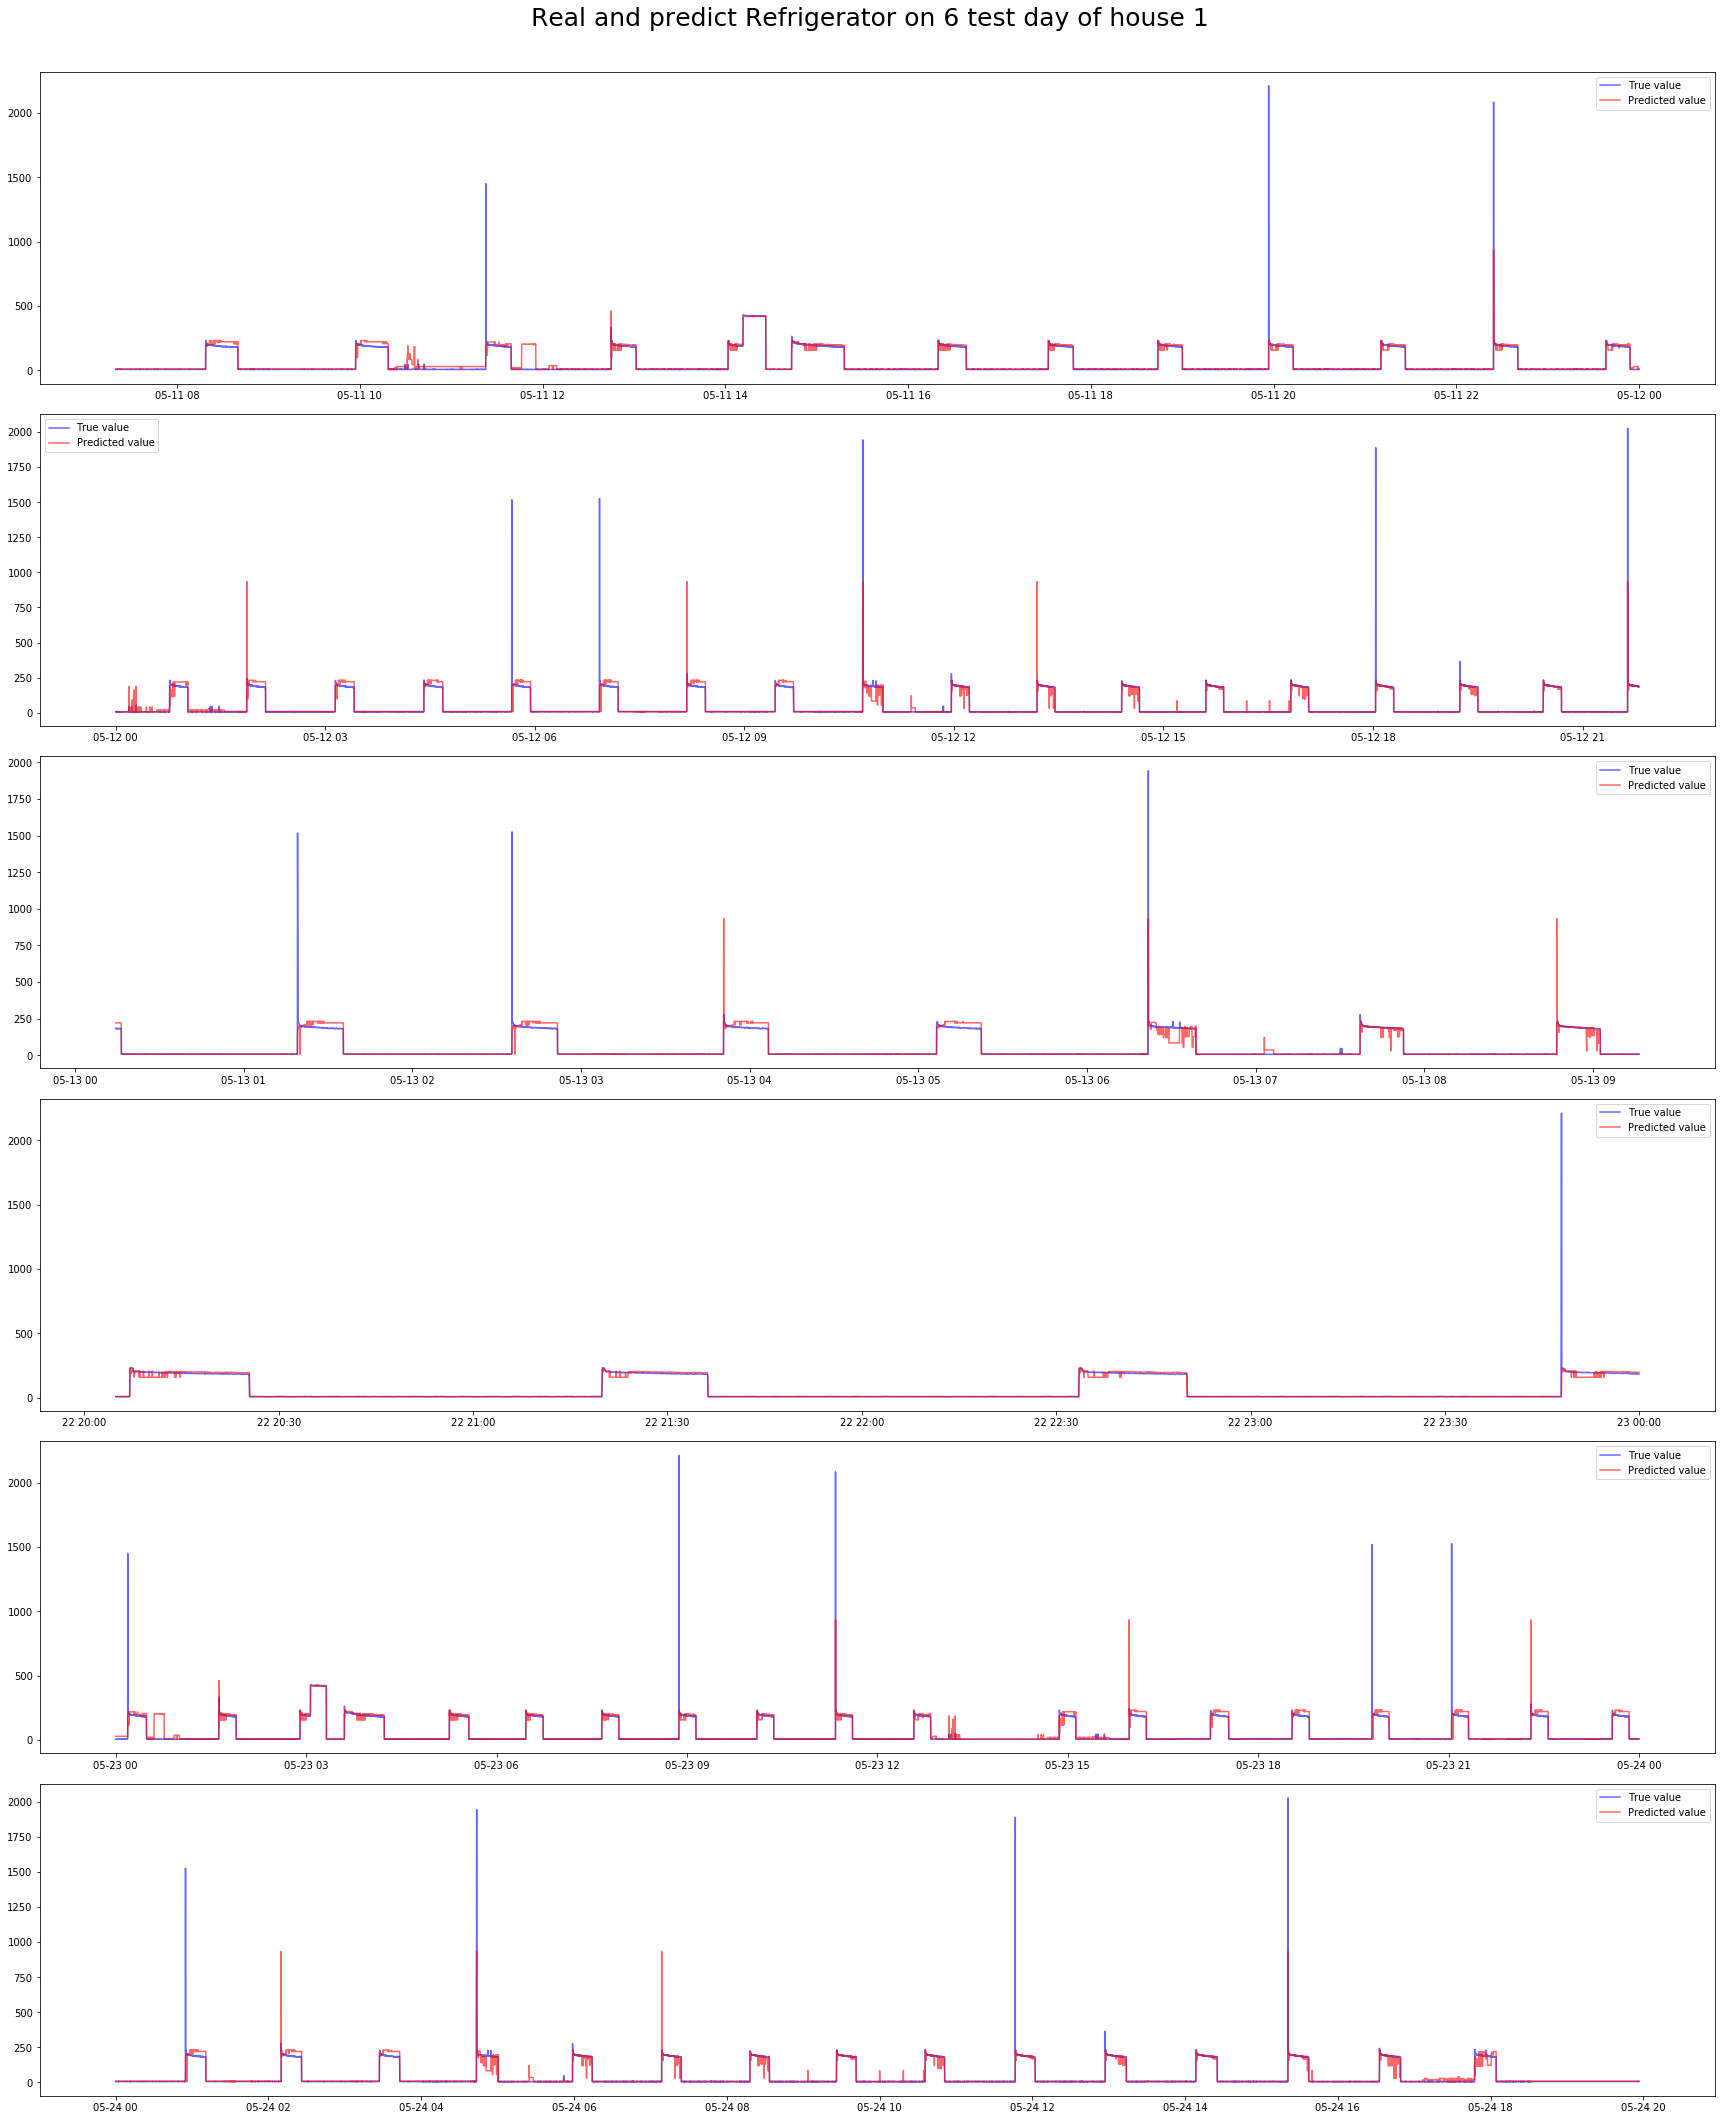

In [20]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

#### Using decision tree model we have just trained on house 1 to predict refrigerator consumtion on house 2

In [25]:
X_2 = df[2][['mains_2','mains_1']].values
y_2 = df[2]['refrigerator_9'].values
print(X_2.shape, y_2.shape)

(316840, 2) (316840,)


In [29]:
X_2

array([[ 22.61,  15.71],
       [ 22.61,  15.71],
       [ 22.61,  15.72],
       ...,
       [252.61,  10.84],
       [253.02,  10.88],
       [252.77,  10.84]])

In [27]:
y_2

array([  6.,   6.,   6., ..., 158., 160., 157.])

In [30]:
y_predict_2 = tree_clf_1.predict(X_2)
mse_tree_2 = mse_loss(y_predict_2, y_2)
mae_tree_2 = mae_loss(y_predict_2, y_2)
print('Mean square error on test set: ', mse_tree_2)
print('Mean absolute error on the test set: ', mae_tree_2)

Mean square error on test set:  32245.25362228206
Mean absolute error on the test set:  64.75419454670589


In [33]:
import pickle

# save
with open('decision_tree_model.pkl','wb') as f:
    pickle.dump(tree_clf_1,f)

In [34]:
tree_clf_1

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=332, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

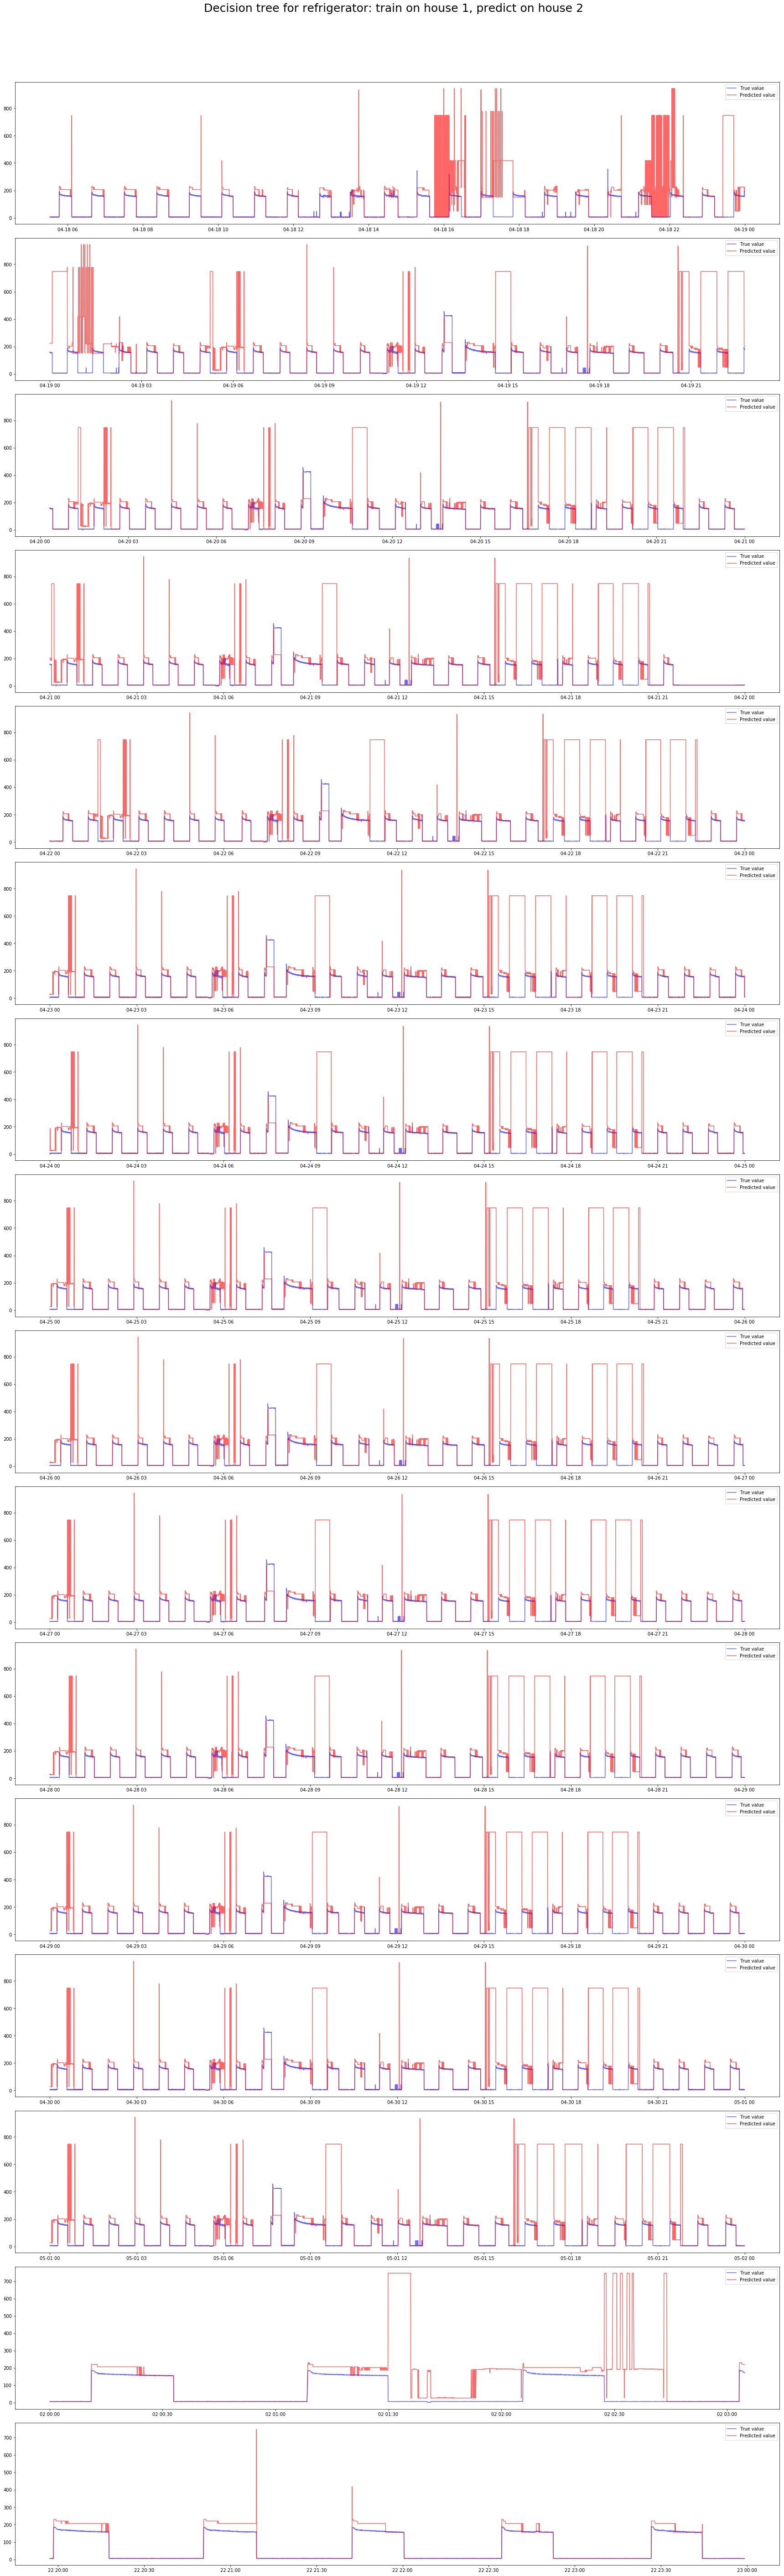

In [23]:
plot_each_app(df[2], dates[2], y_predict_2, y_2, 'Decision tree for refrigerator: train on house 1, predict on house 2')

#### Now, we will try decision tree method for other appliances in house 1

In [24]:
# List of other appliances in house 1:
appliances = list(df[1].columns.values[2:])
appliances.pop(2)
print(appliances)

['oven_3', 'oven_4', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']


In [25]:
# using decision tree model on other appliances
def tree_reg_mult_apps():
    start = time.time()
    min_samples_split=np.arange(2, 400, 10)
    pred = {}
    for app in appliances:
        list_clfs = []
        losses = []
        y_train = df1_train[app].values
        y_val = df1_val[app].values
        for split in min_samples_split:
            clf = DecisionTreeRegressor(min_samples_split = split)
            clf.fit(X_train1, y_train)
            y_predict_val = clf.predict(X_val1)
            list_clfs.append(clf)
            losses.append( mse_loss(y_predict_val, y_val) )
        ind = np.argmin(losses)
        pred[app] = list_clfs[ind].predict(X_test1)
    print('Trainning time: ', time.time() - start)
    return pred

mul_pred = tree_reg_mult_apps()

Trainning time:  354.68393659591675


In [26]:
def error_mul_app(mul_pred):
    mse_losses = {}
    mae_losses = {}
    for app in appliances:
        mse_losses[app] = mse_loss(mul_pred[app], df1_test[app].values)
        mae_losses[app] = mae_loss(mul_pred[app], df1_test[app].values)
    return mse_losses, mae_losses

mul_mse_tree, mul_mae_tree = error_mul_app(mul_pred) 

In [27]:
for app in appliances:
    m = np.mean(df1_test[app].values)
    print('mean of {0}: {1:.2f} - mse: {2:.2f} - mae: {3:.2f}'.format(app, m ,mul_mse_tree[app], mul_mae_tree[app]))

mean of oven_3: 15.63 - mse: 18554.82 - mae: 11.28
mean of oven_4: 17.11 - mse: 7454.75 - mae: 4.92
mean of dishwaser_6: 25.35 - mse: 831.49 - mae: 3.38
mean of kitchen_outlets_7: 21.25 - mse: 4.50 - mae: 1.59
mean of kitchen_outlets_8: 27.71 - mse: 99.51 - mae: 3.43
mean of lighting_9: 28.29 - mse: 1591.51 - mae: 23.95
mean of washer_dryer_10: 3.07 - mse: 934.44 - mae: 2.44
mean of microwave_11: 18.92 - mse: 12442.92 - mae: 13.00
mean of bathroom_gfi_12: 6.73 - mse: 3471.07 - mae: 3.44
mean of electric_heat_13: 0.11 - mse: 0.53 - mae: 0.05
mean of stove_14: 0.10 - mse: 0.23 - mae: 0.04
mean of kitchen_outlets_15: 5.34 - mse: 832.75 - mae: 1.63
mean of kitchen_outlets_16: 1.93 - mse: 861.56 - mae: 0.67
mean of lighting_17: 18.97 - mse: 136.66 - mae: 3.18
mean of lighting_18: 15.68 - mse: 383.82 - mae: 13.12
mean of washer_dryer_19: 0.00 - mse: 0.00 - mae: 0.00
mean of washer_dryer_20: 27.54 - mse: 2087.58 - mae: 1.79


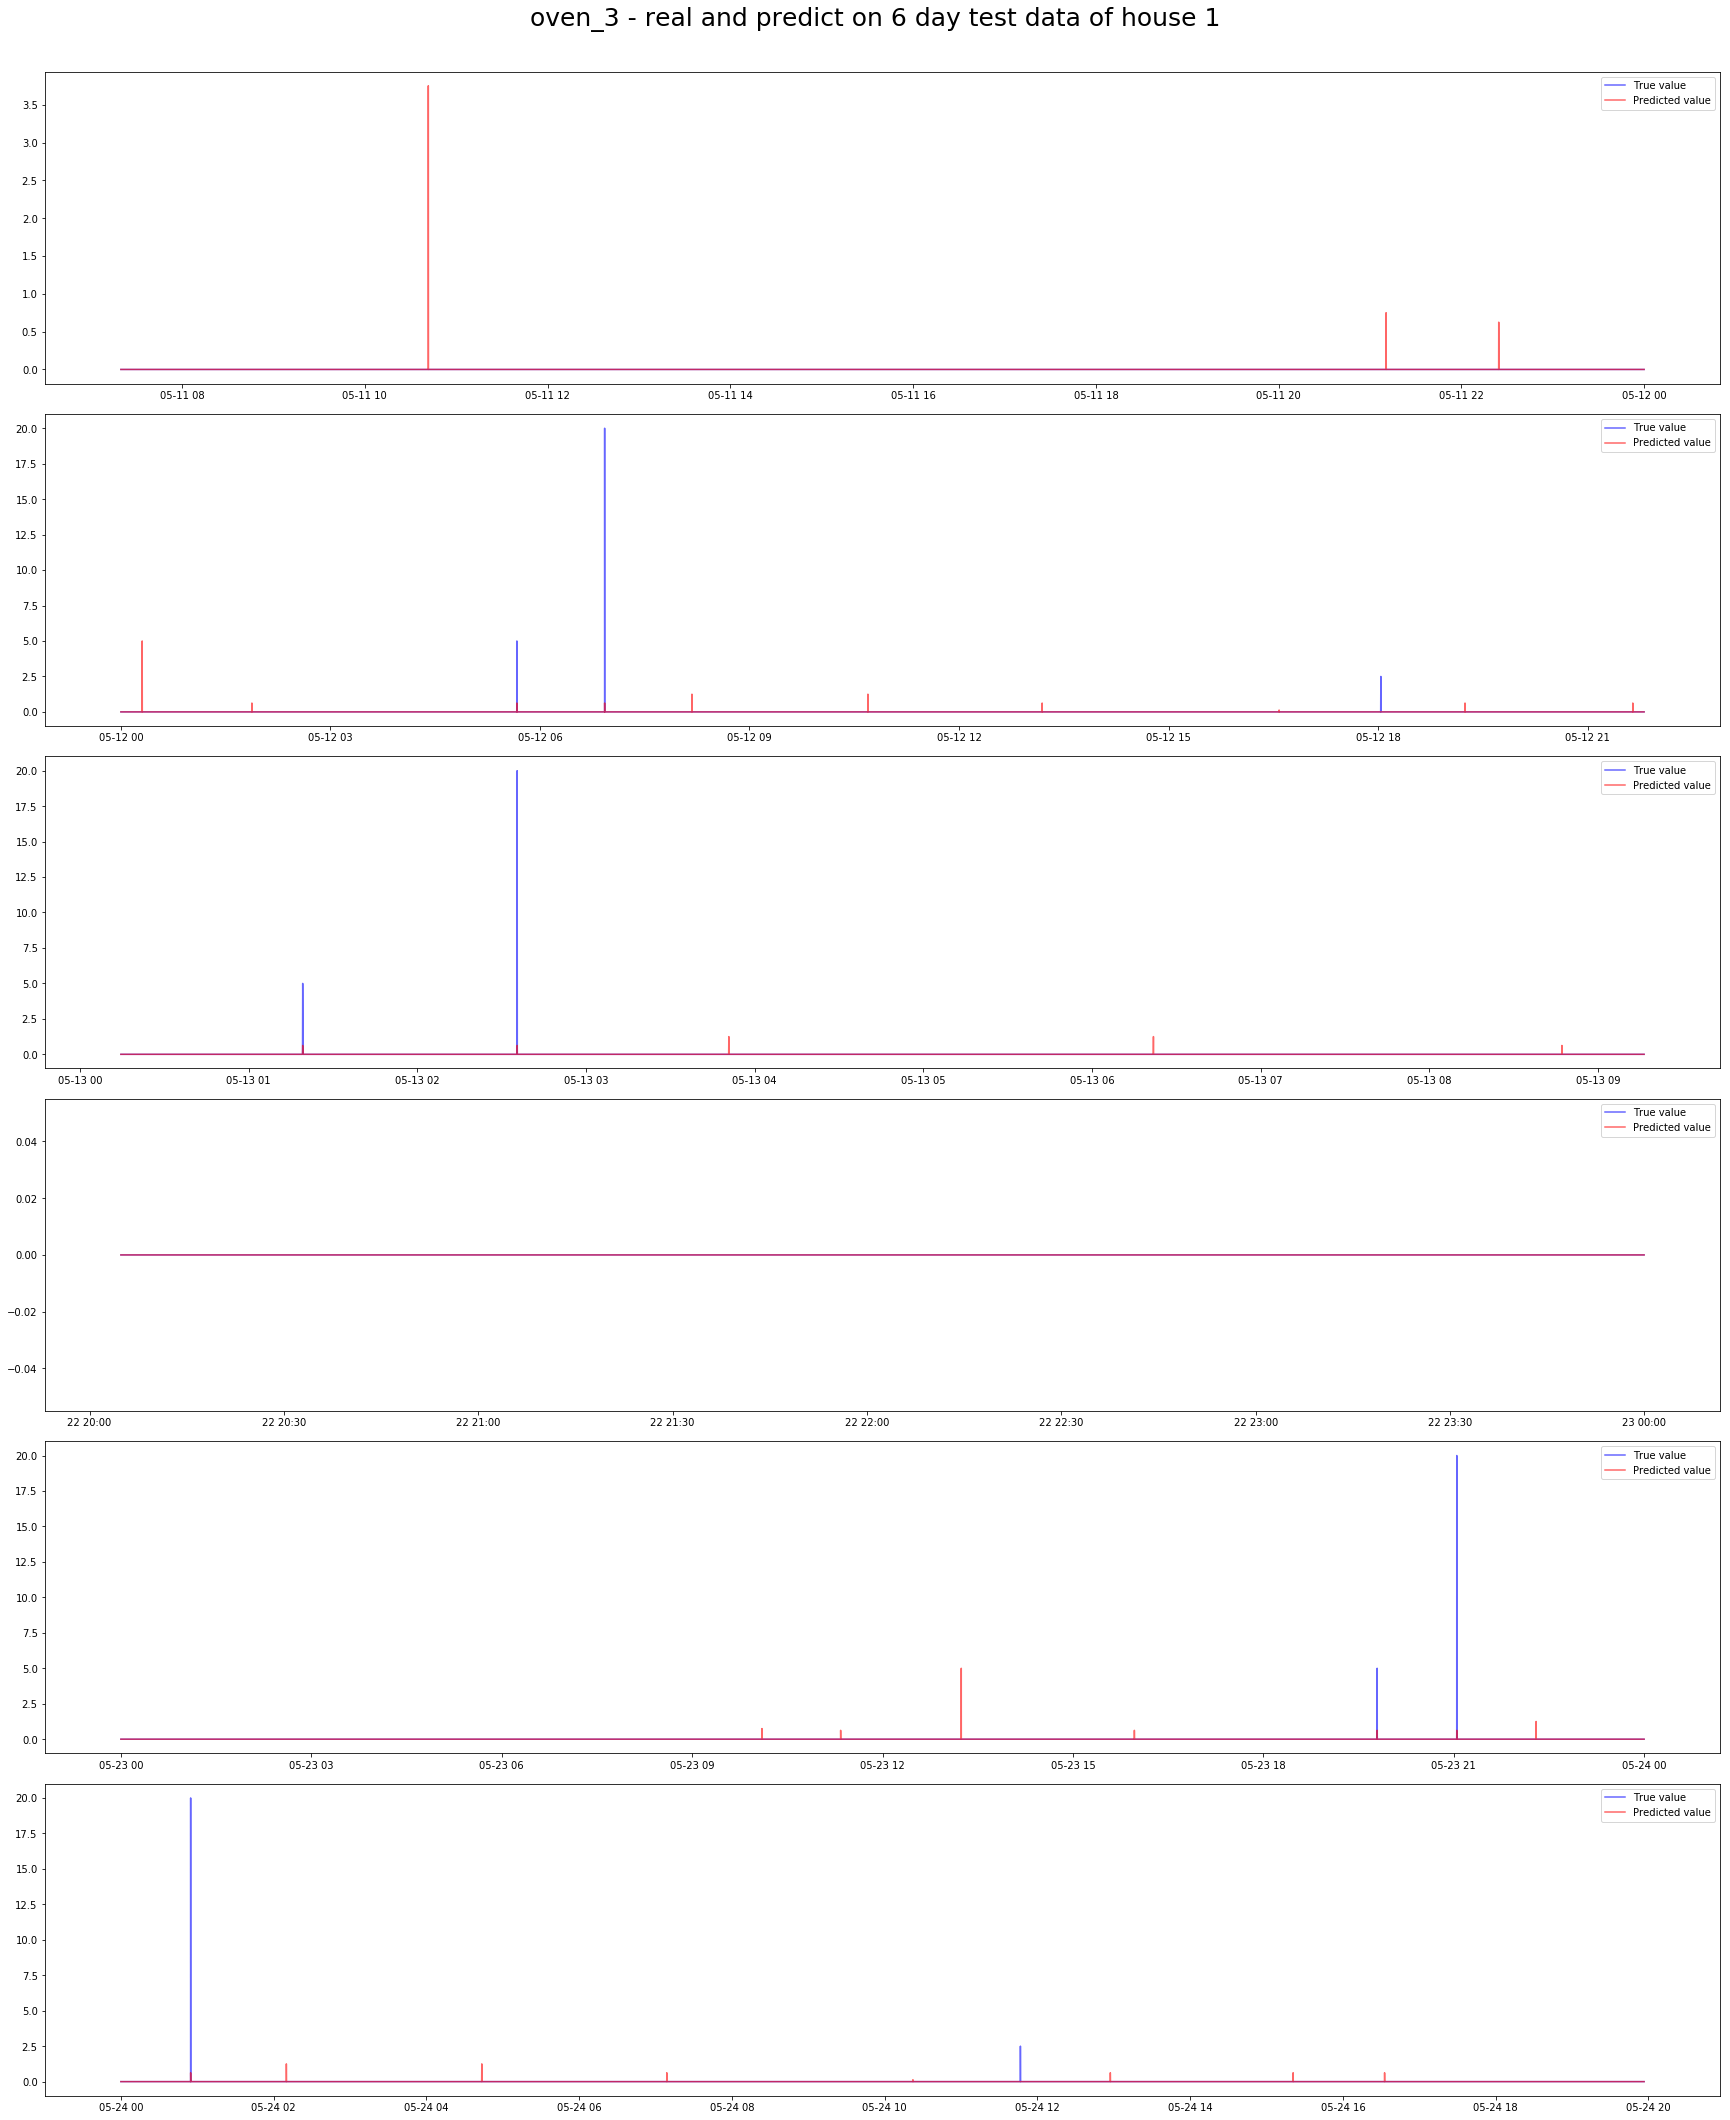

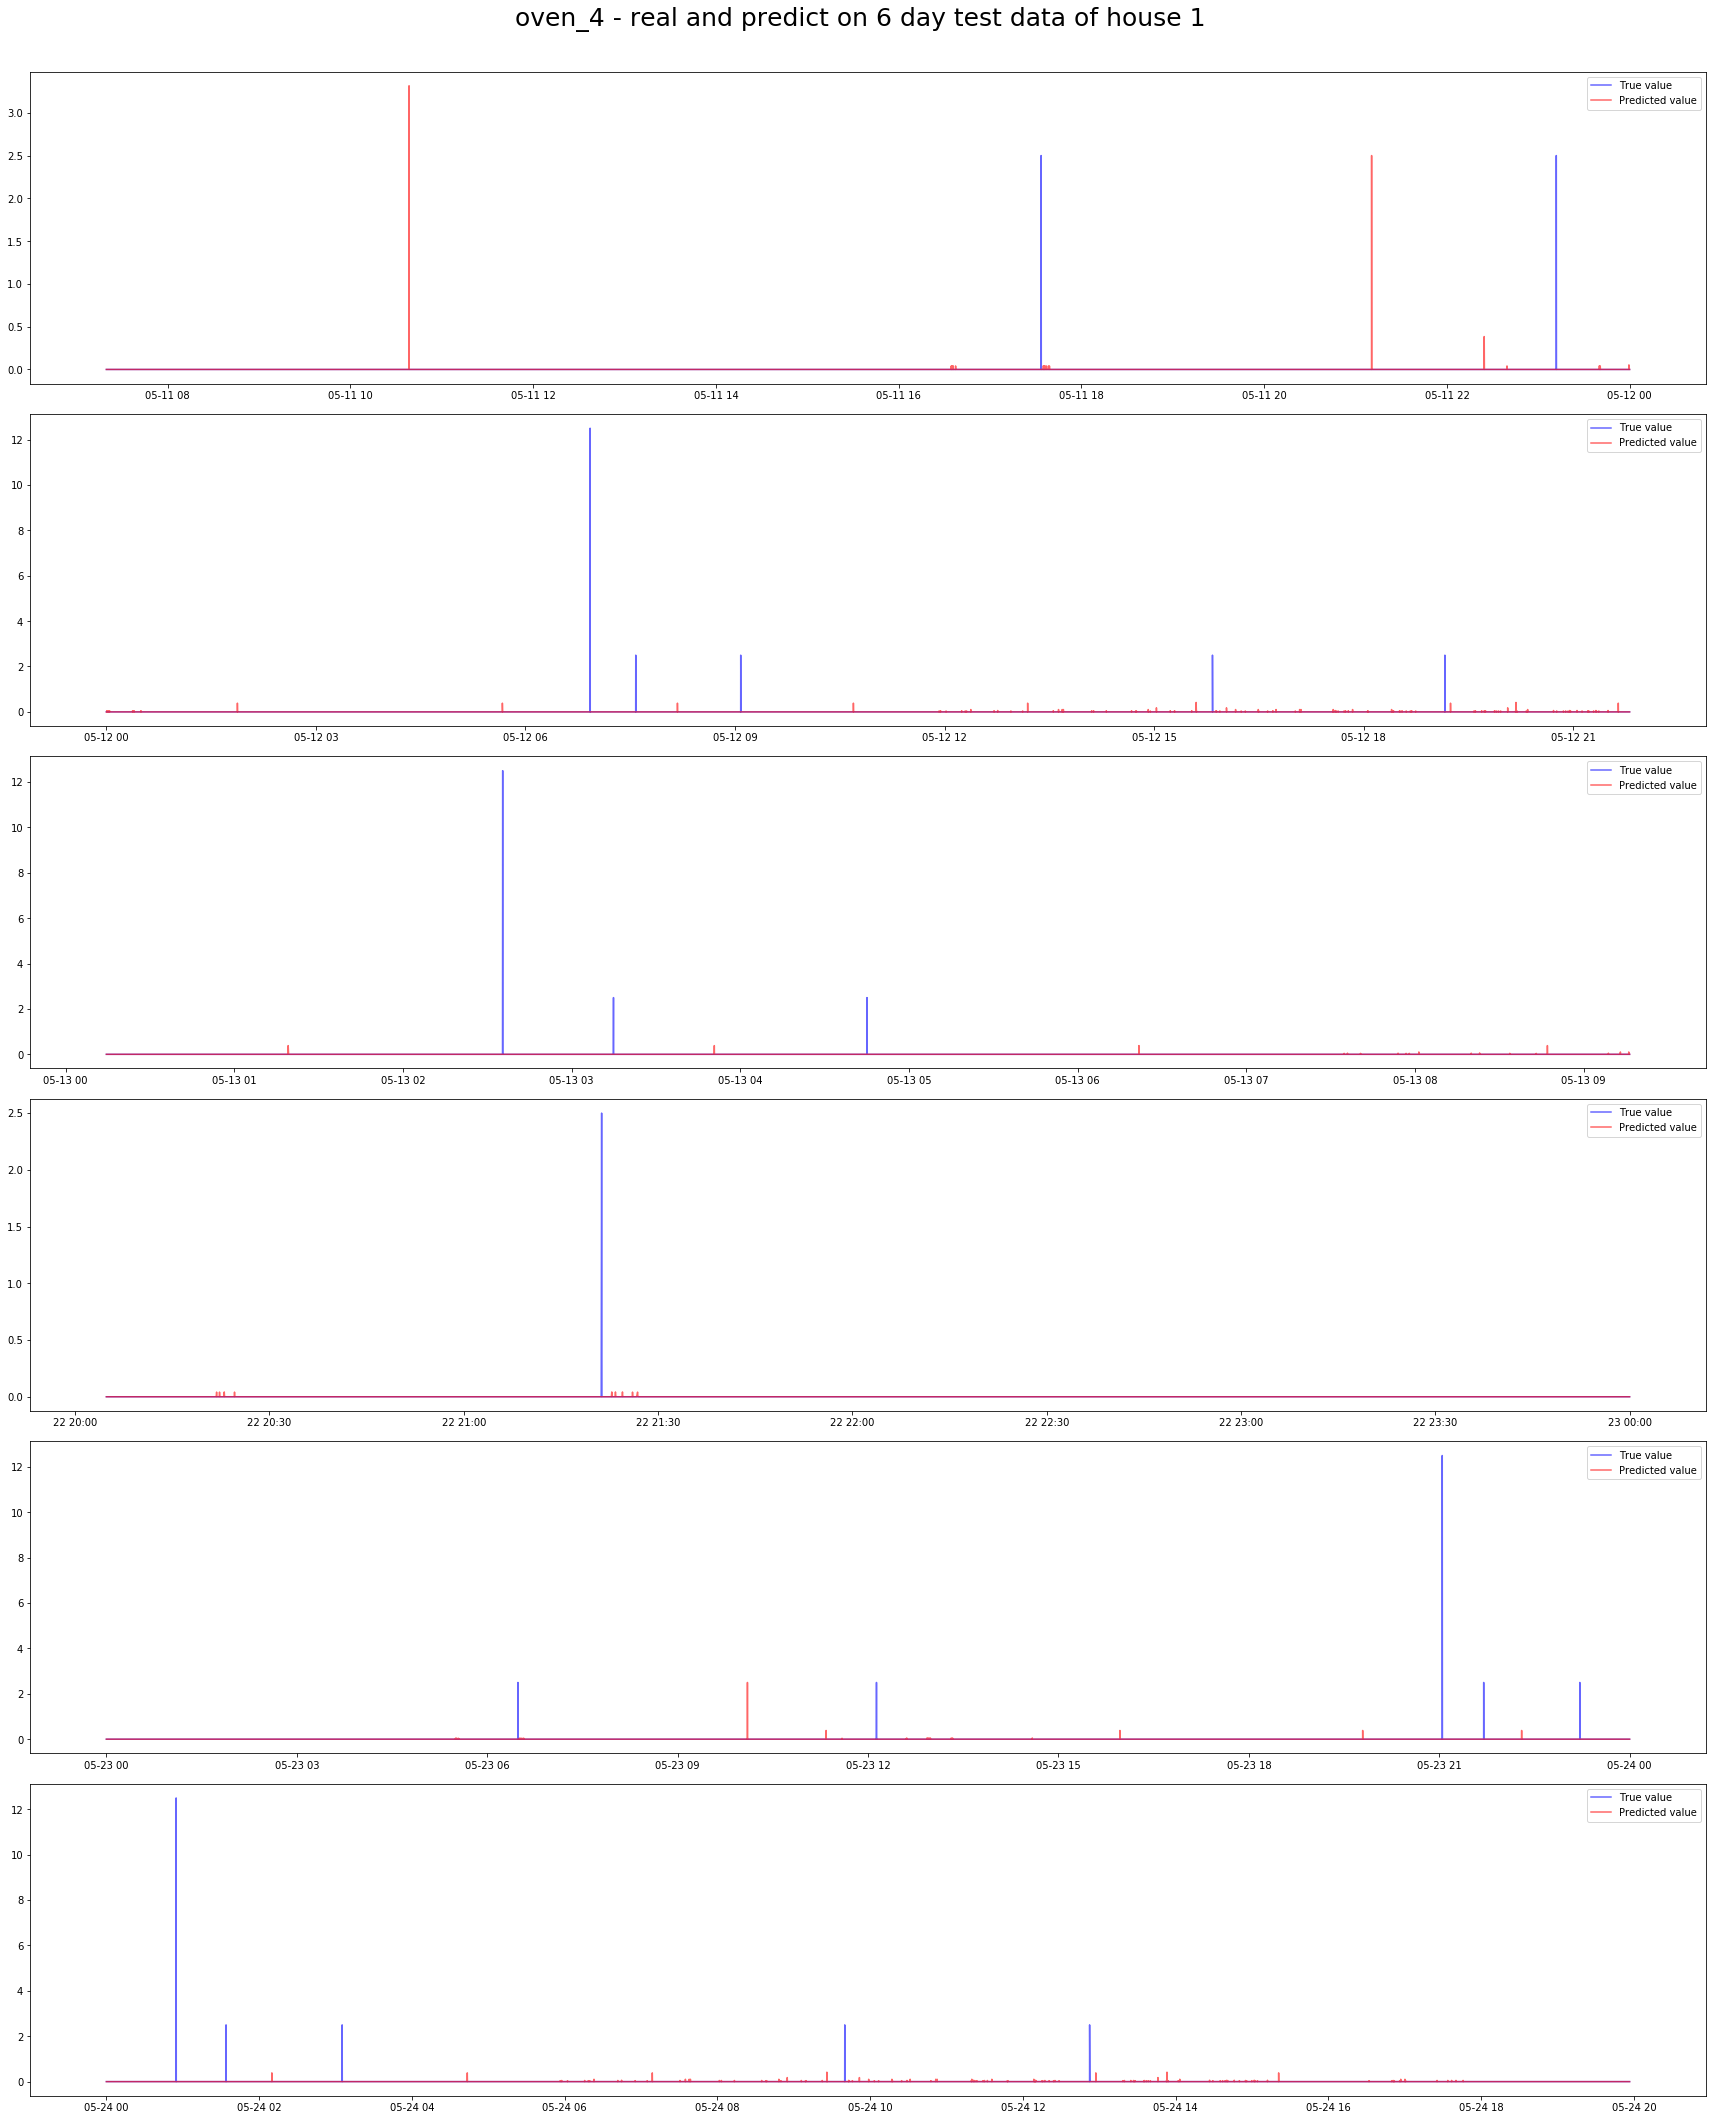

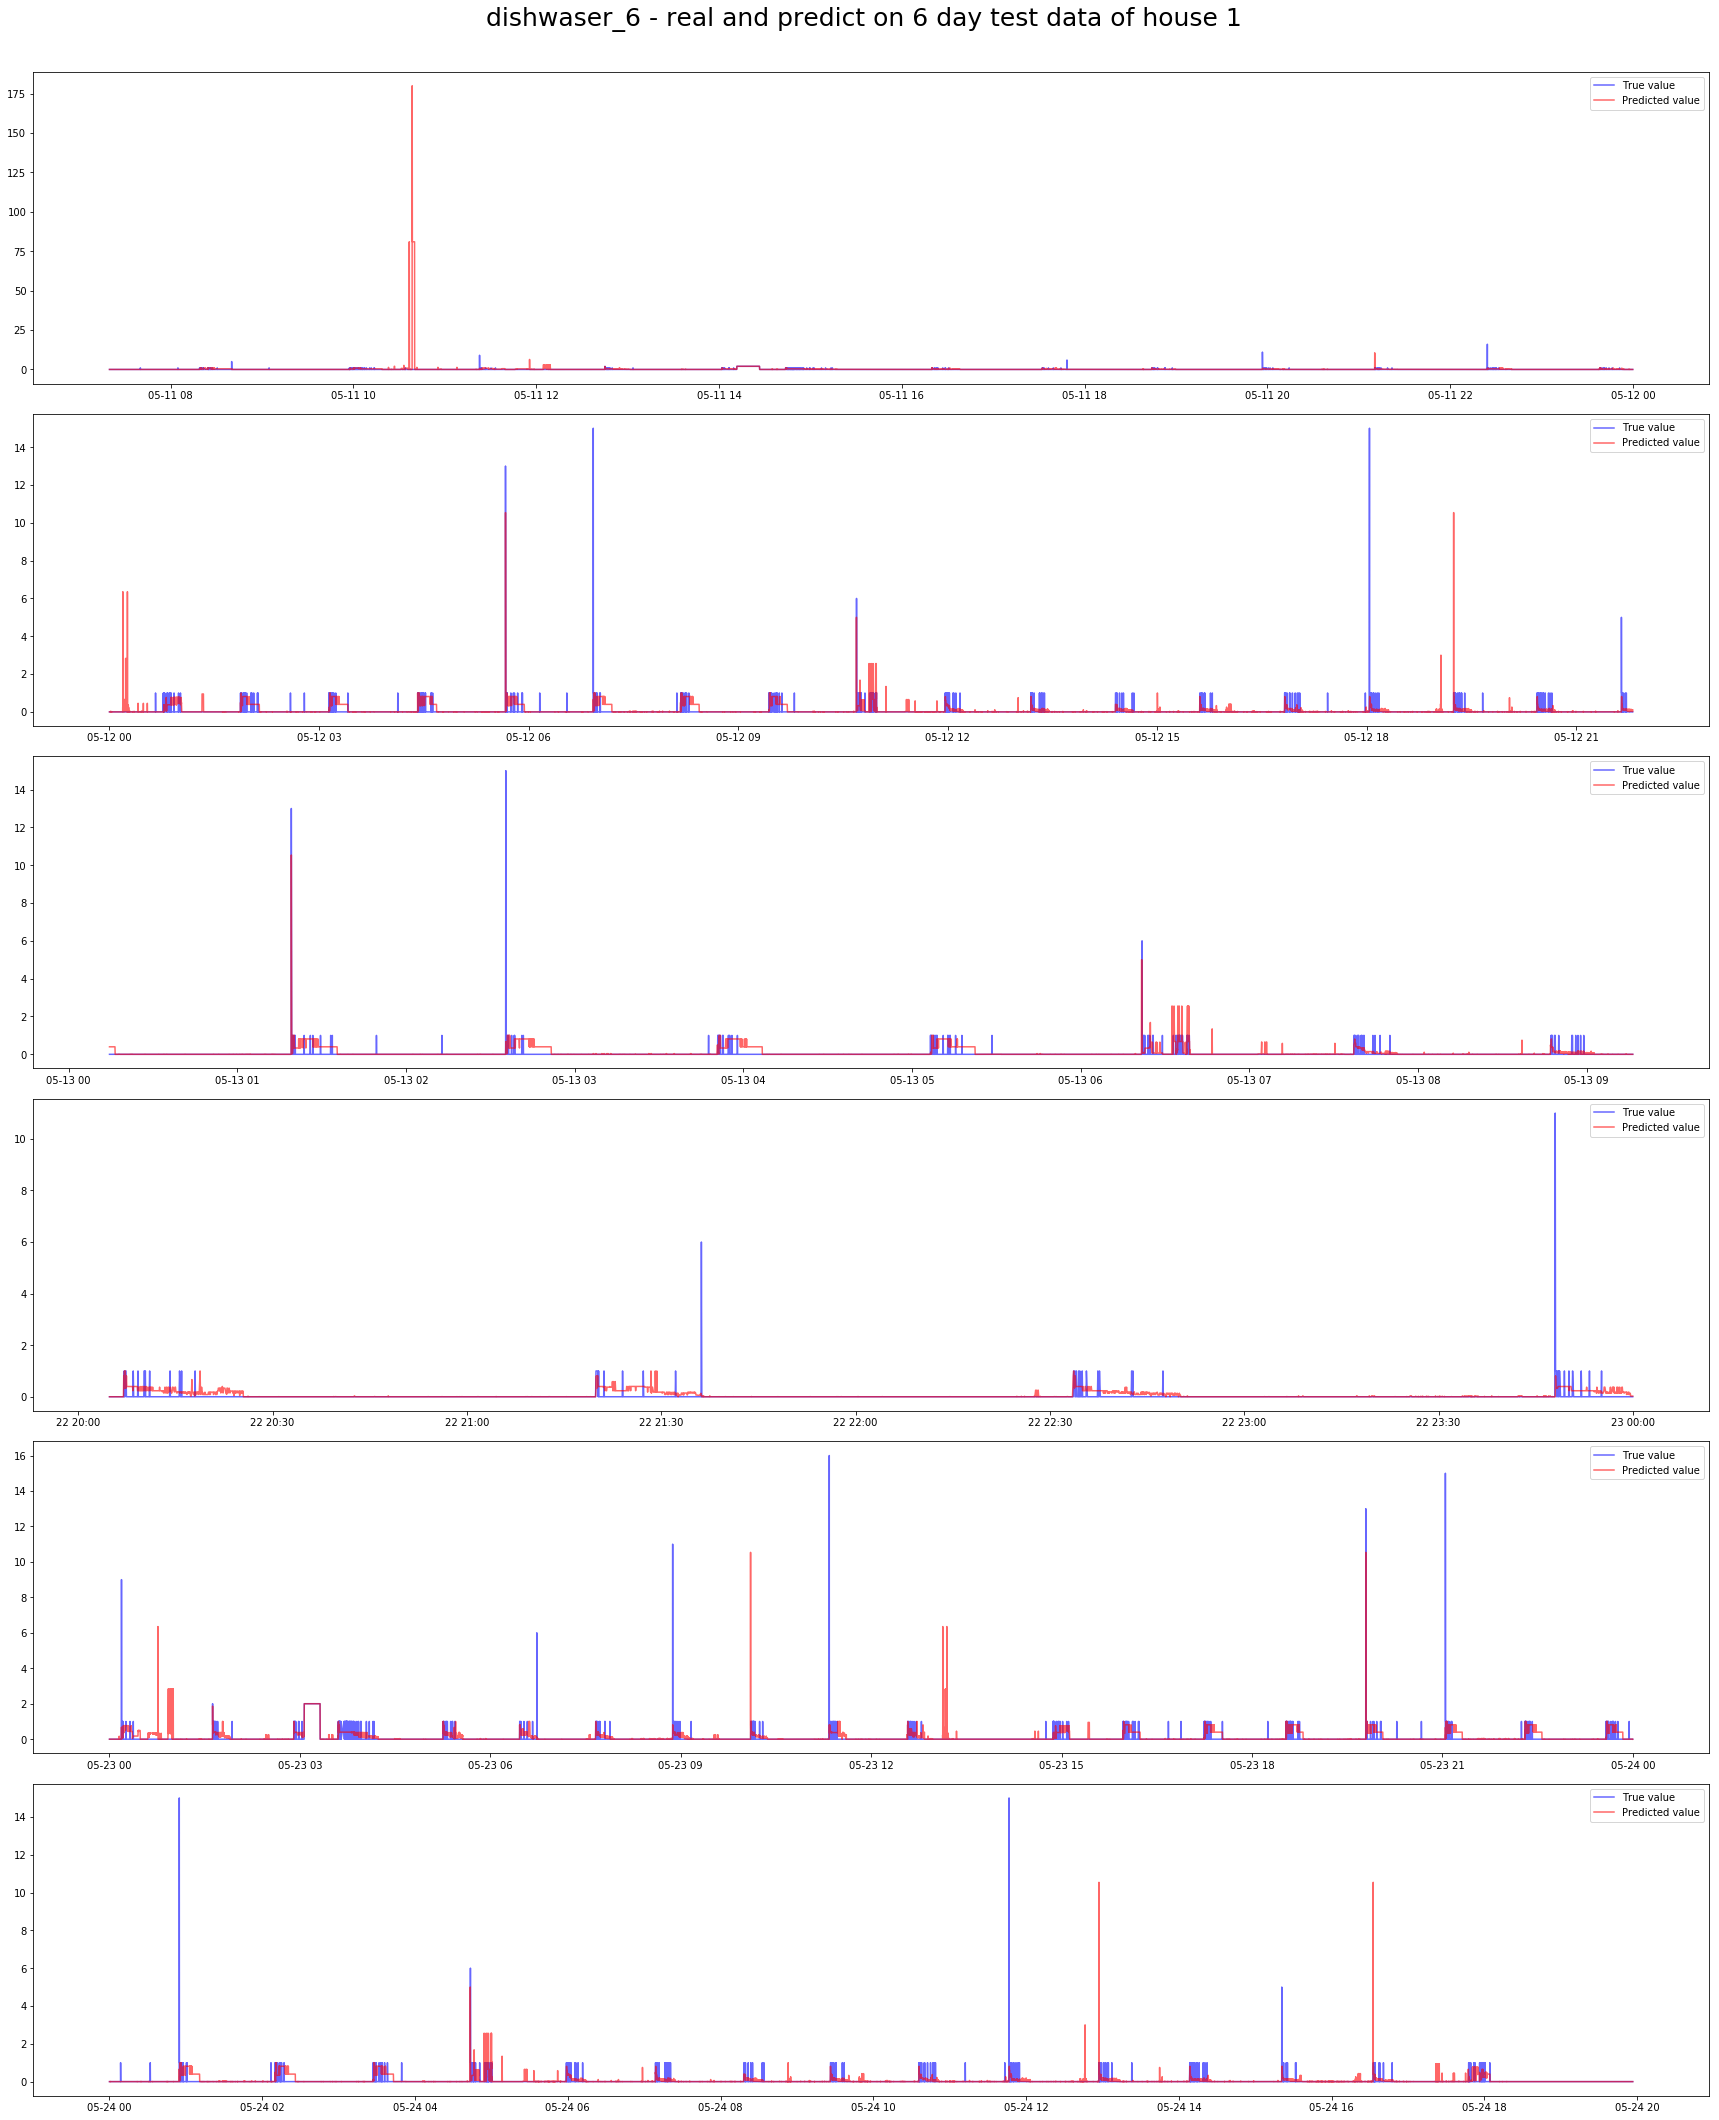

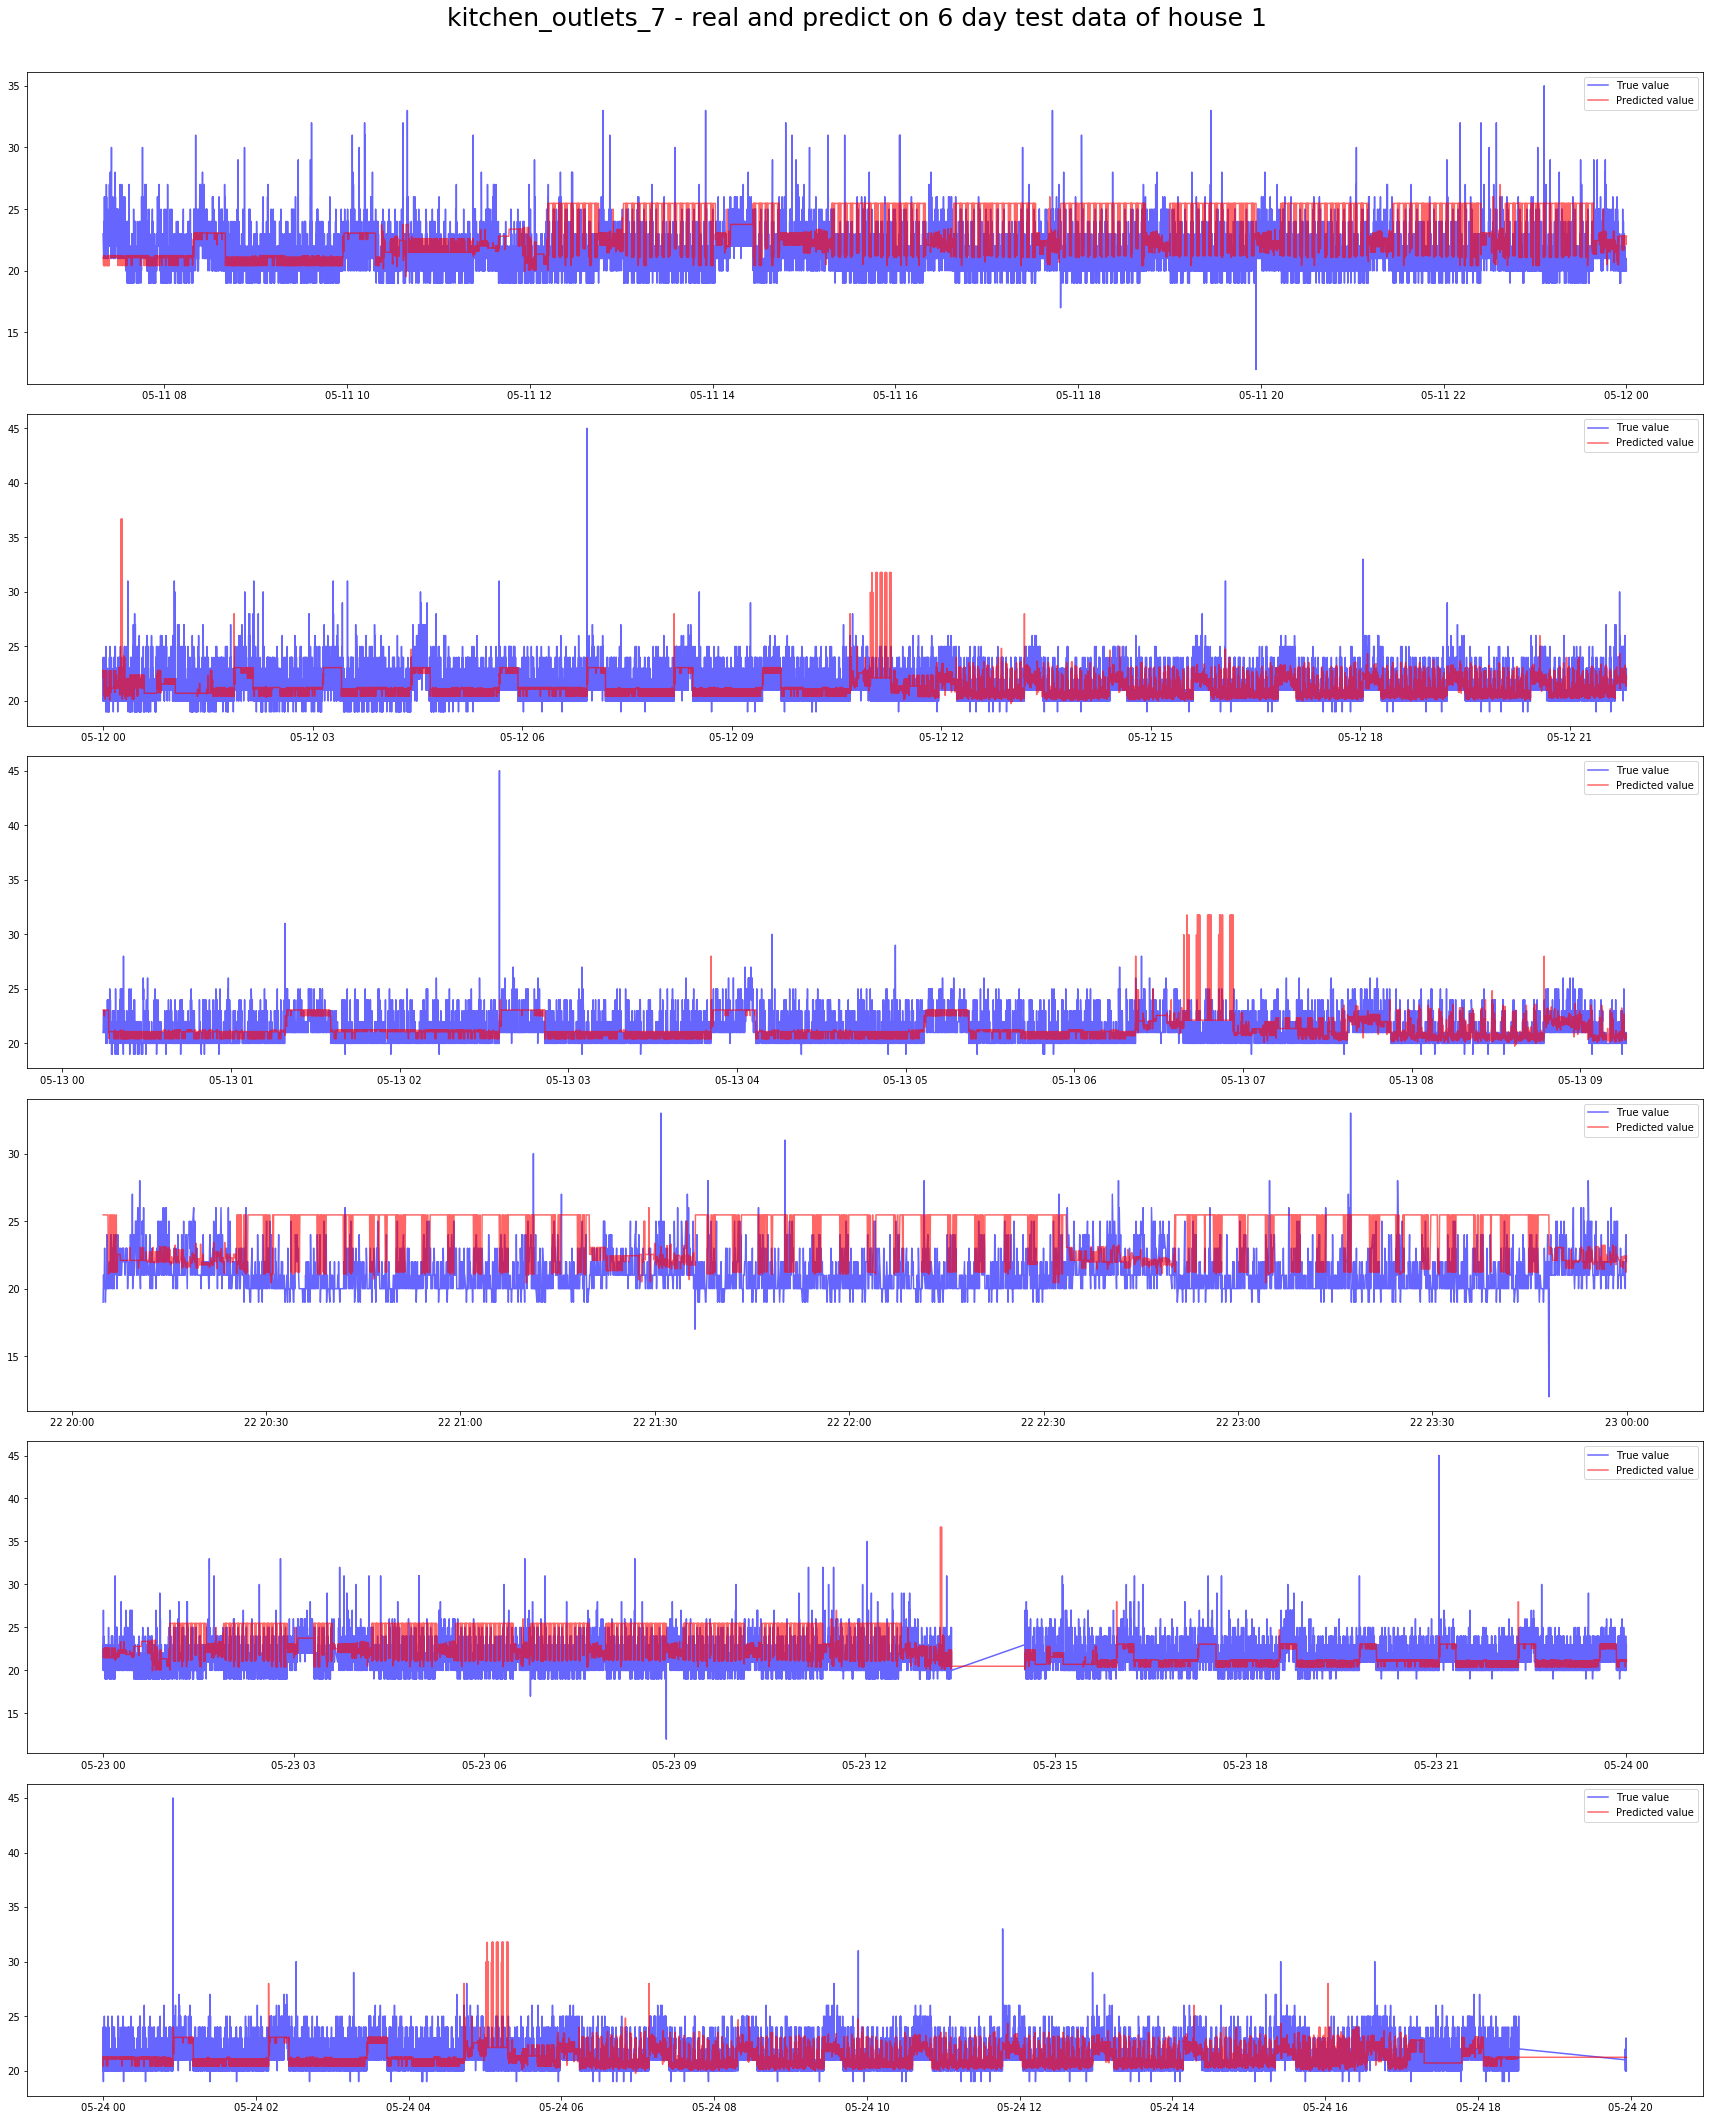

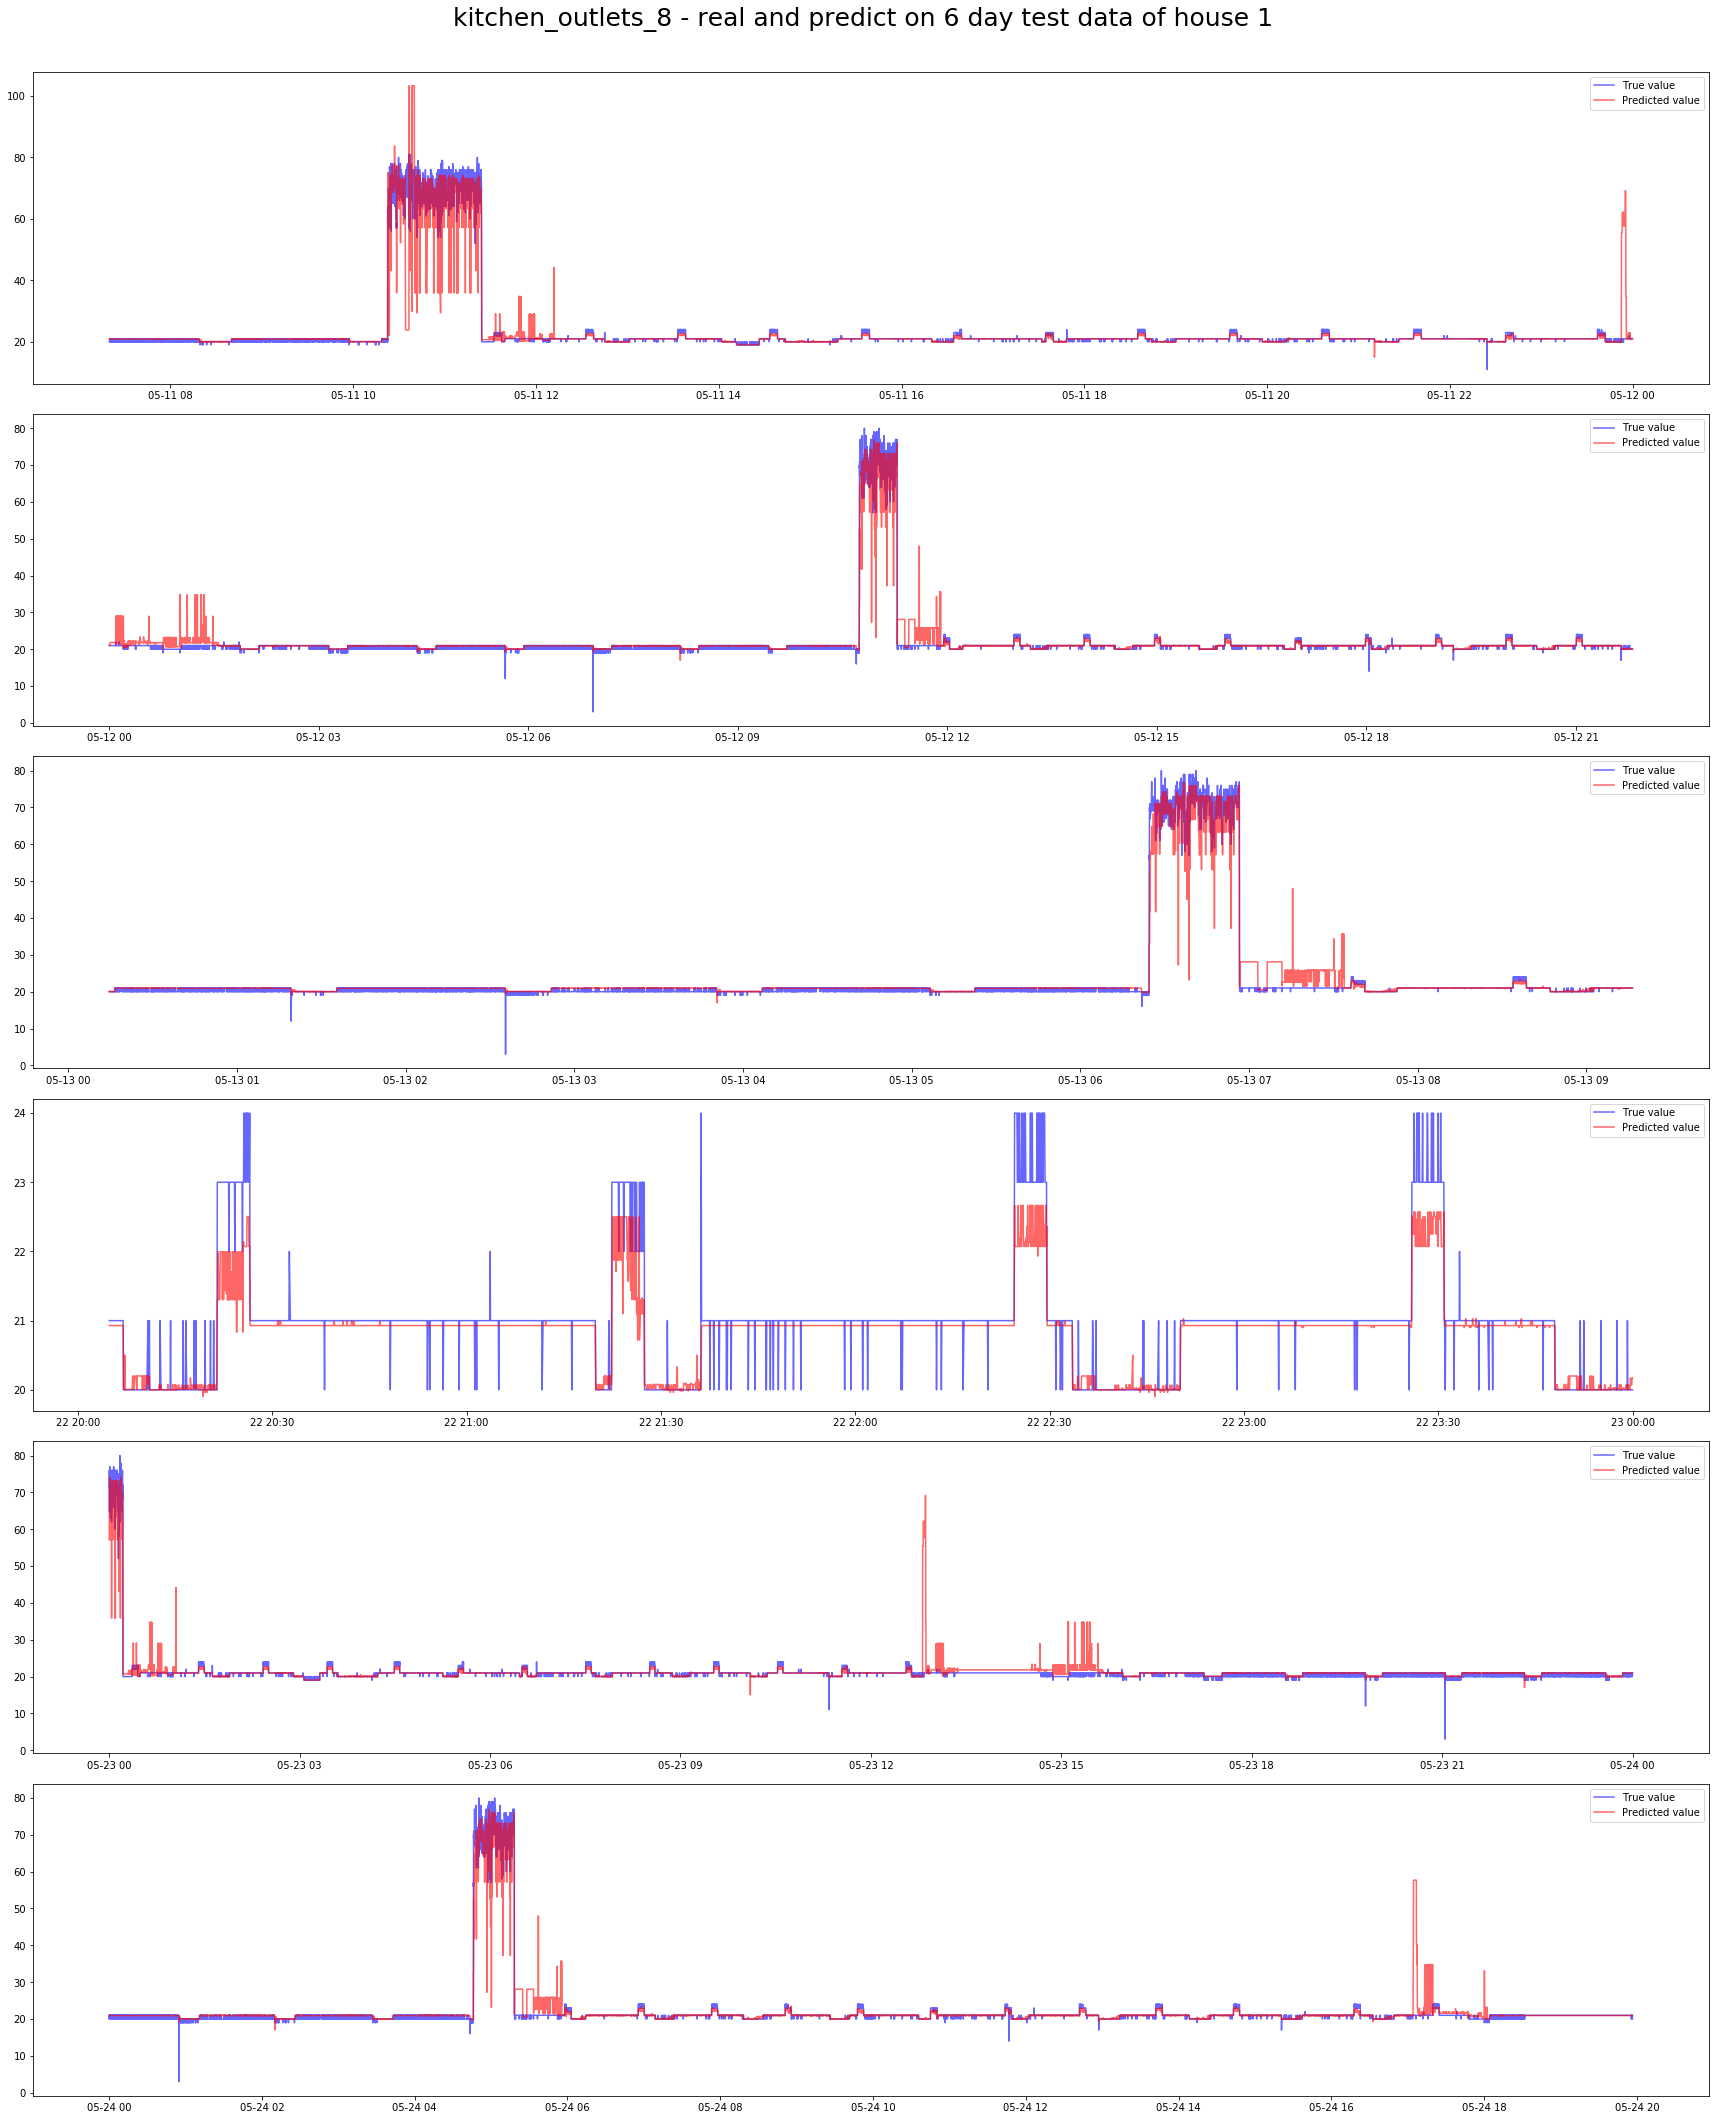

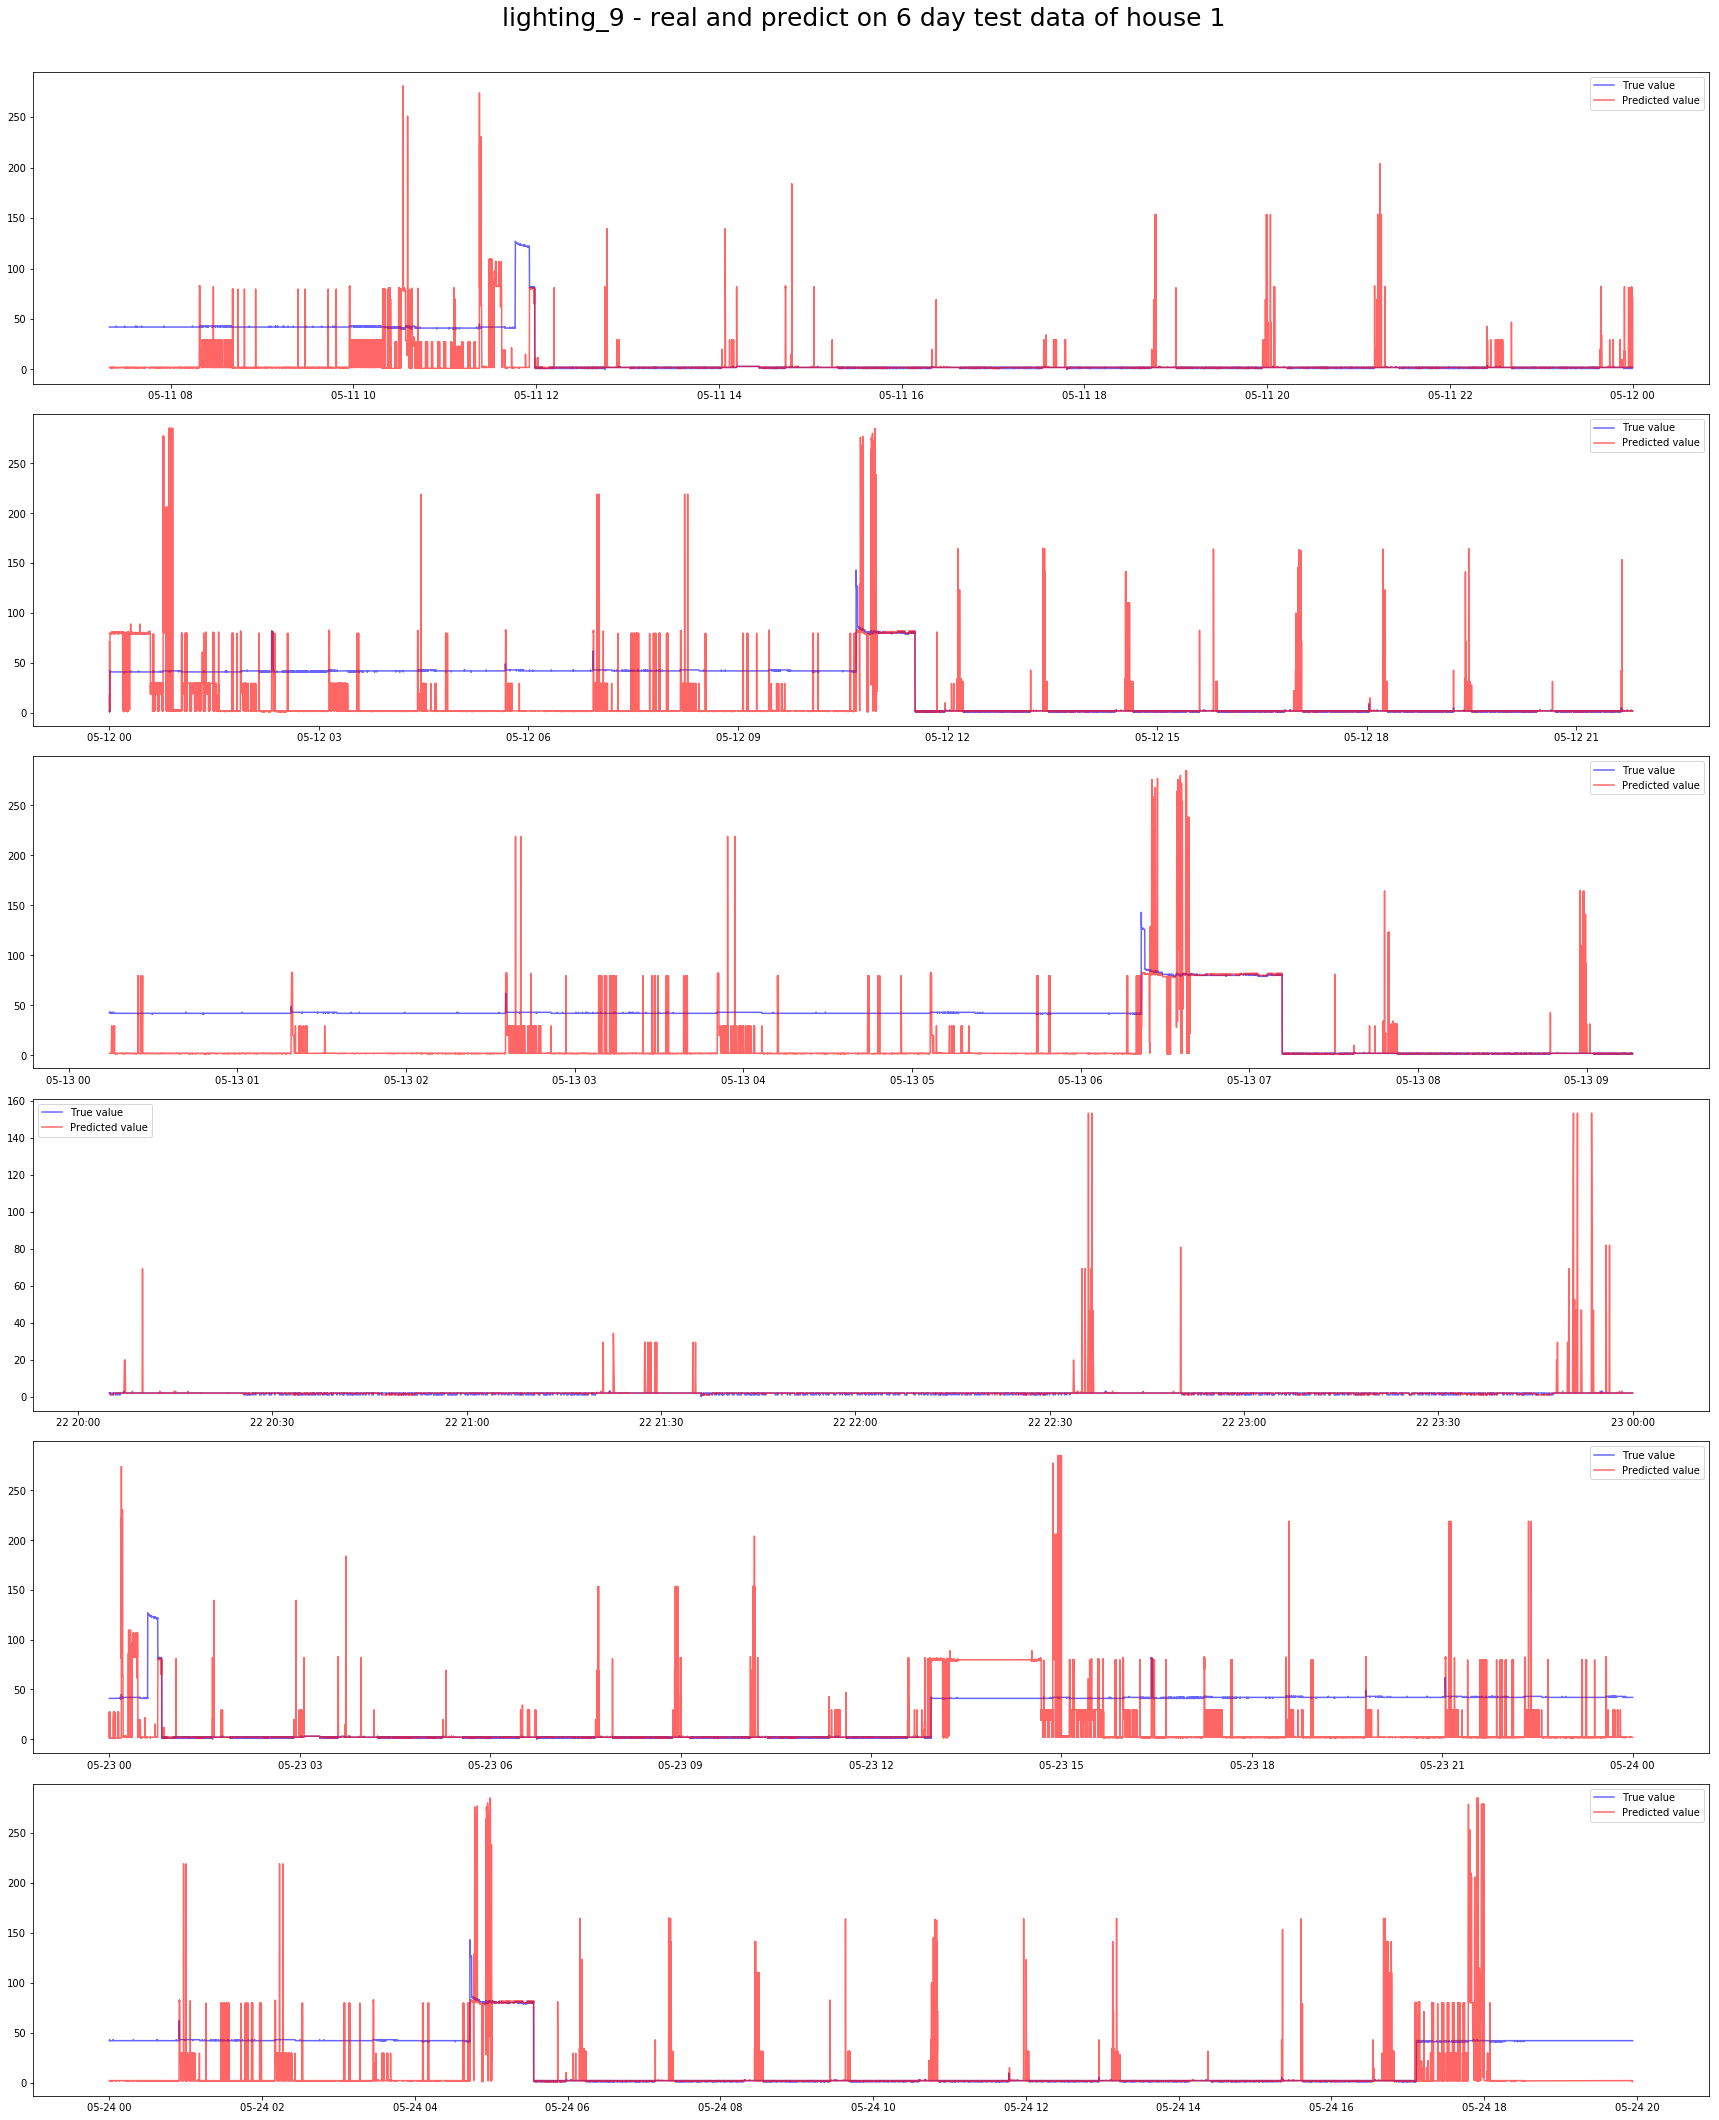

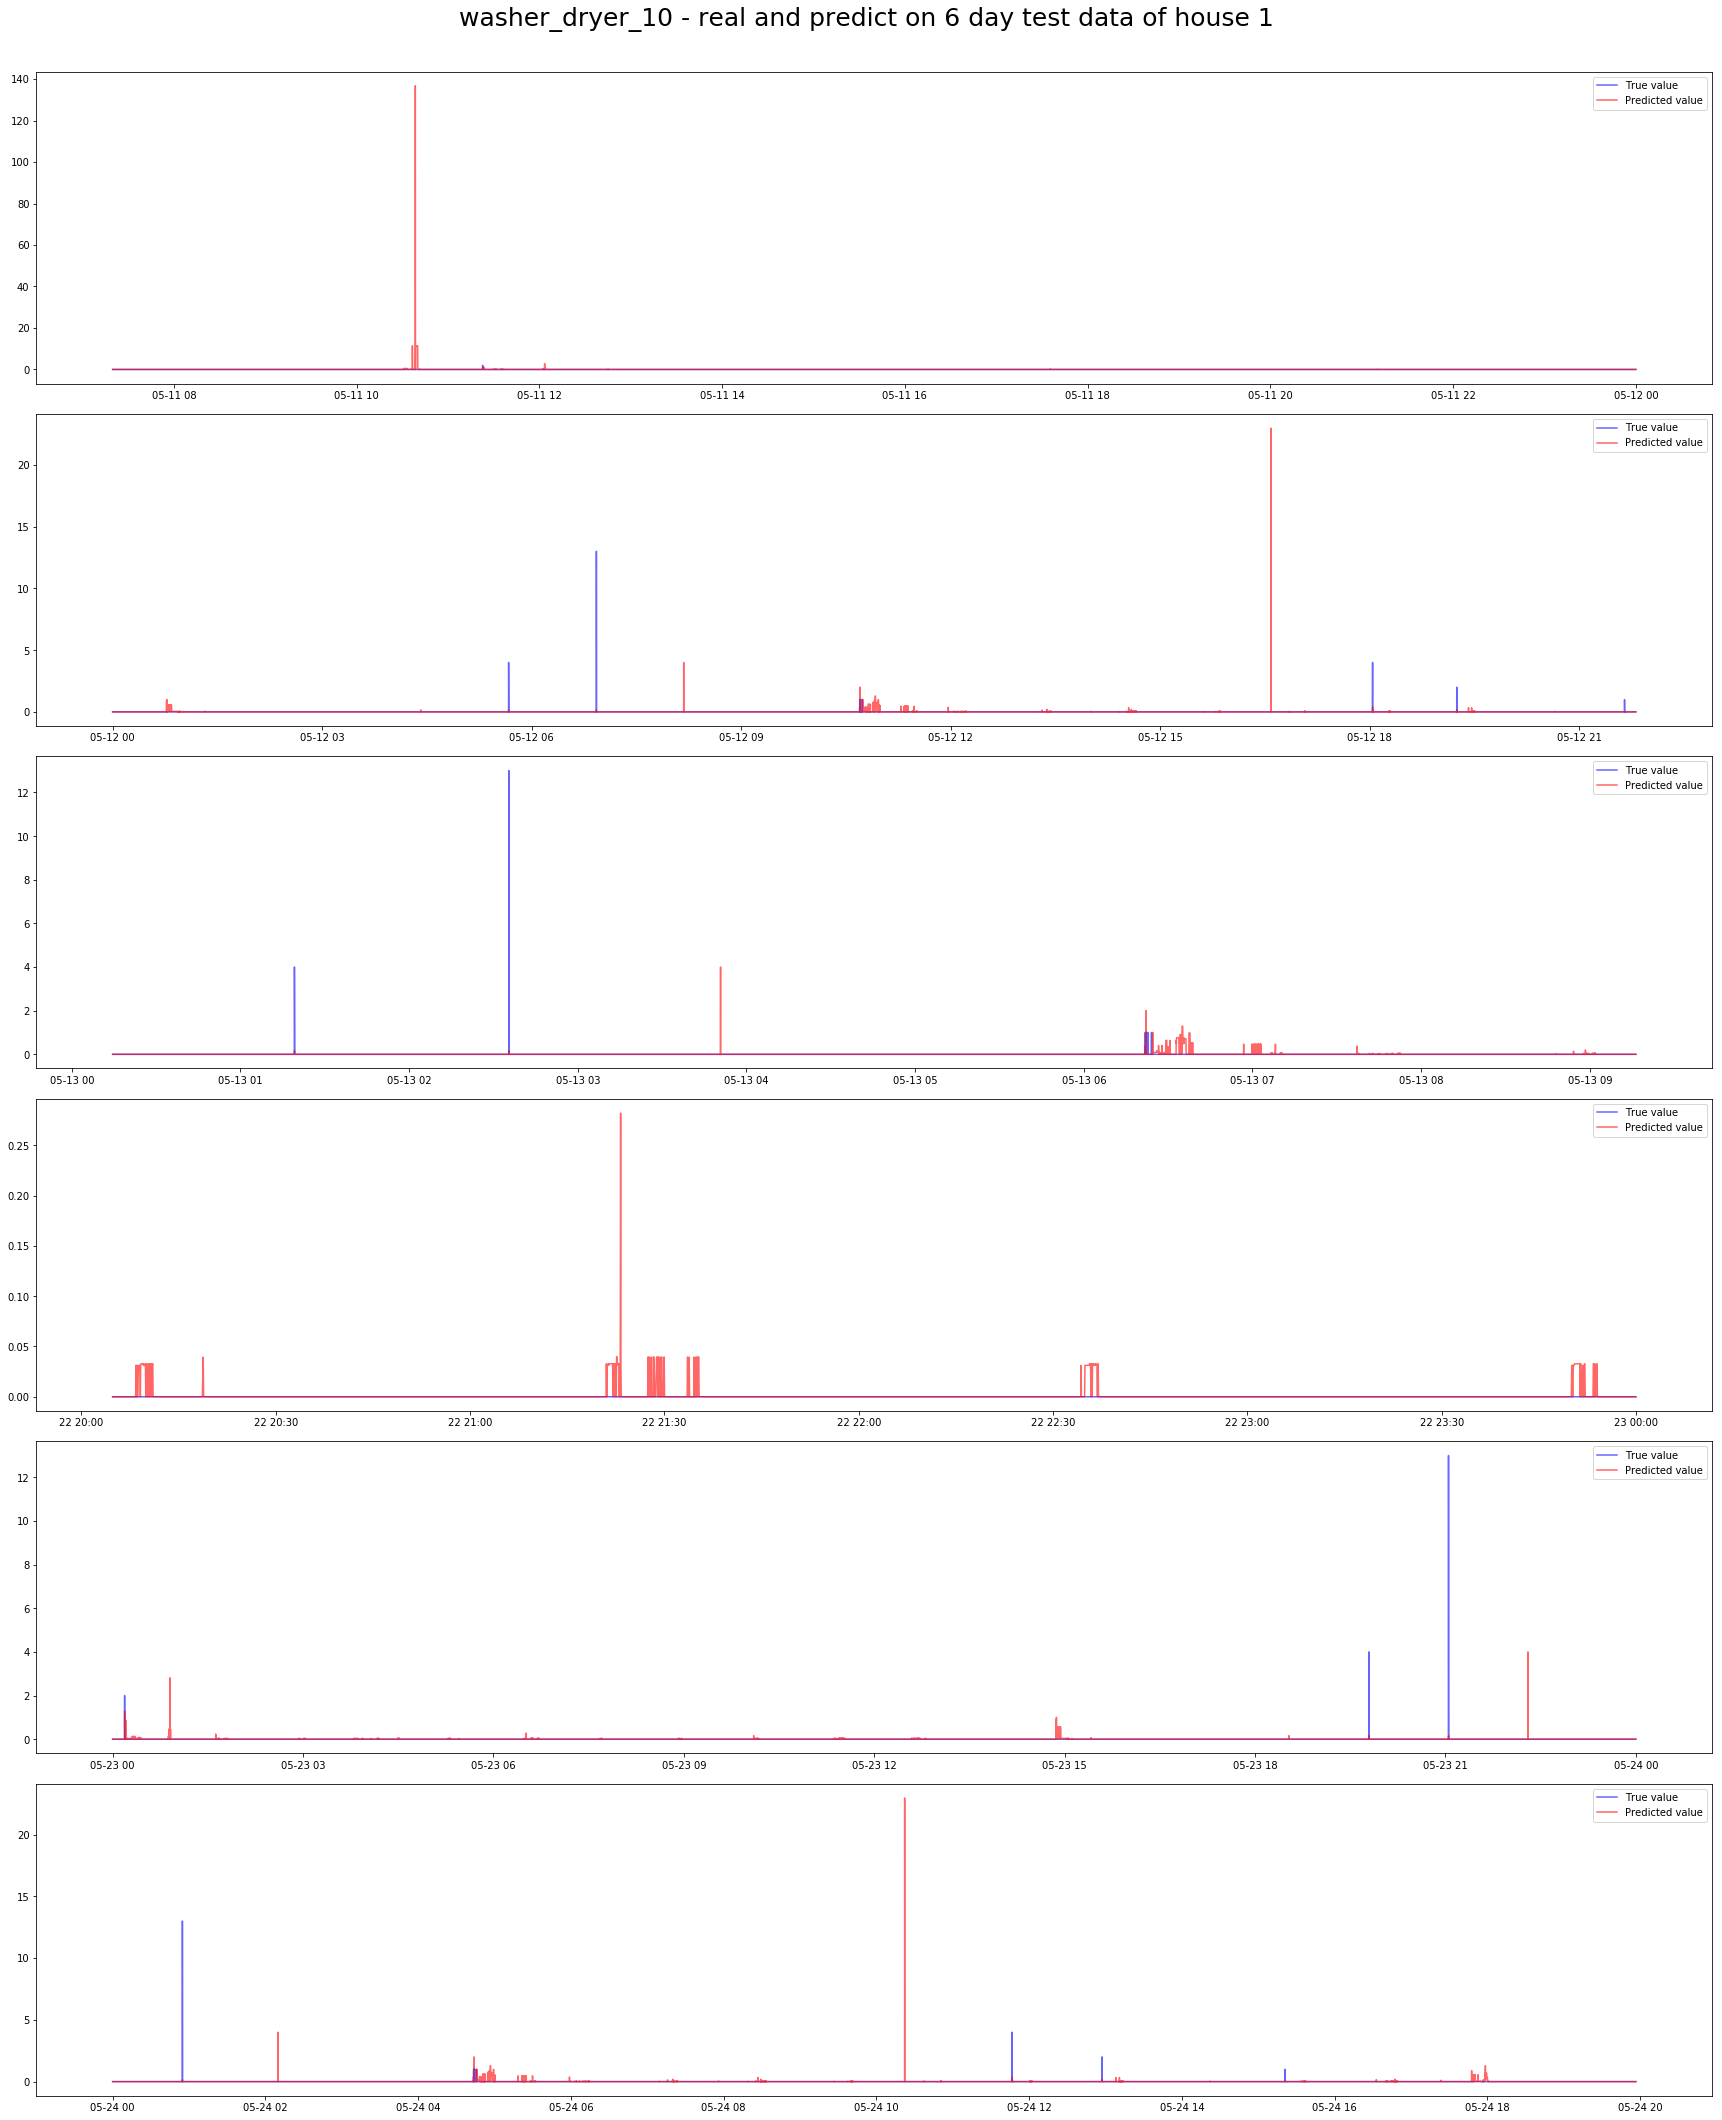

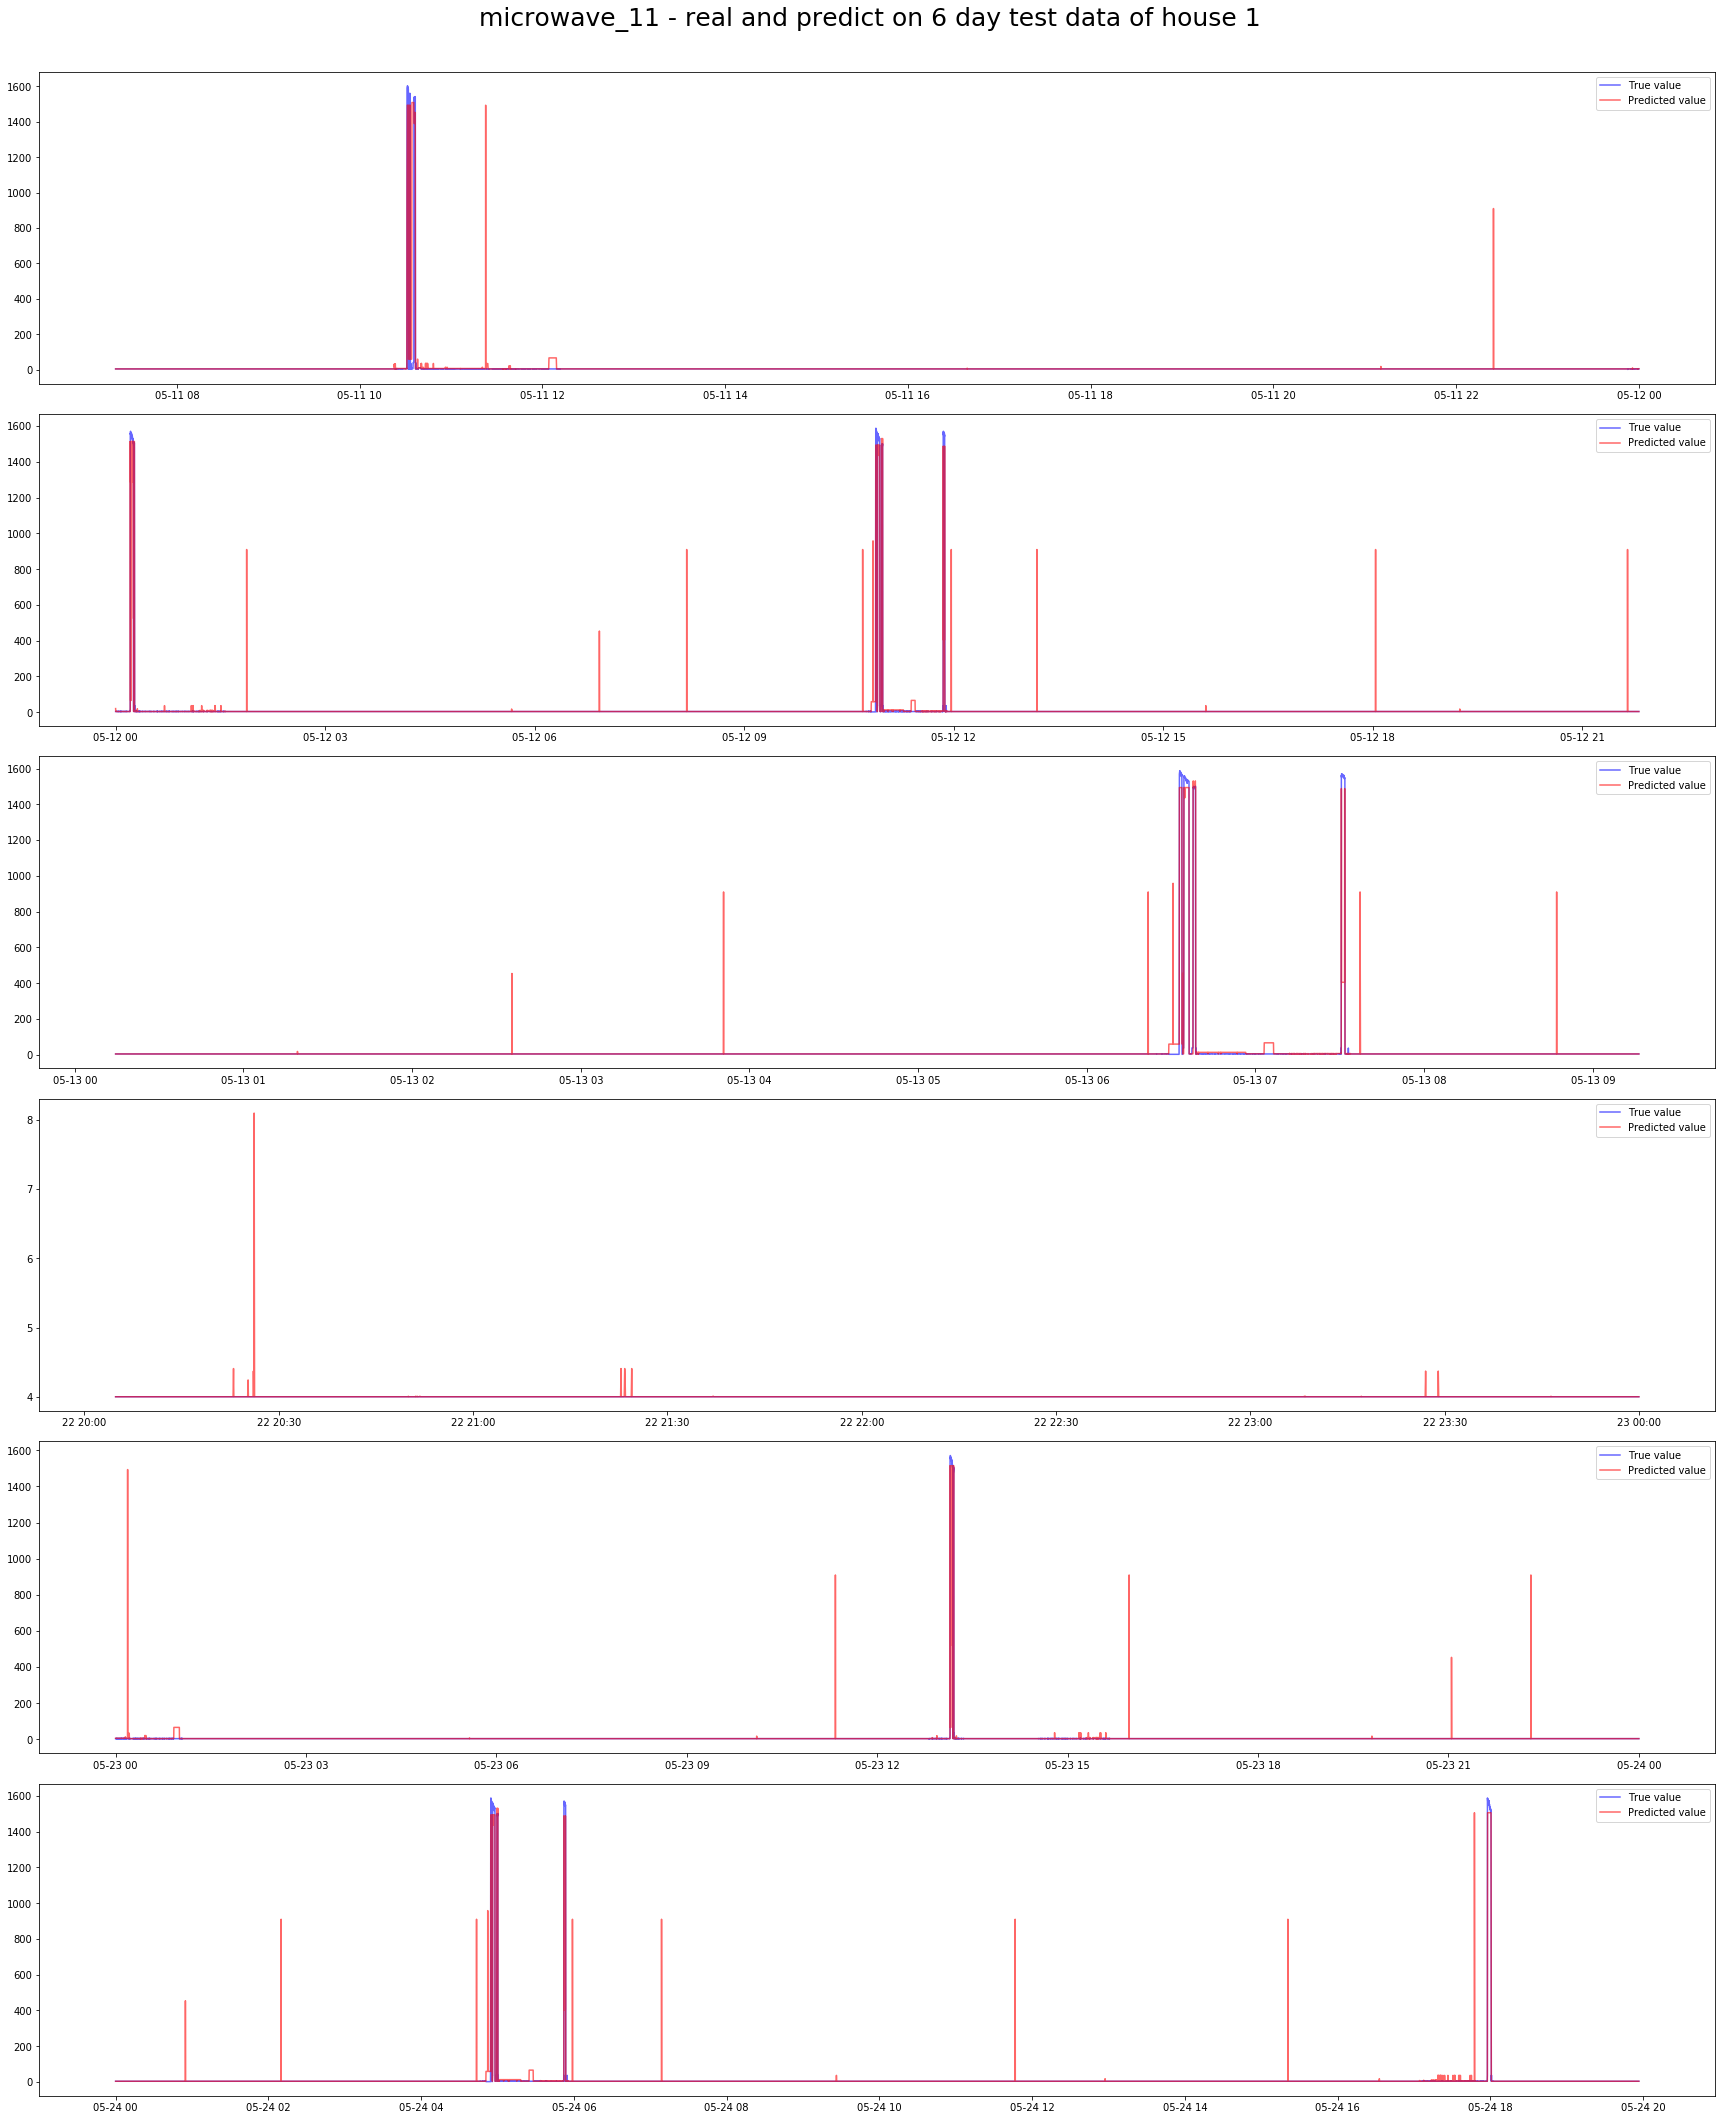

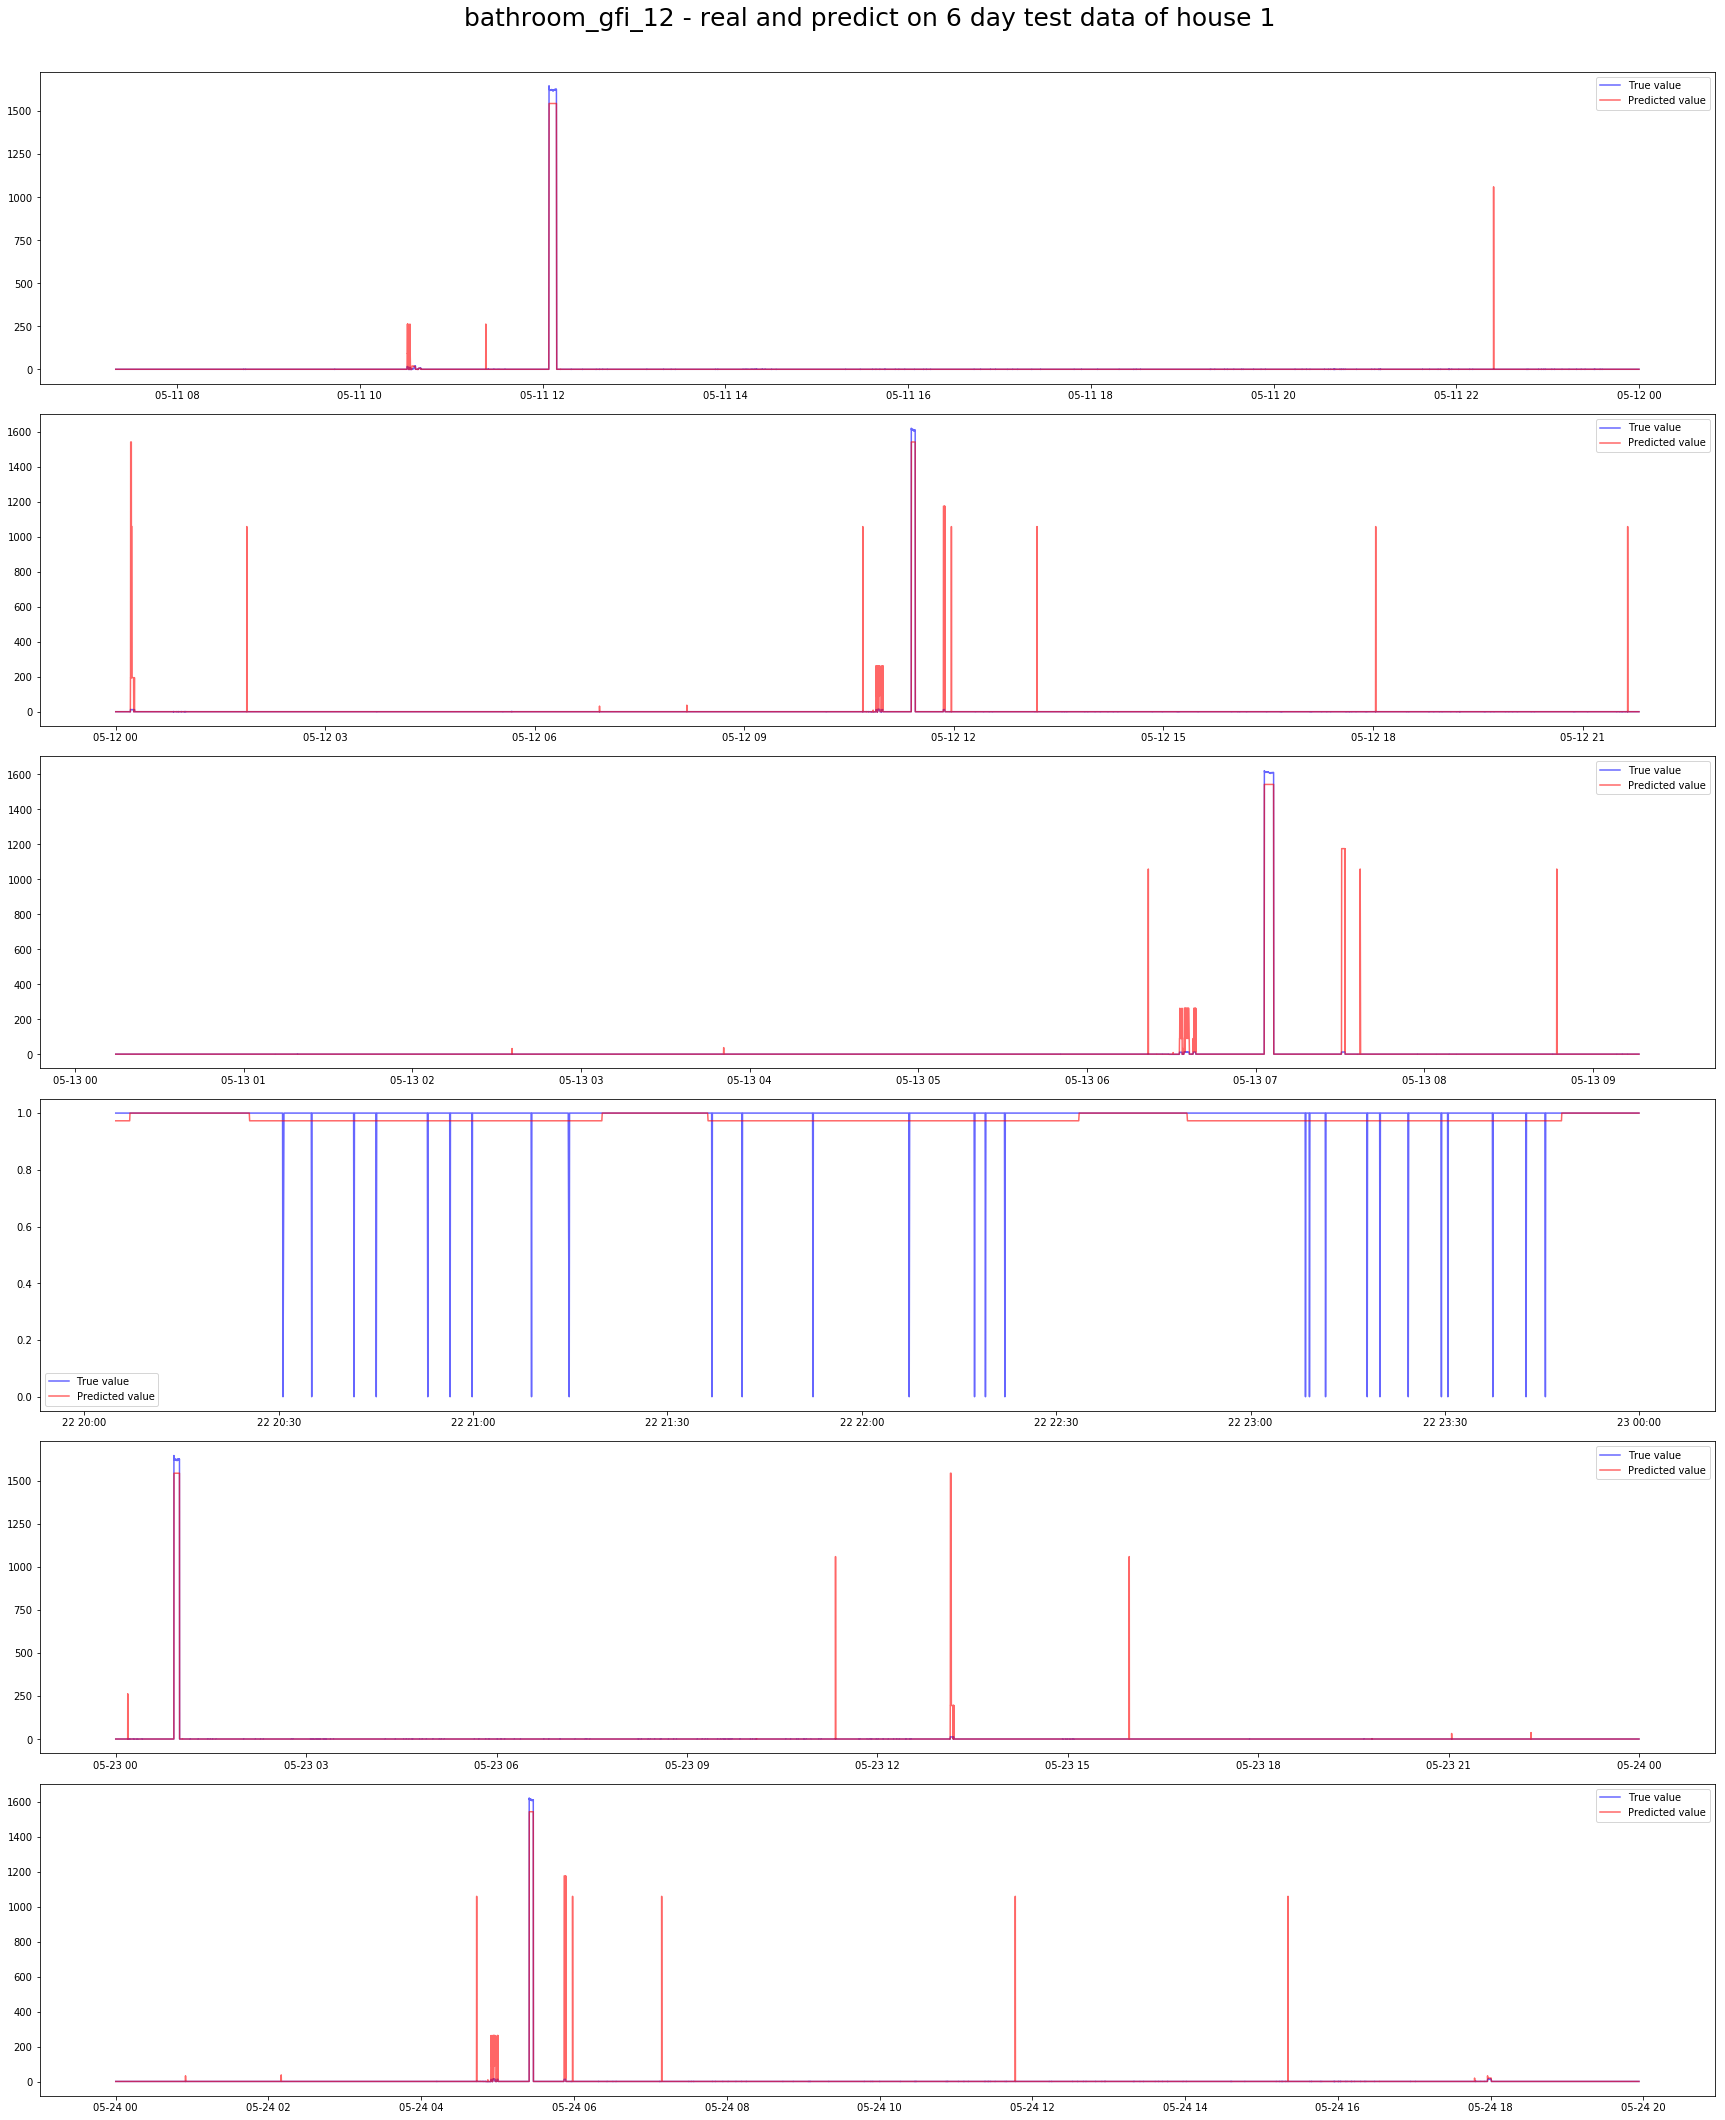

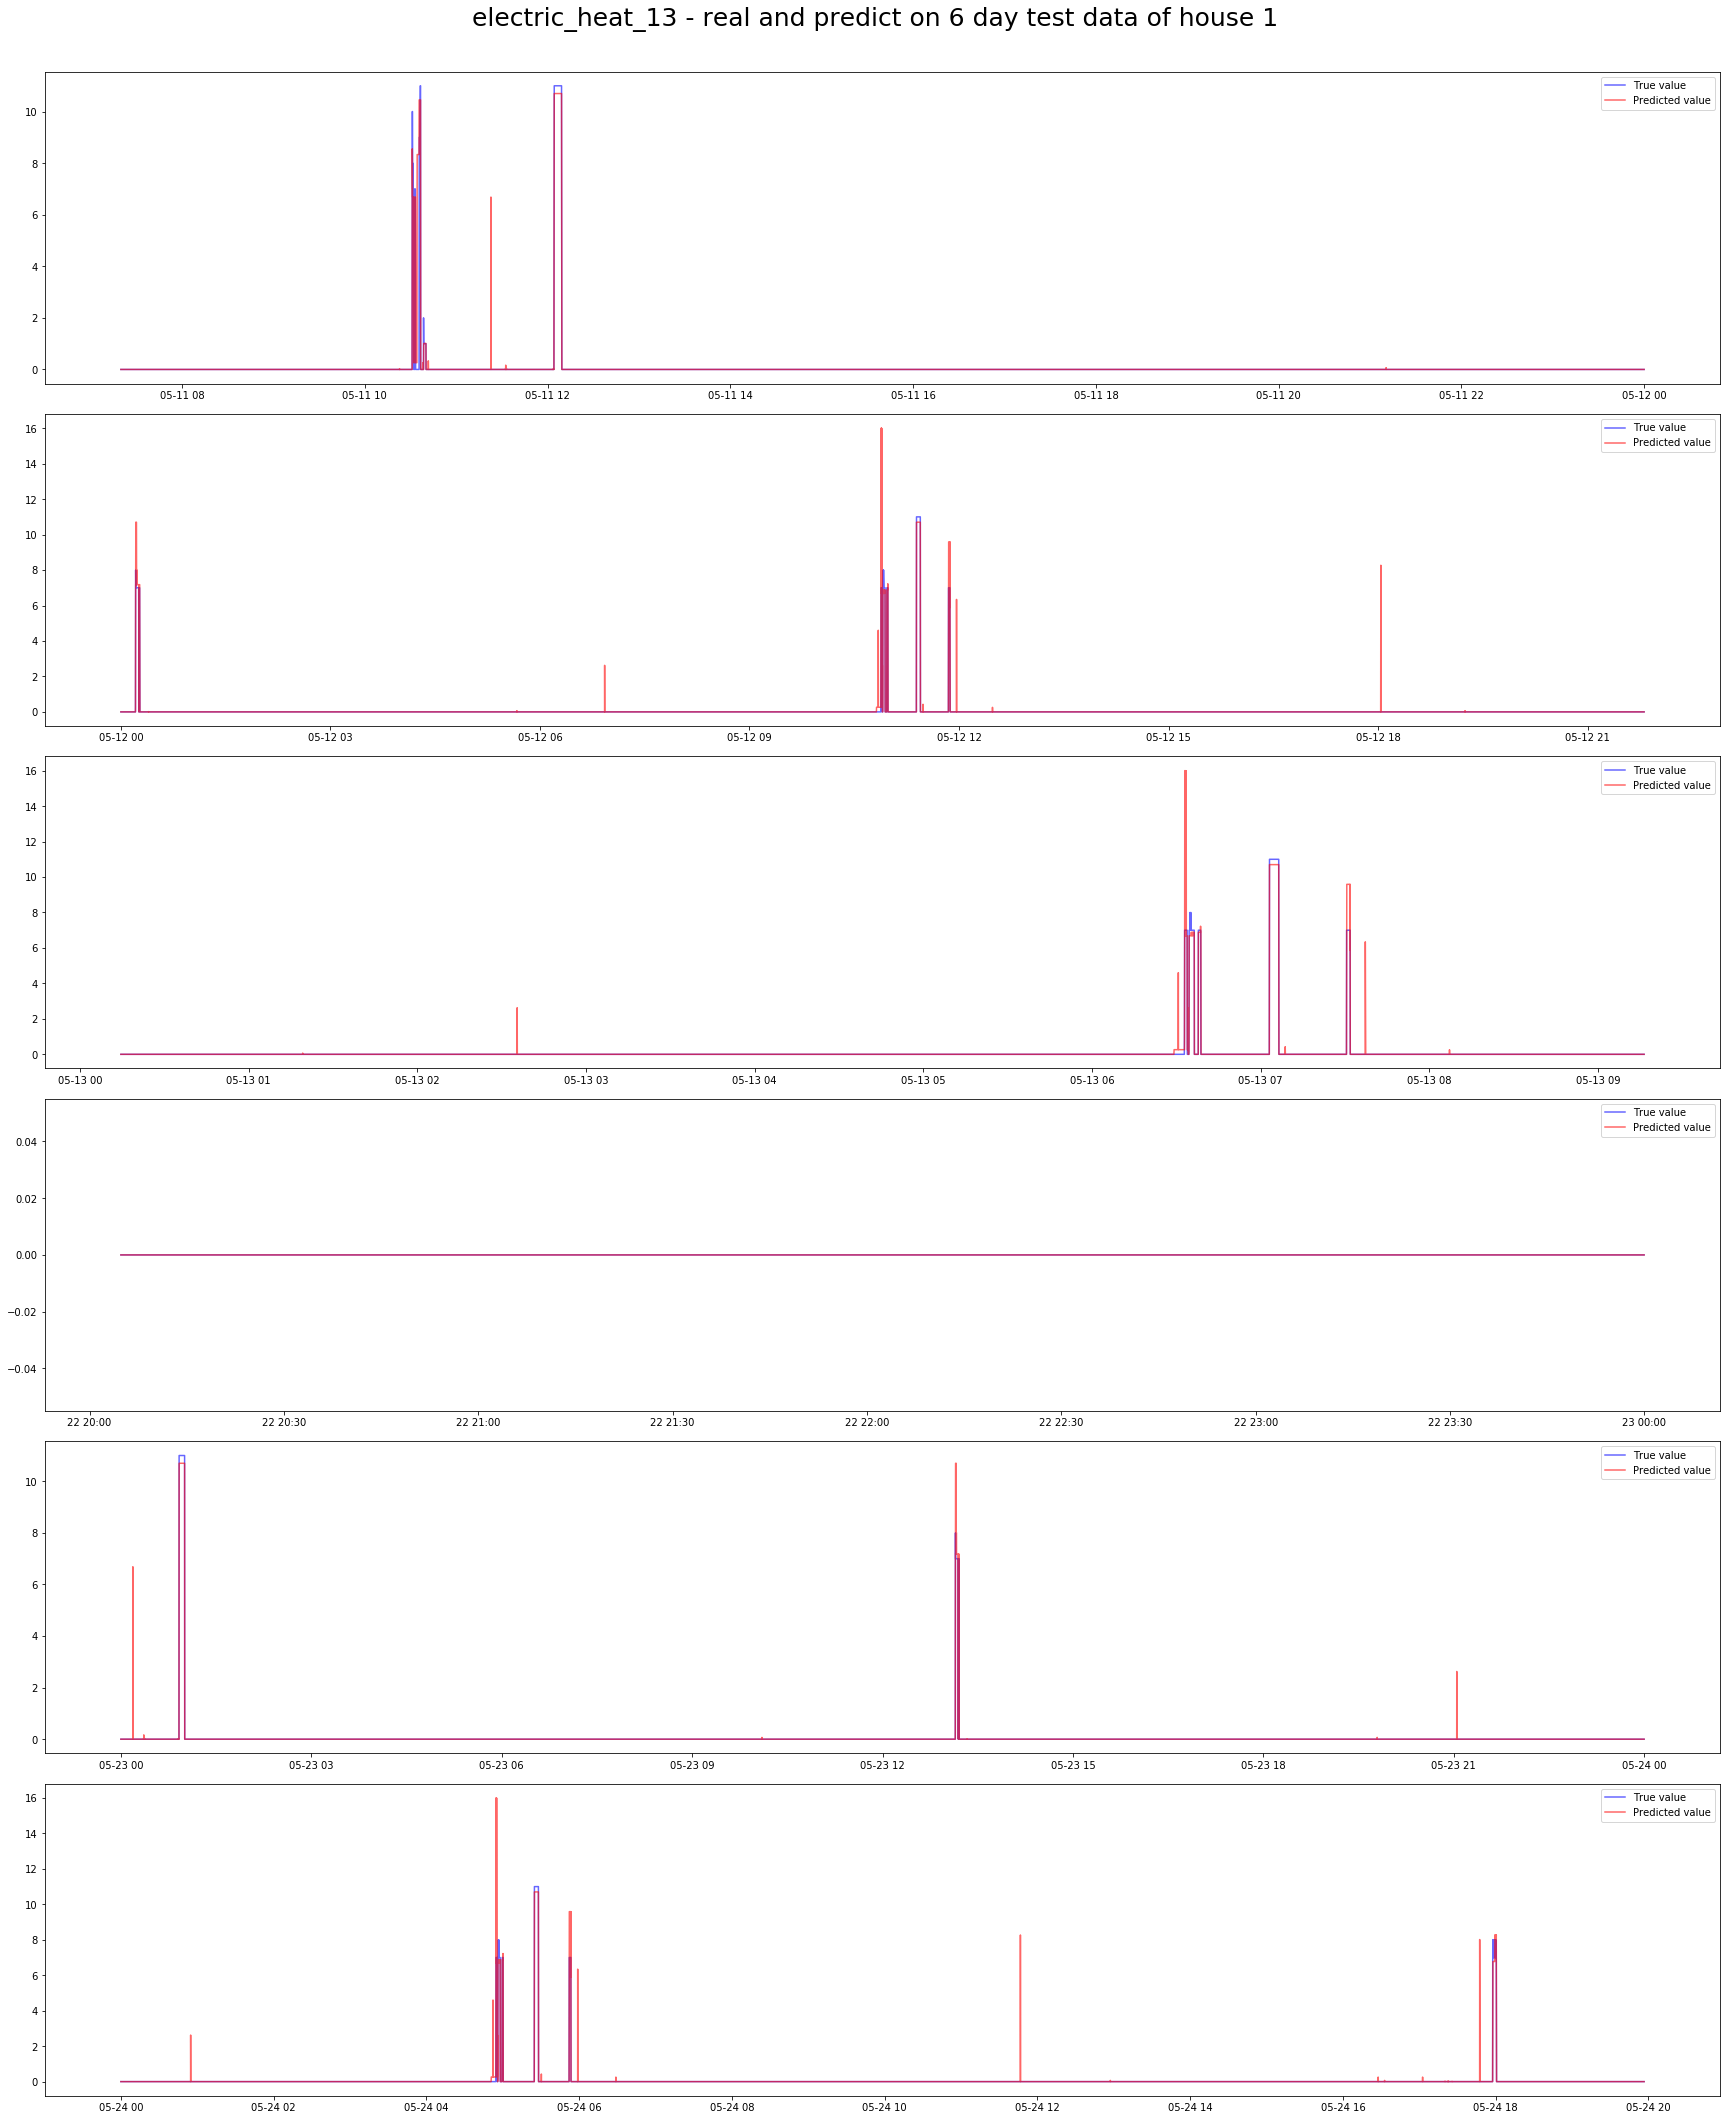

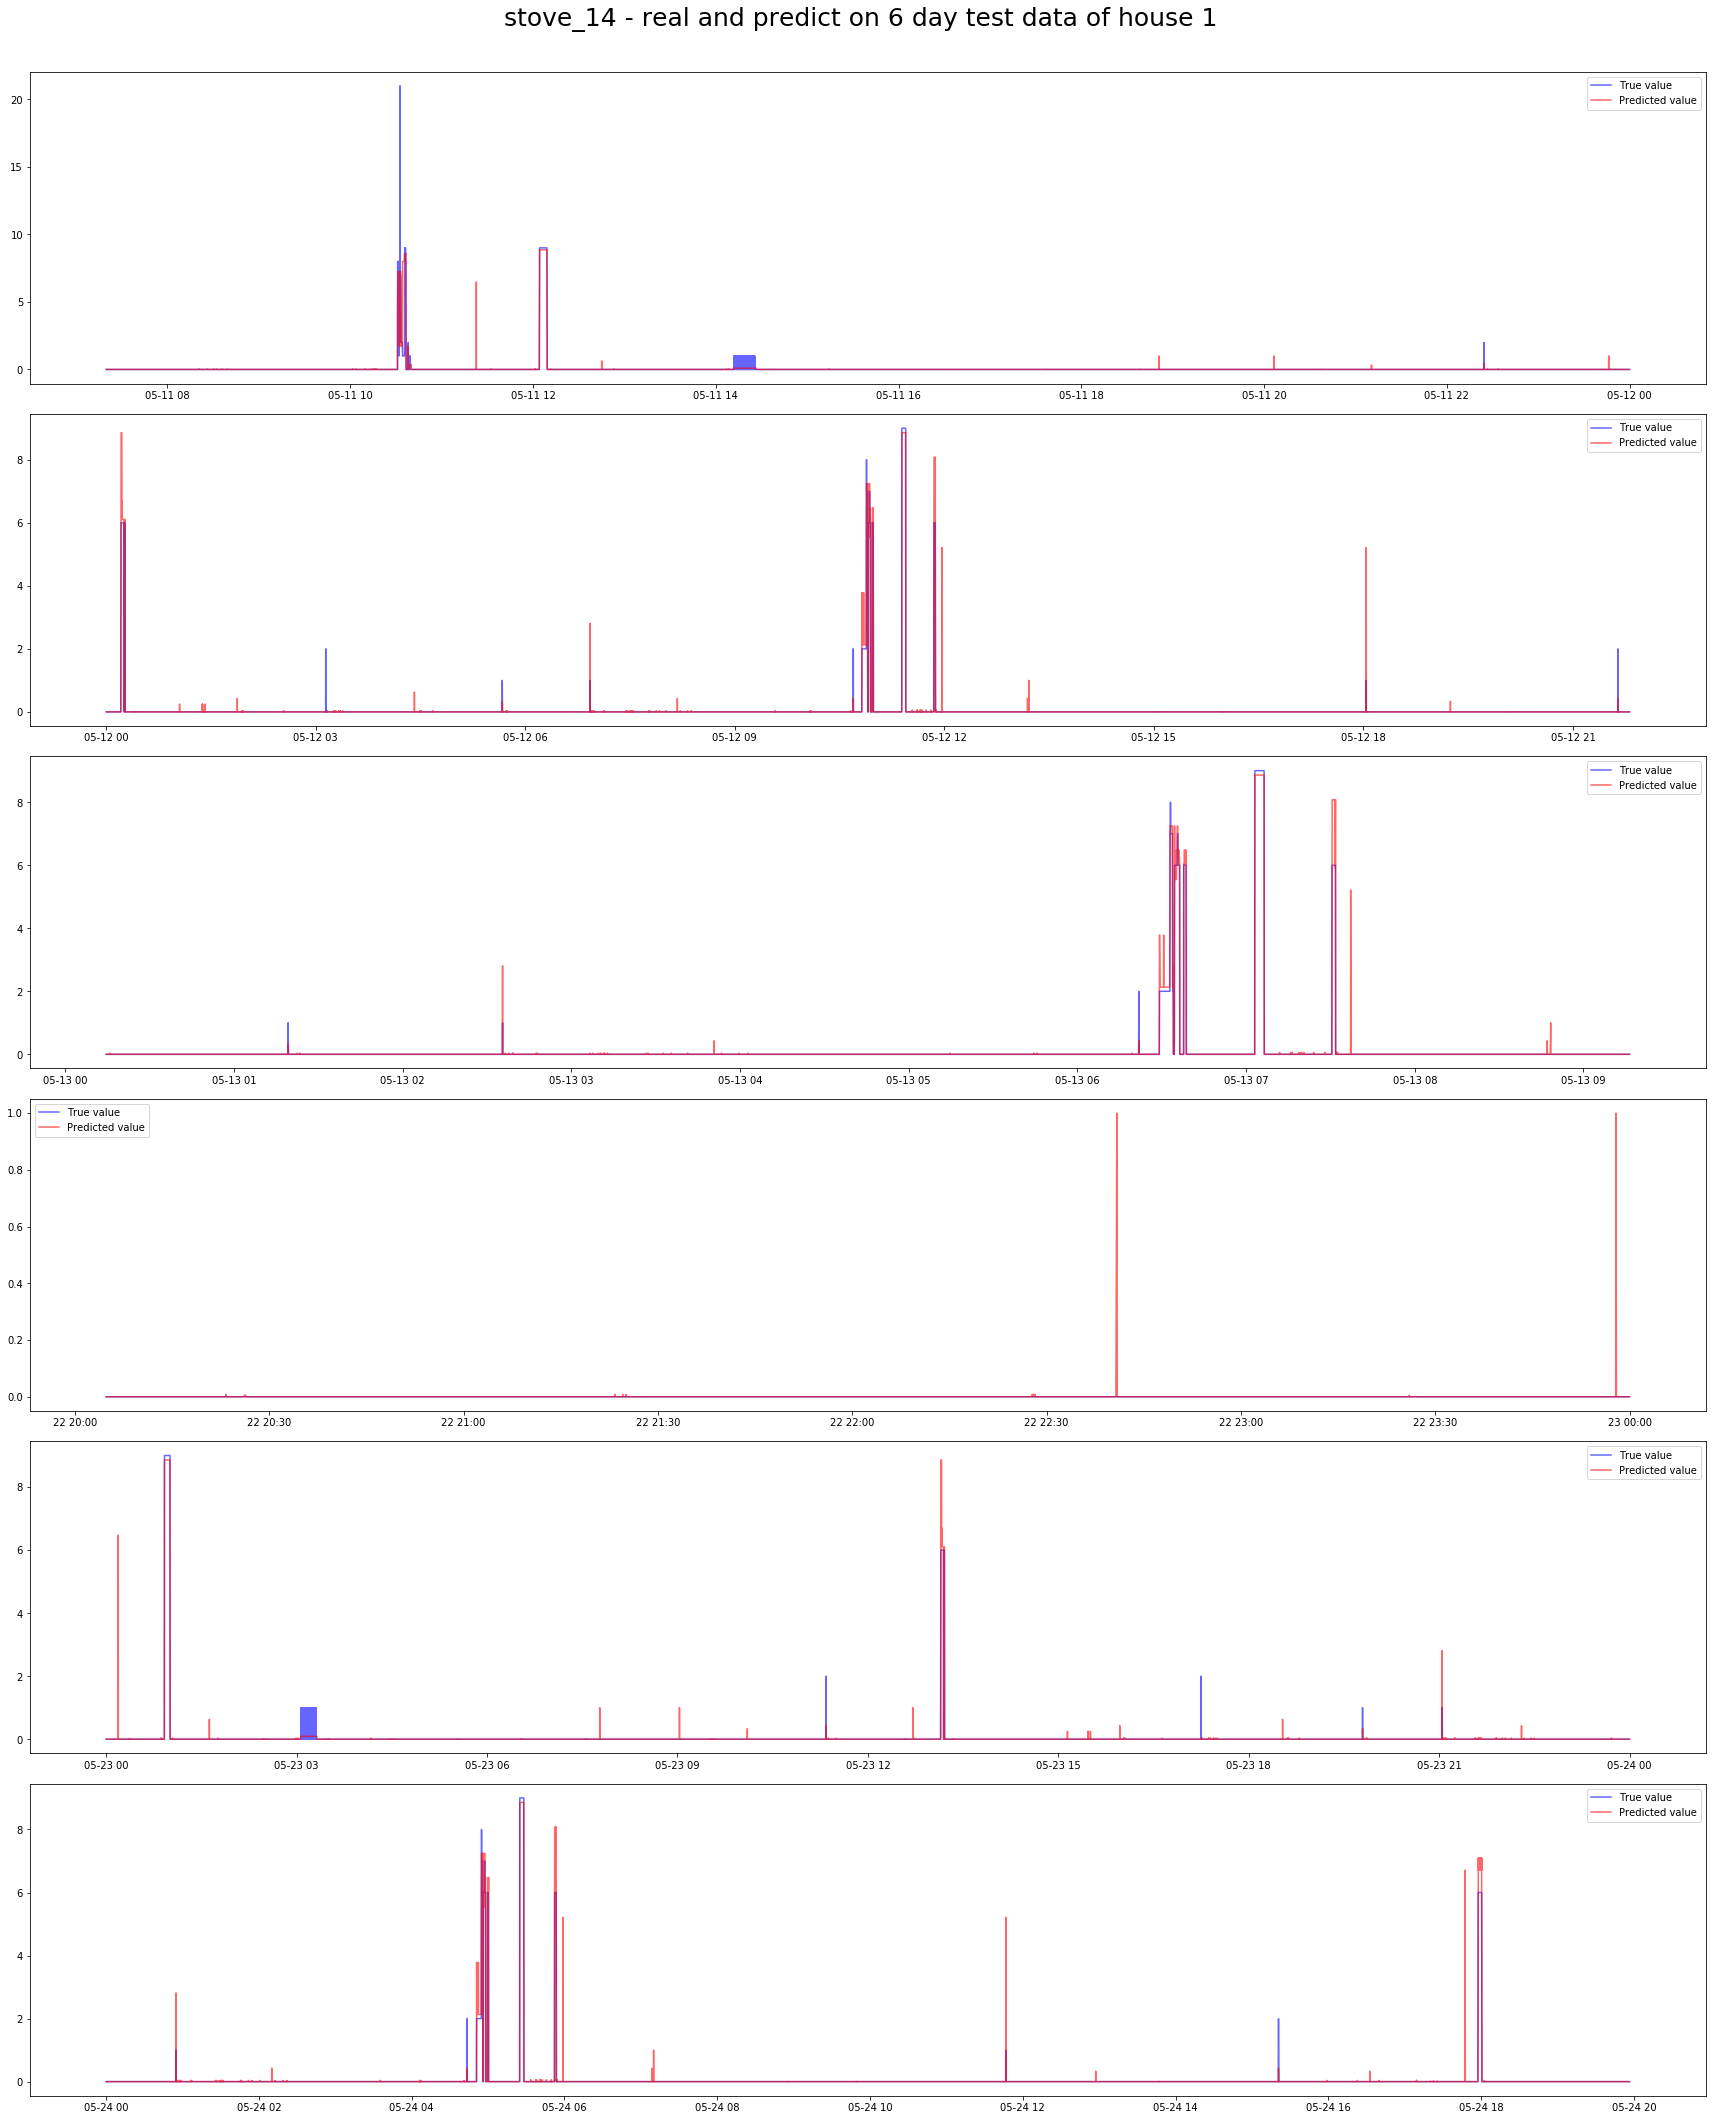

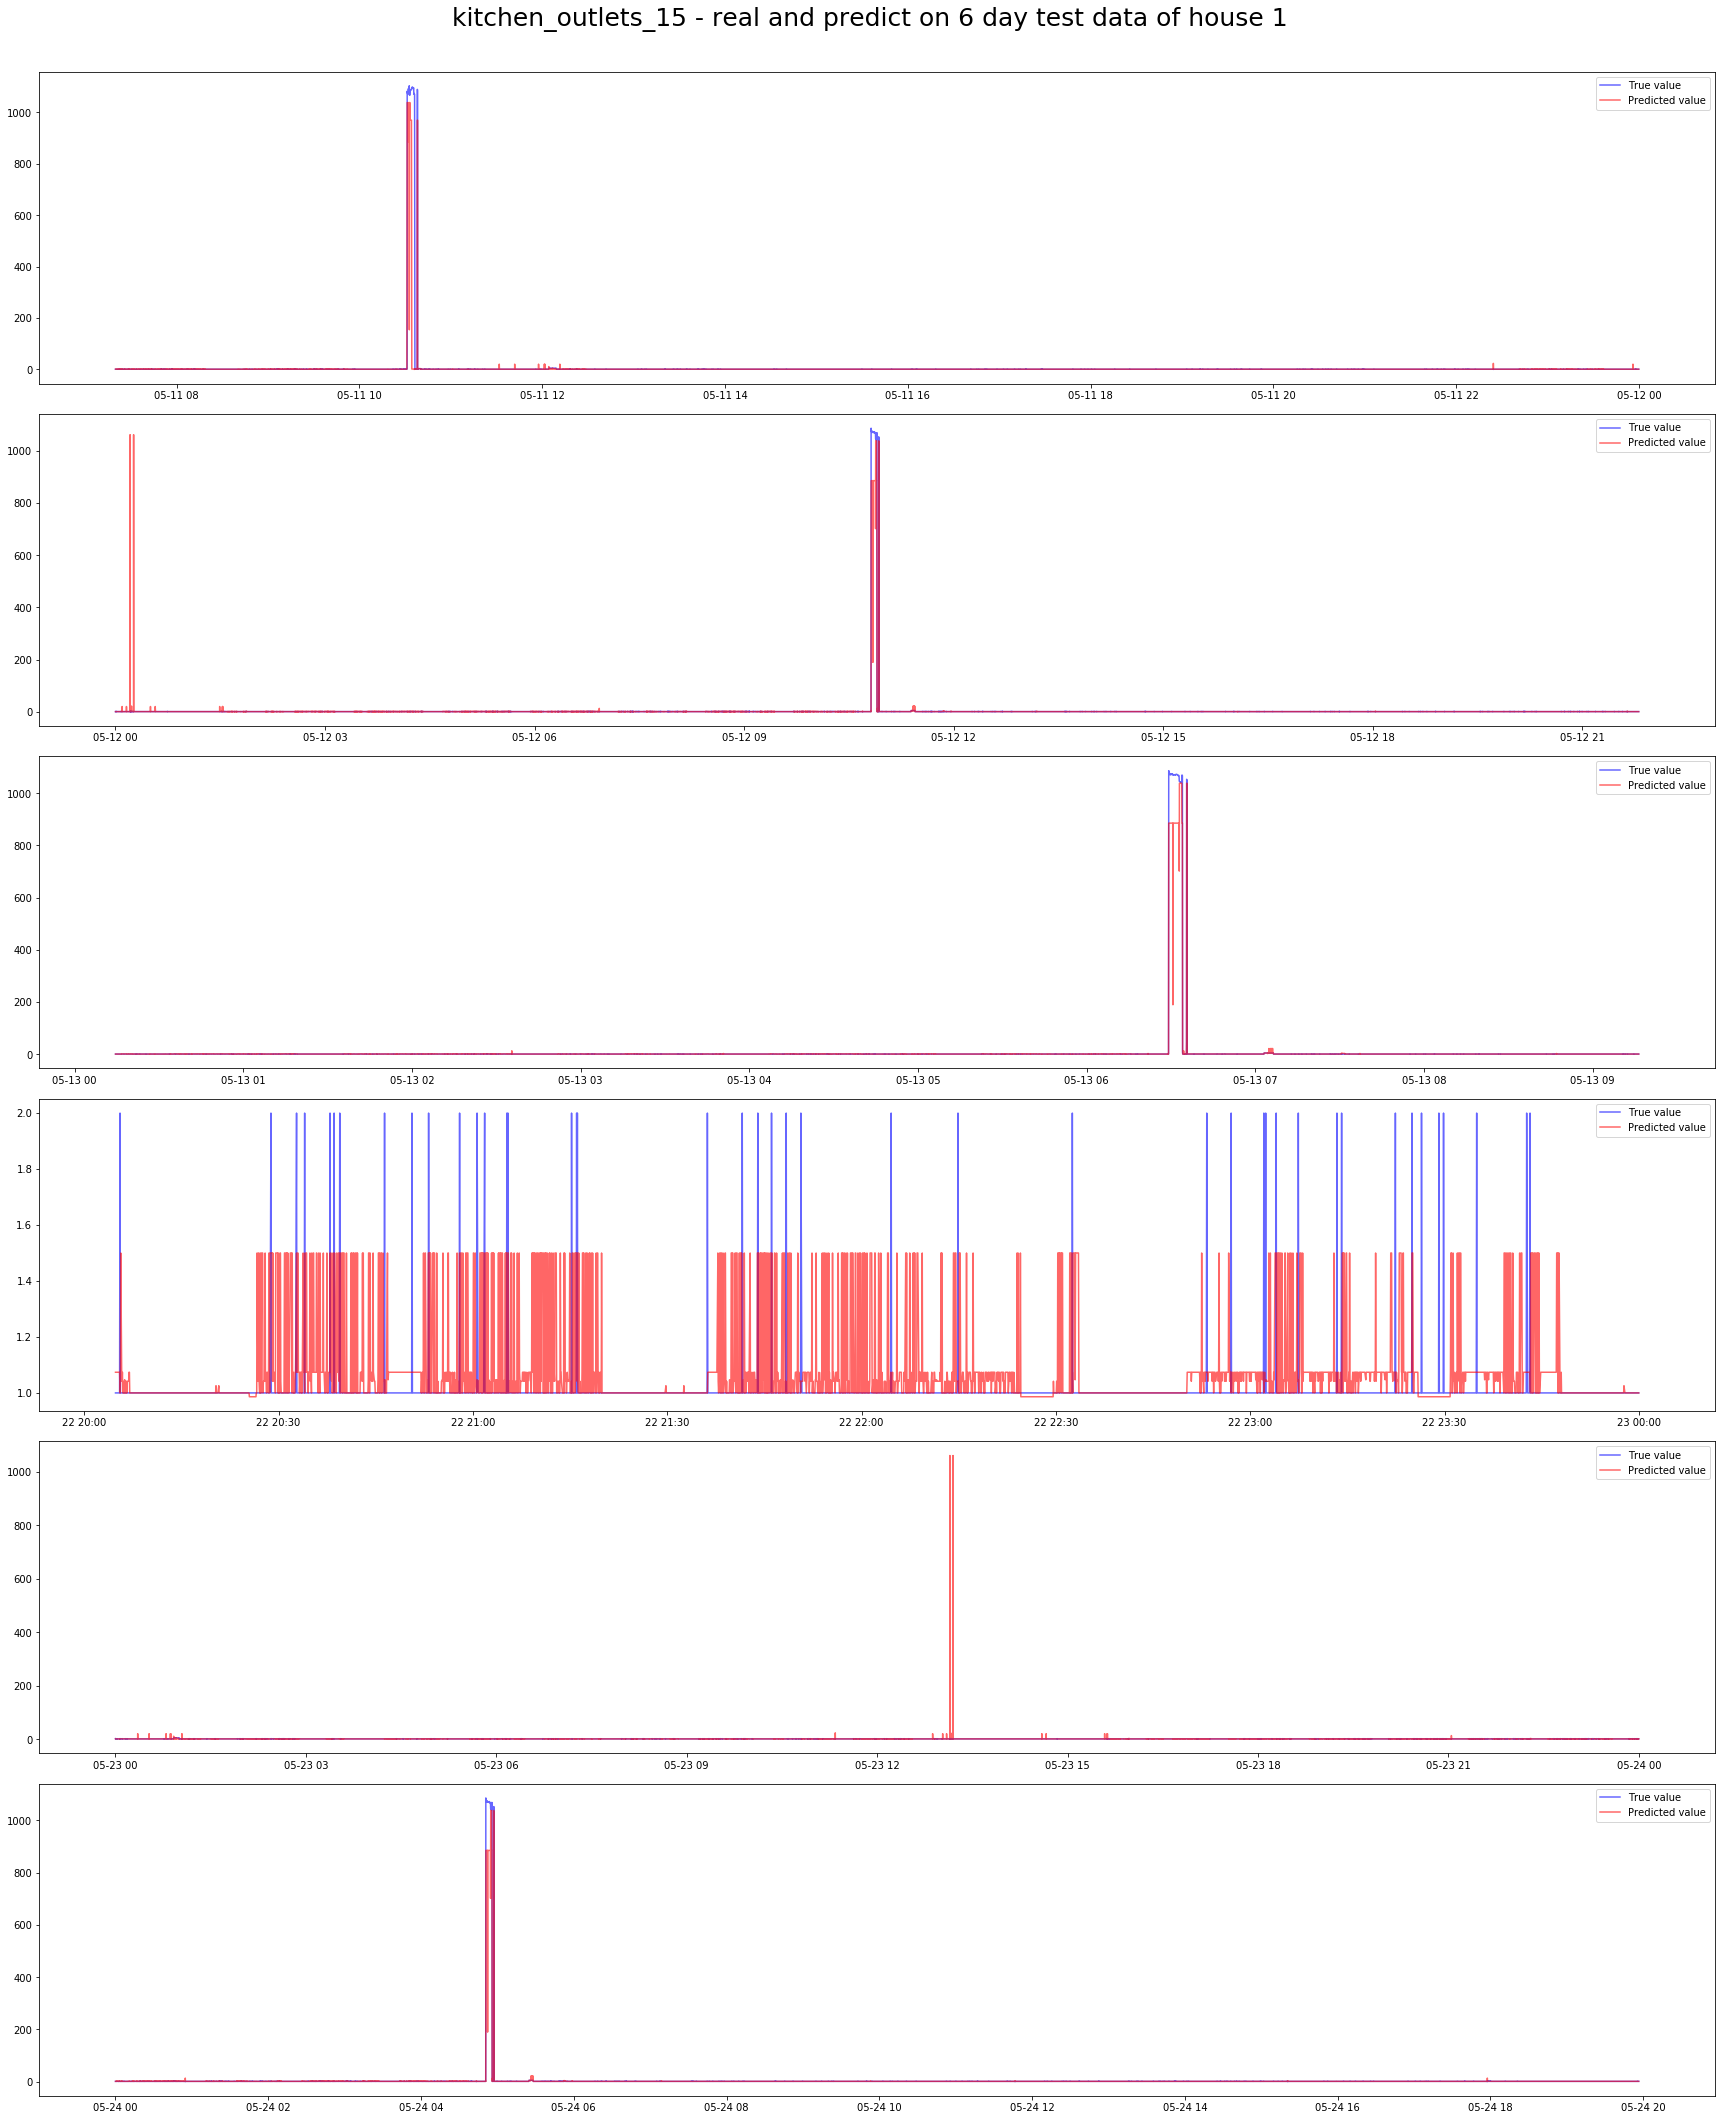

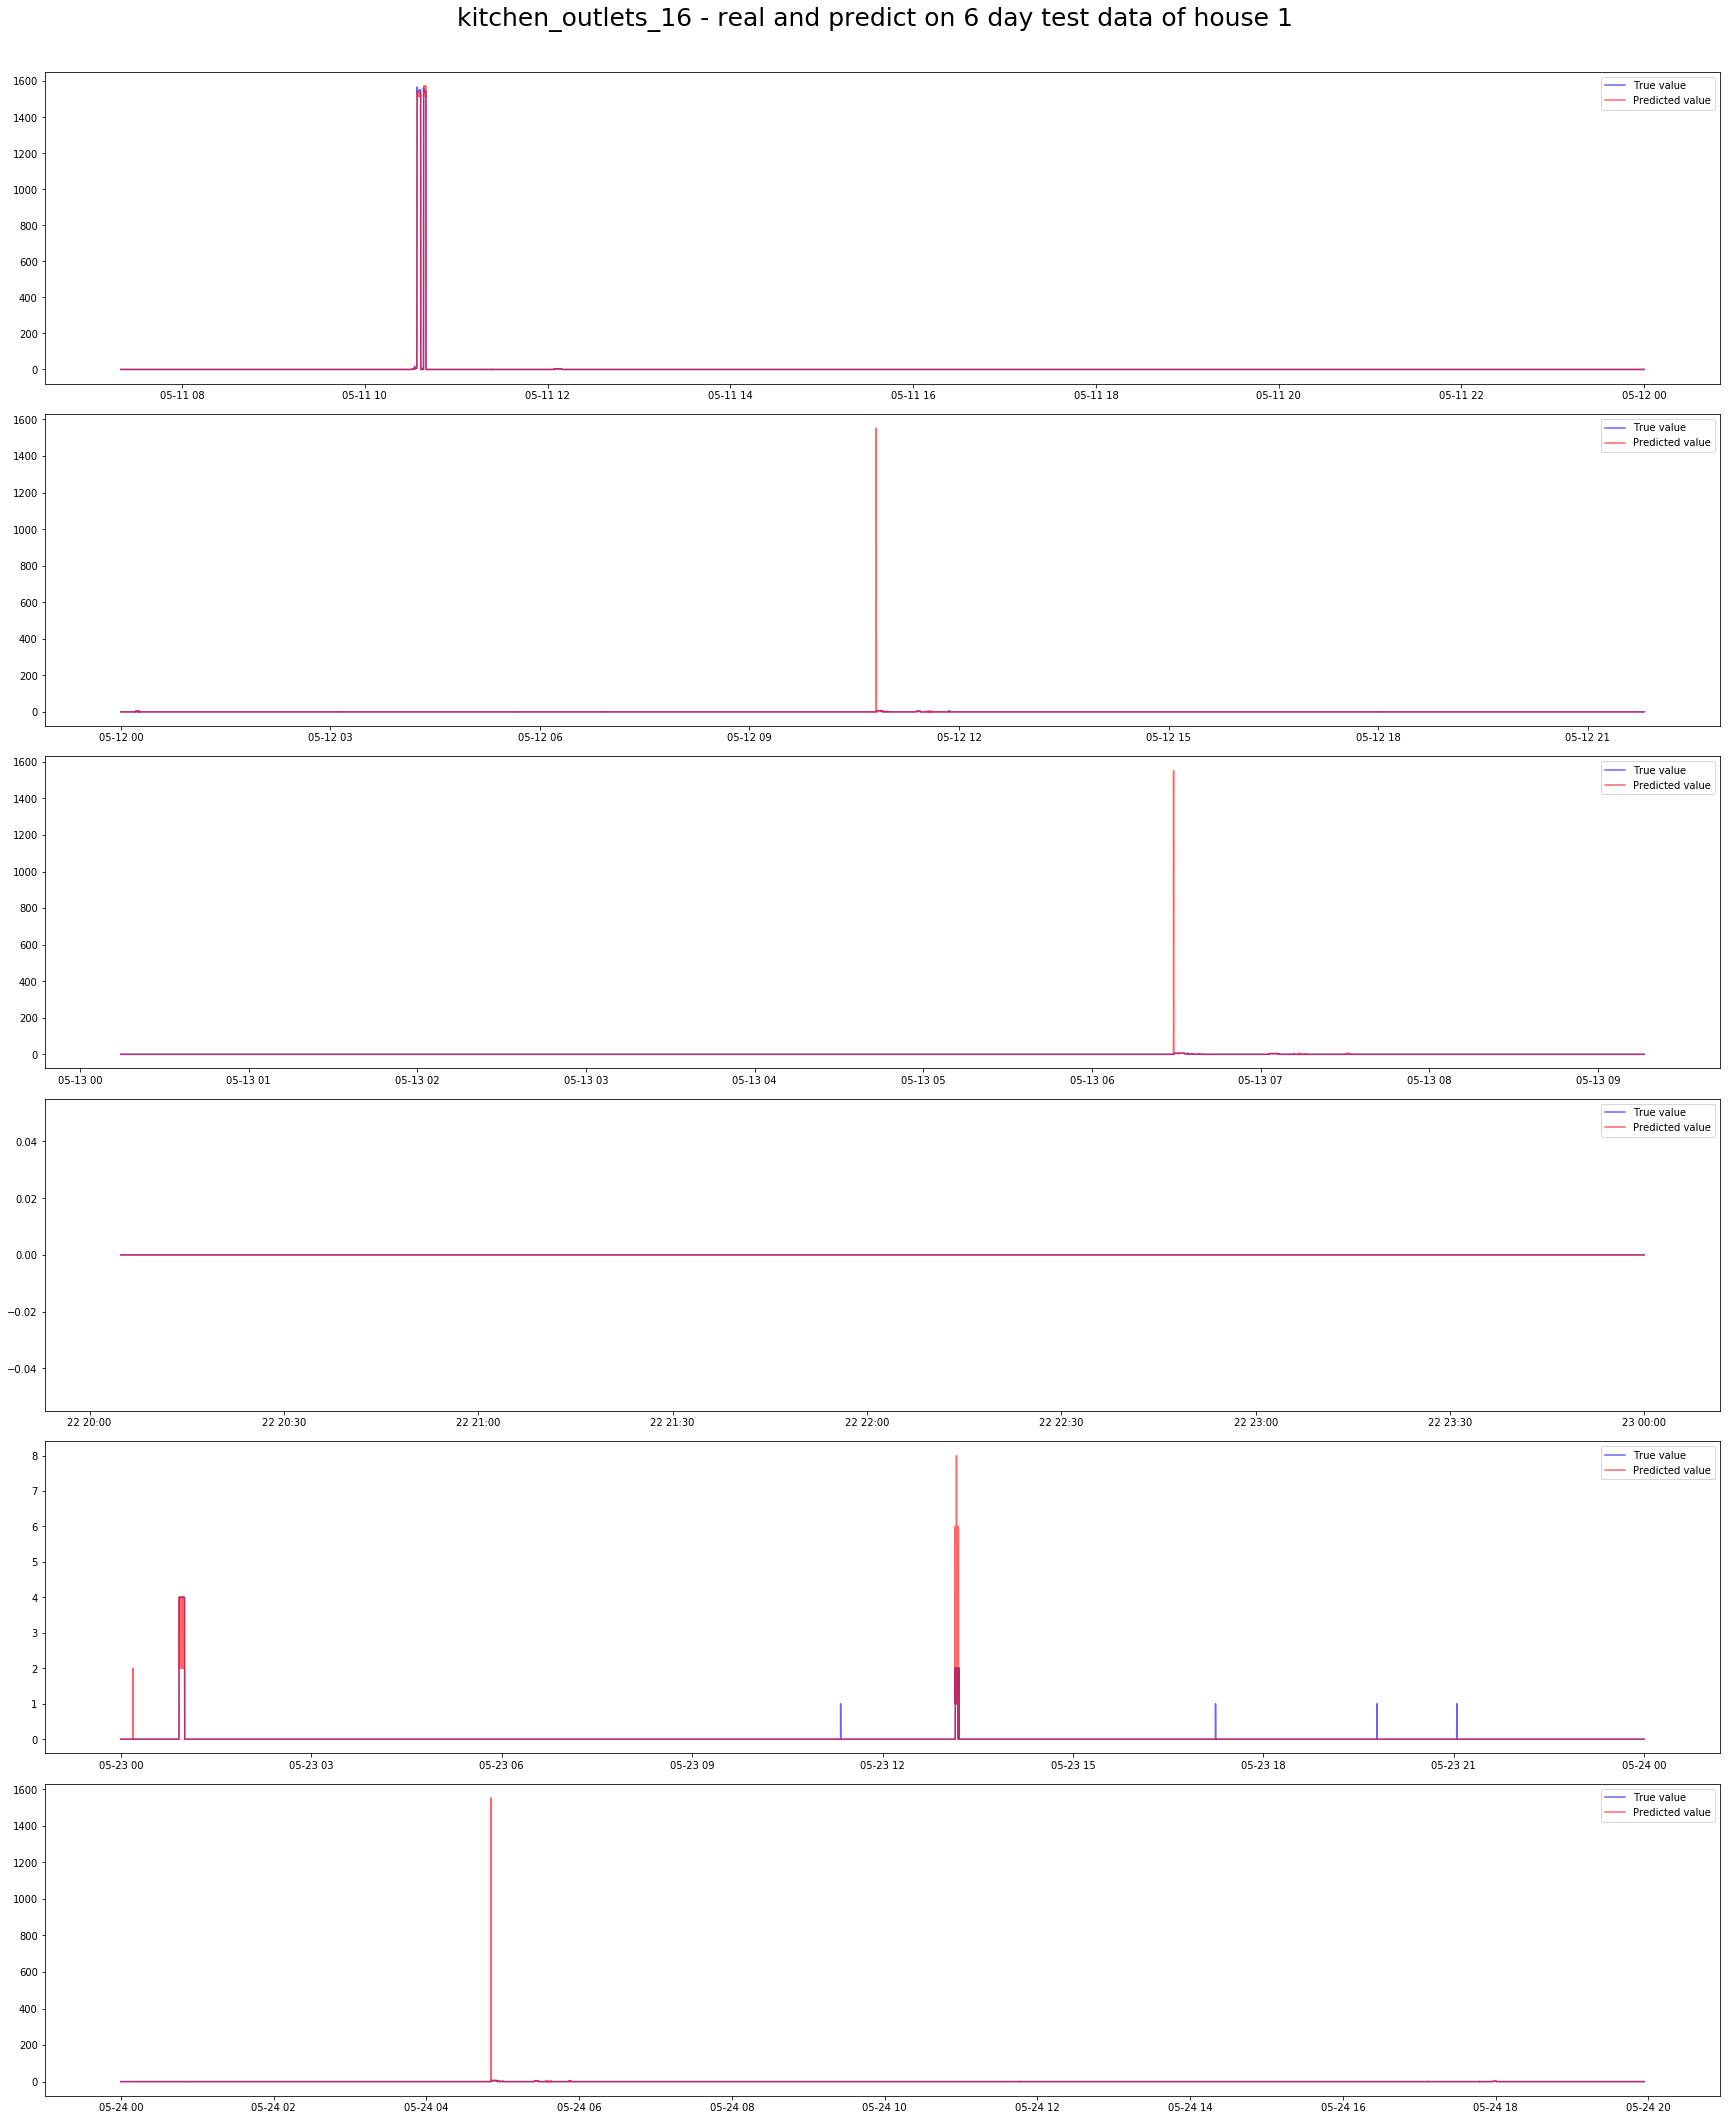

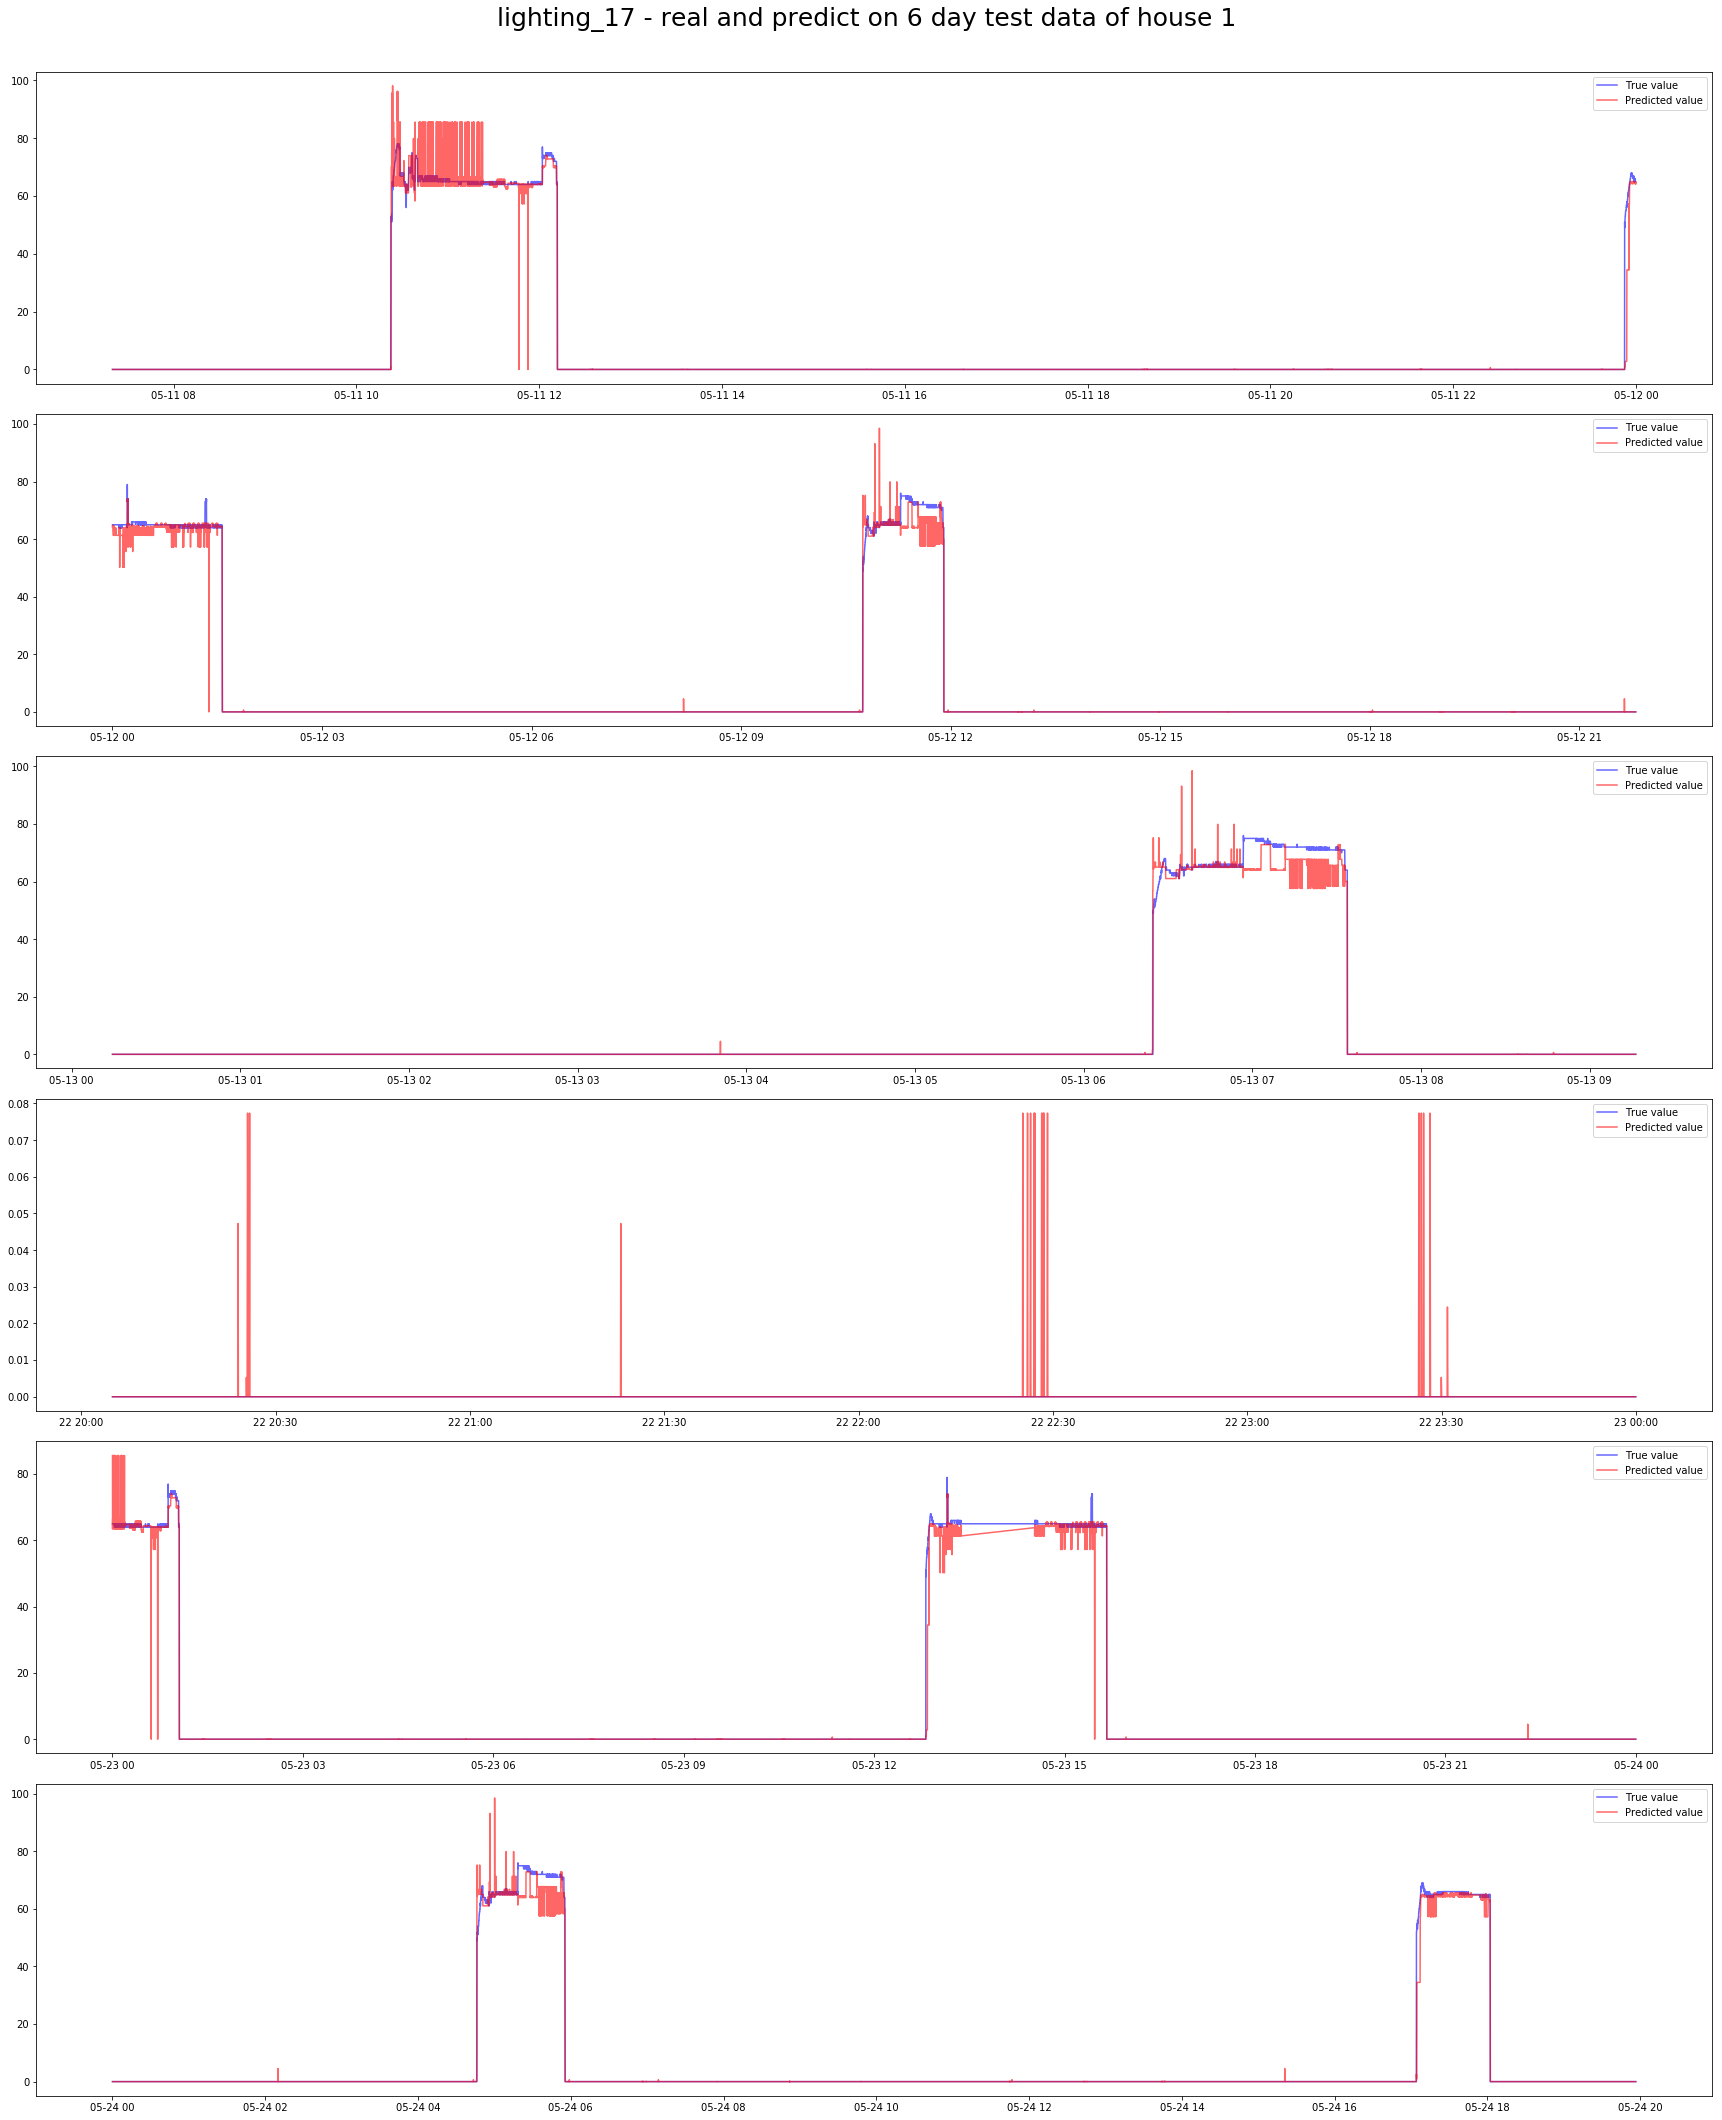

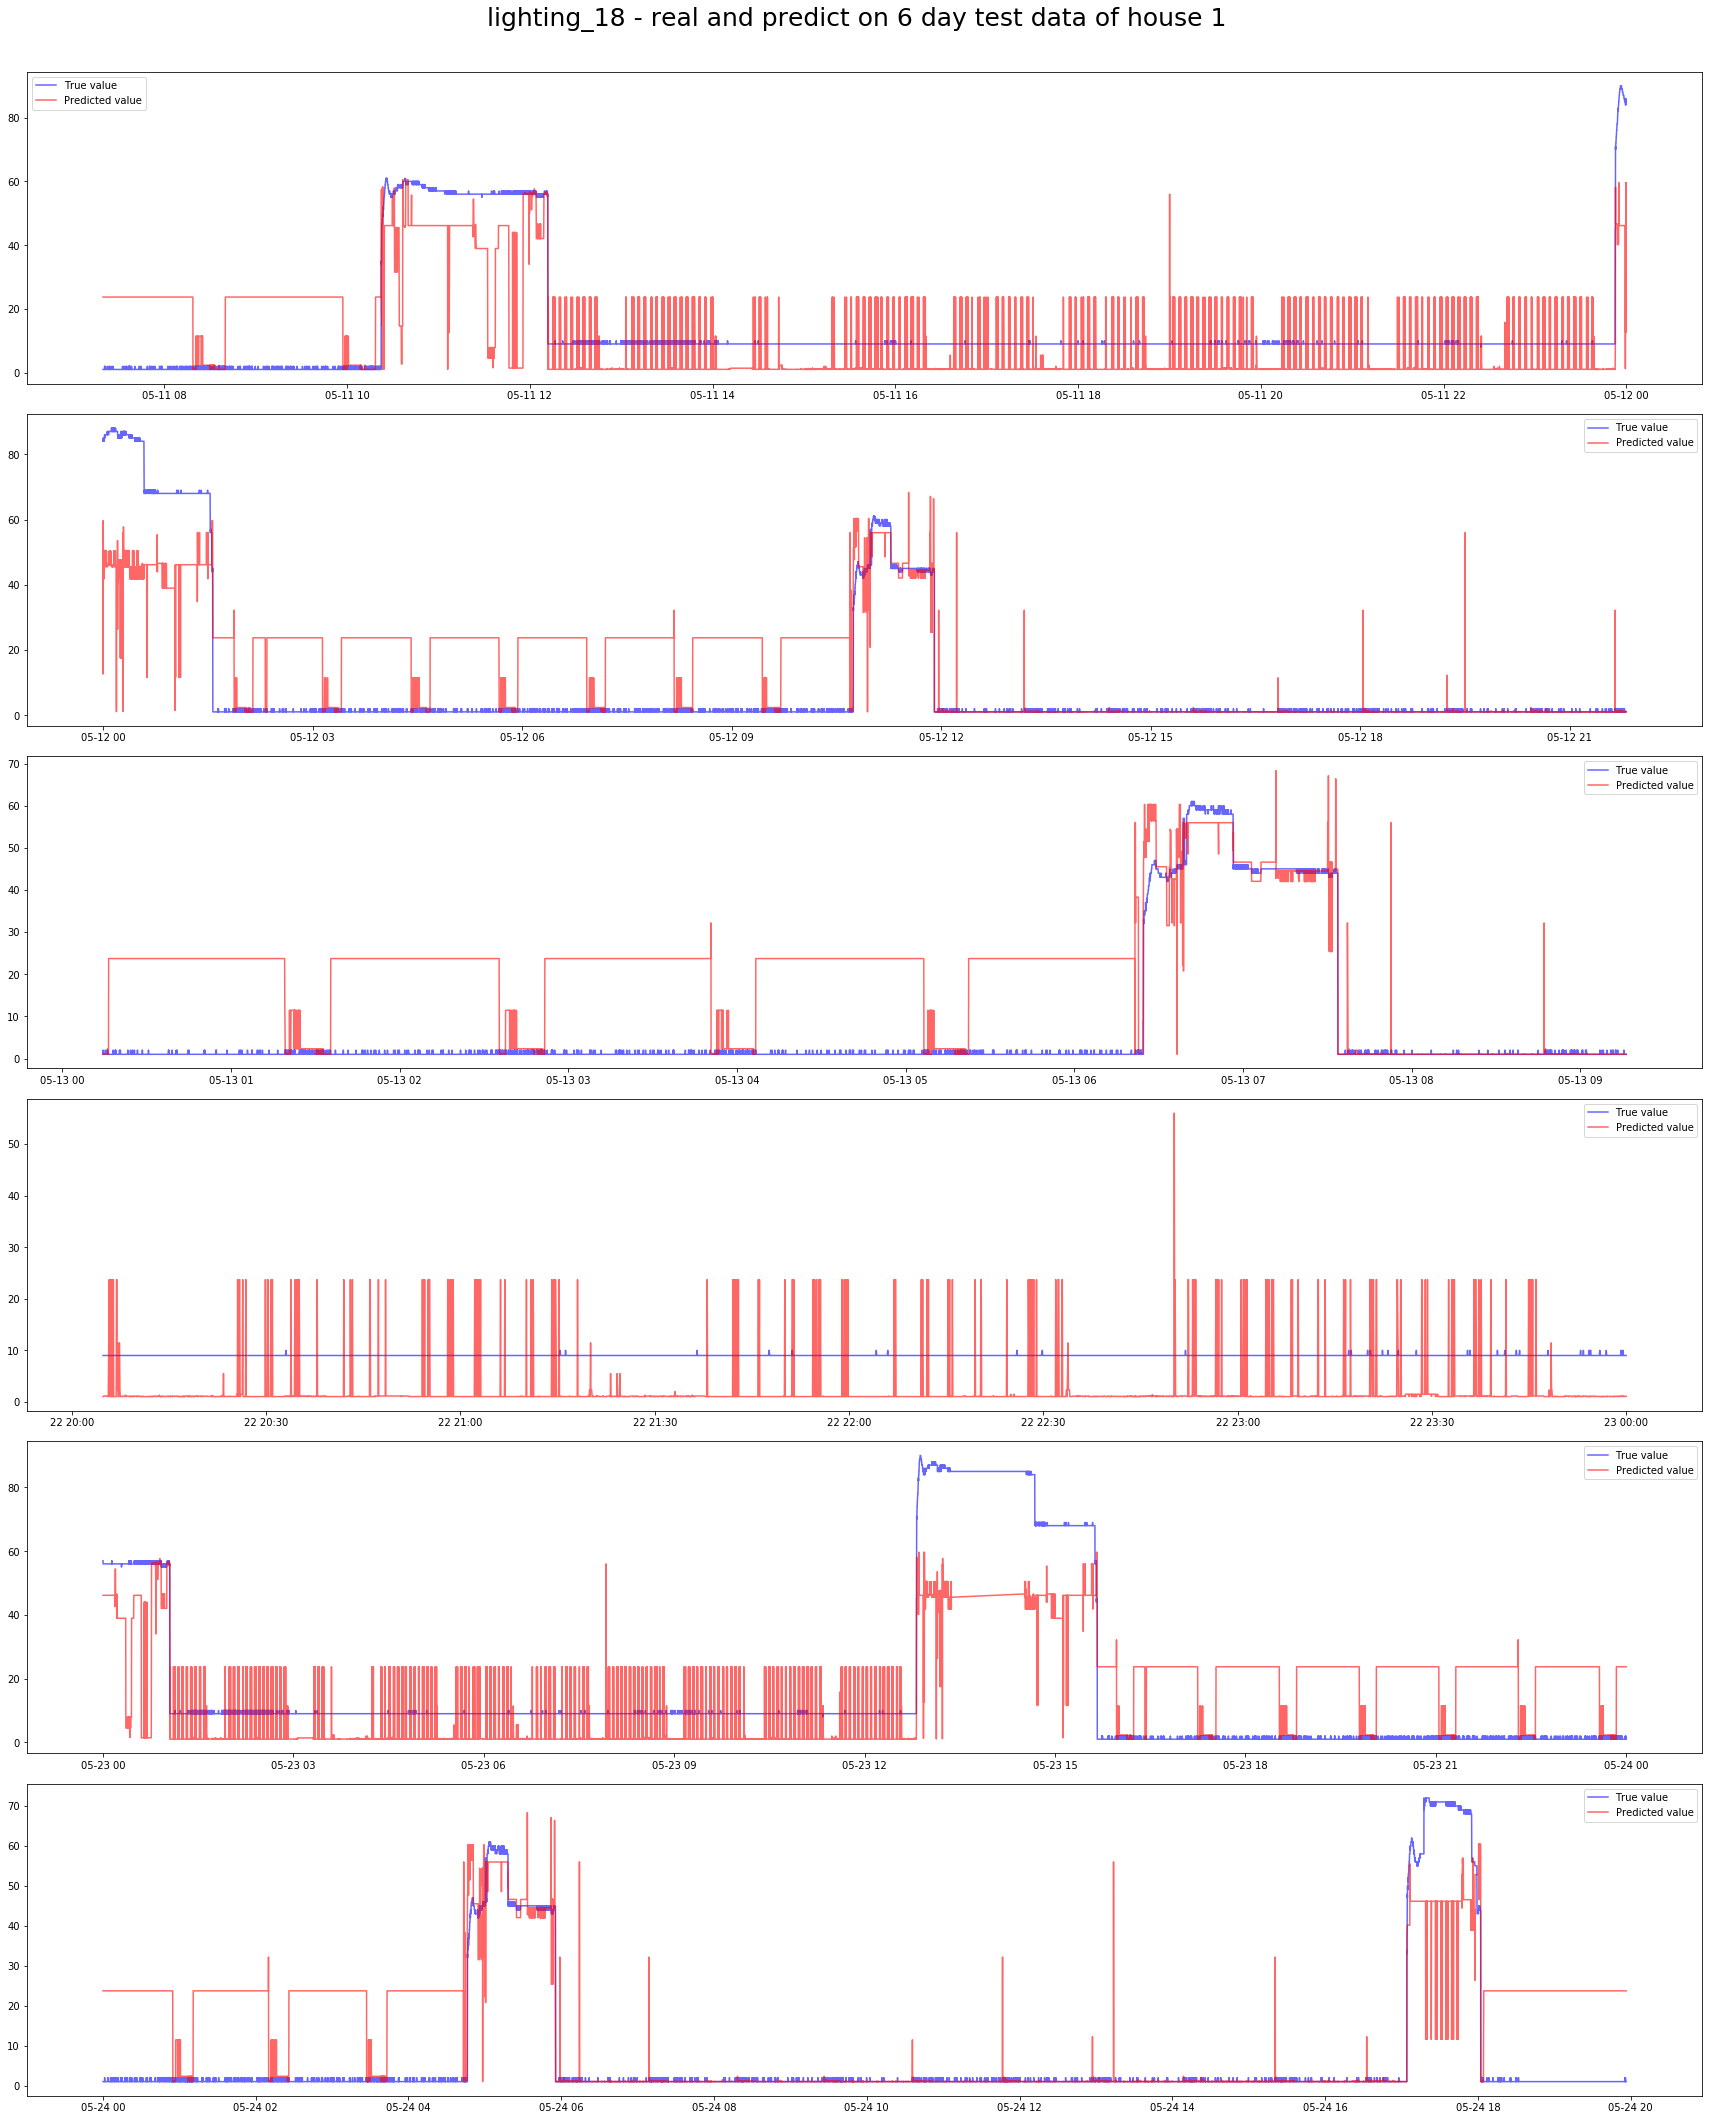

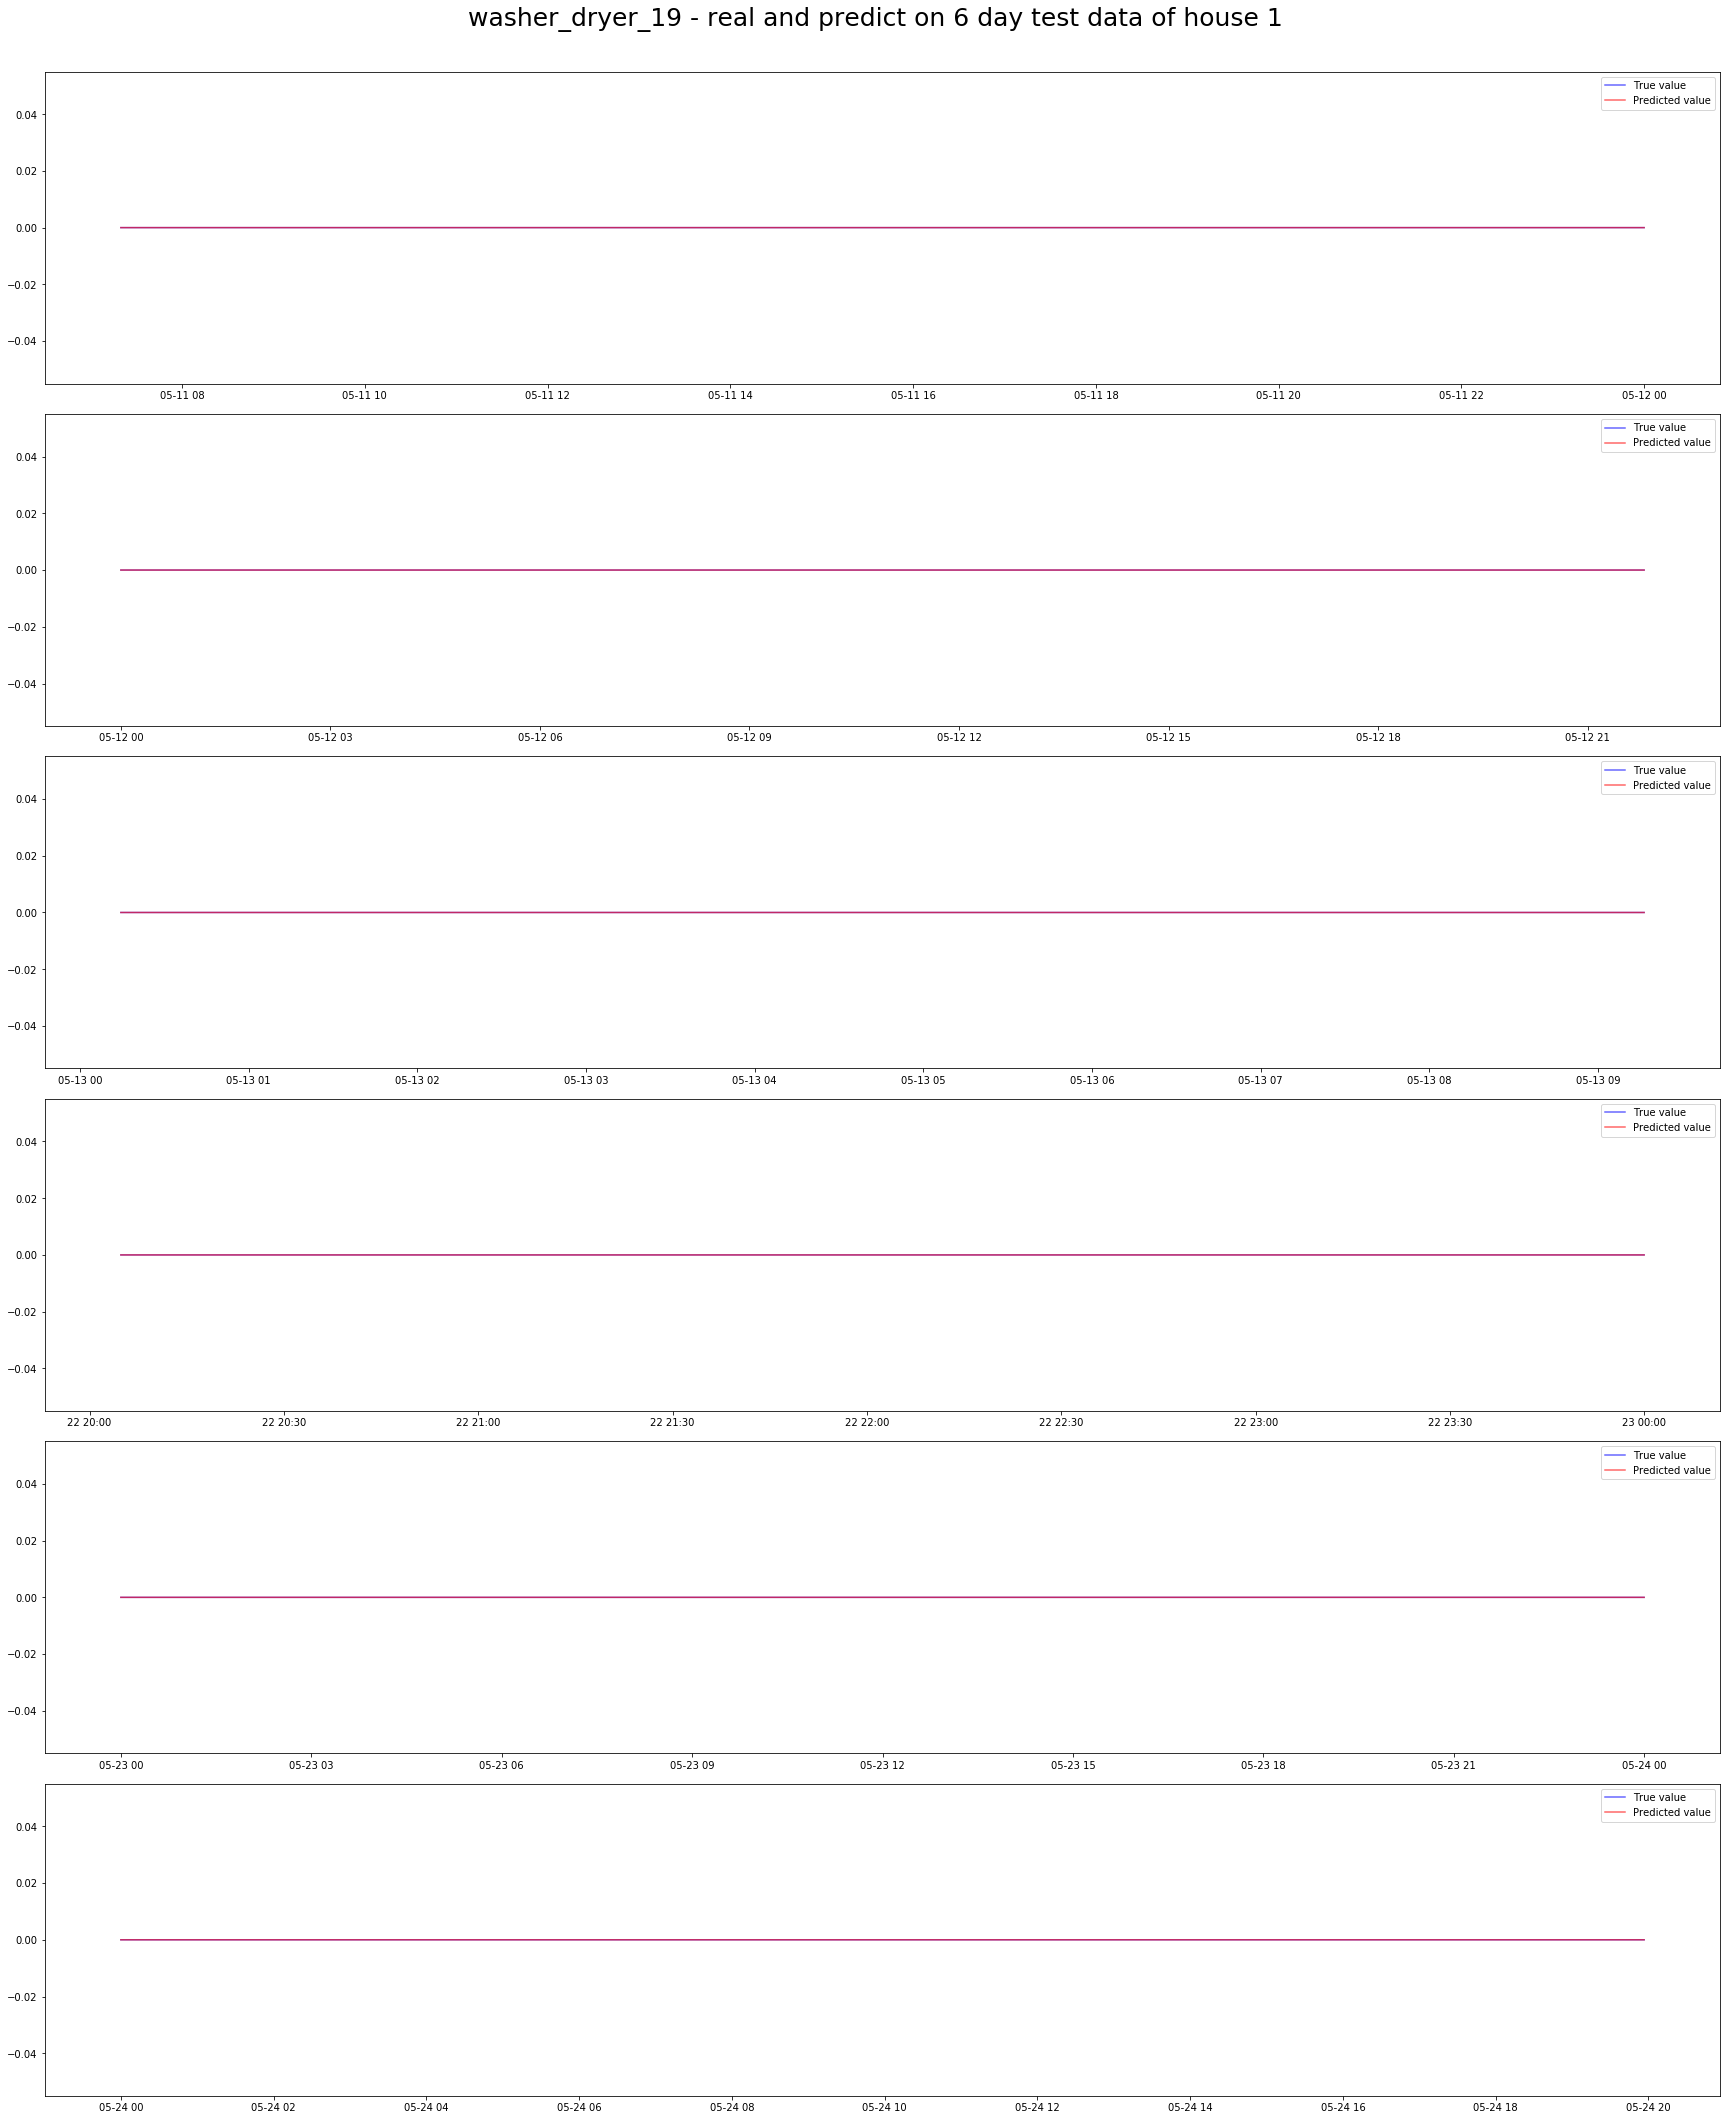

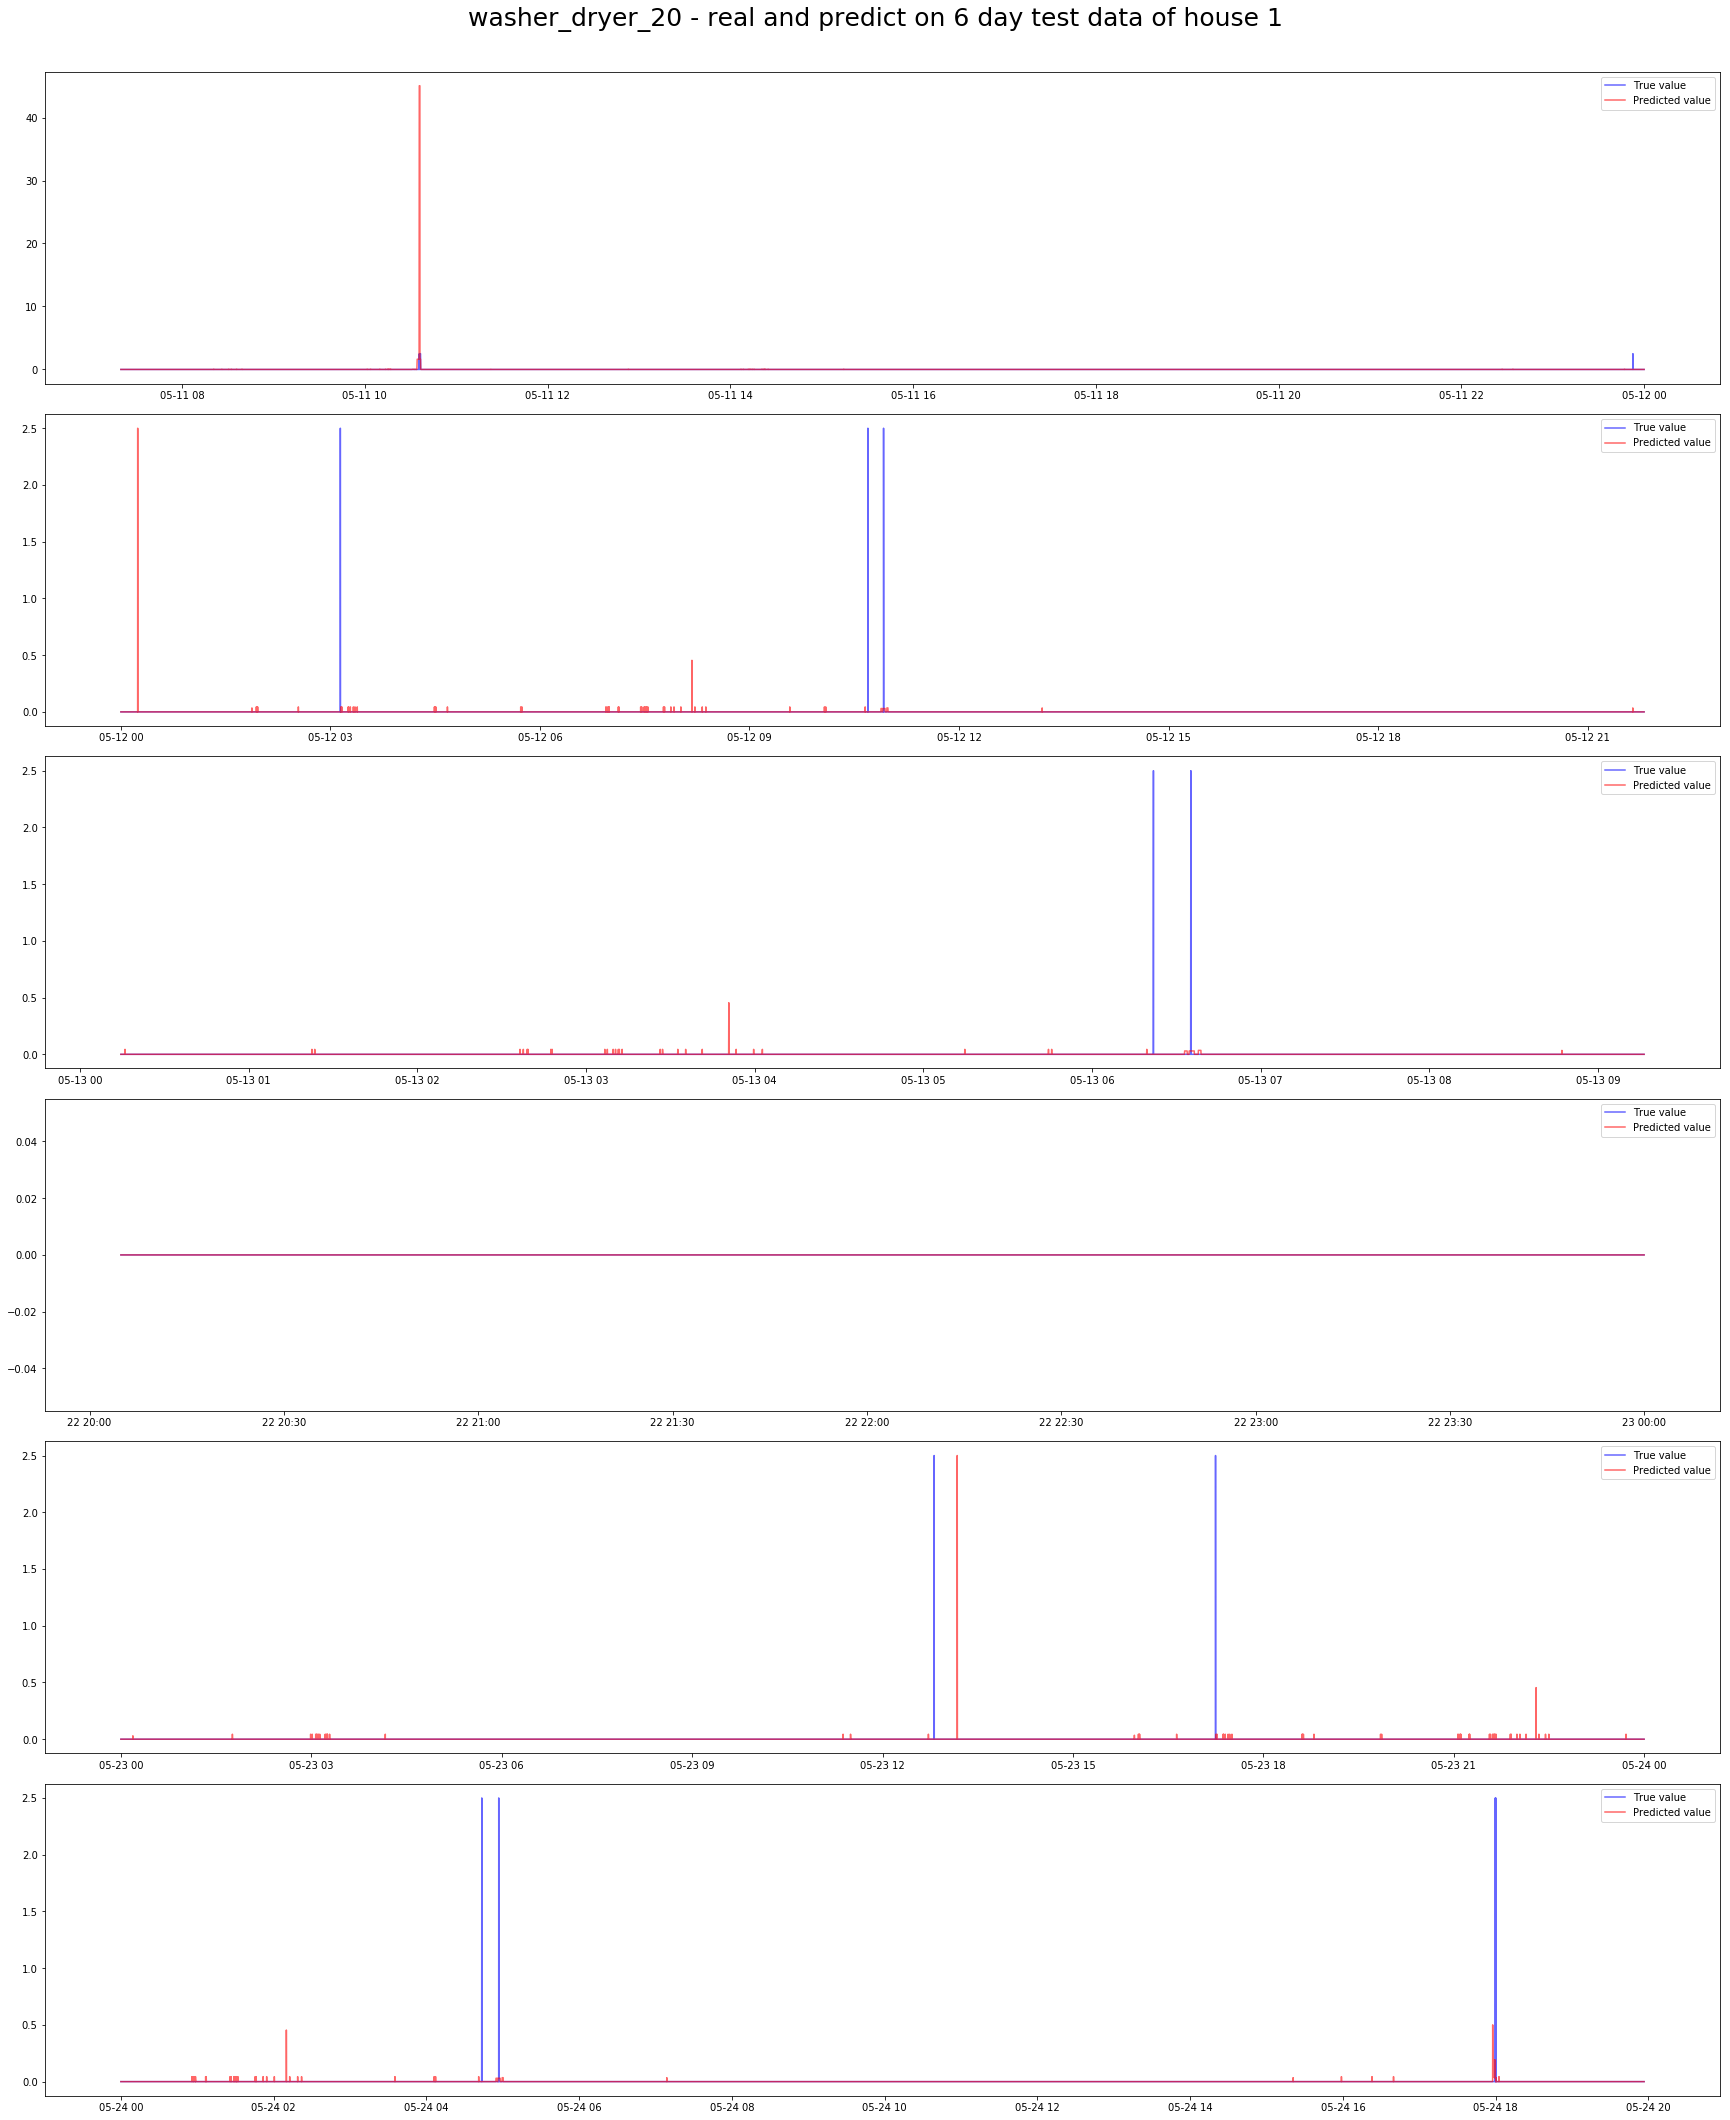

In [28]:
for app in appliances:
    plot_each_app(df1_test, dates[1][17:], mul_pred[app], df1_test[app].values, 
                  '{} - real and predict on 6 day test data of house 1'.format(app))



#Now, let's try fully connected neural network
#### For faster implementation, we use keras API with TensorFlow backend 

In [29]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [33]:
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(input_dim=layers[i], output_dim= layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_______________________

In [34]:
adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=512, verbose=1, nb_epoch=200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)





Train on 143926 samples, validate on 70890 samples
Epoch 1/200





143926/143926 [==============================] - 30s 209us/step - loss: 13331.2245 - val_loss: 9450.7631
Epoch 2/200
143926/143926 [==============================] - 2s 13us/step - loss: 12421.9318 - val_loss: 9393.0782
Epoch 3/200
143926/143926 [==============================] - 2s 13us/step - loss: 11926.5017 - val_loss: 9363.0558
Epoch 4/200
143926/143926 [==============================] - 2s 13us/step - loss: 11601.4934 - val_loss: 9325.6334
Epoch 5/200
143926/143926 [==============================] - 2s 13us/step - loss: 11307.9178 - val_loss: 9406.4829
Epoch 6/200
143926/143926 [==============================] - 2s 13us/step - loss: 11083.7528 - val_loss: 9366.8953
Epoch 7/200
143926/143926 [==============================] - 2s 13us/step - loss: 10934.8813 - val_loss: 9460.7484
Epoch 8/200
143926/143926 [==============================] - 2s 12us/step - loss: 10766.3691 - val_loss: 9461.3425
Epoch 9/200
143926

Epoch 54/200
143926/143926 [==============================] - 2s 13us/step - loss: 9210.2523 - val_loss: 9910.4222
Epoch 55/200
143926/143926 [==============================] - 2s 13us/step - loss: 9155.5940 - val_loss: 9920.6286
Epoch 56/200
143926/143926 [==============================] - 2s 13us/step - loss: 9150.2142 - val_loss: 9910.1914
Epoch 57/200
143926/143926 [==============================] - 2s 13us/step - loss: 9195.8154 - val_loss: 9949.4987
Epoch 58/200
143926/143926 [==============================] - 2s 13us/step - loss: 9120.6559 - val_loss: 9913.1429
Epoch 59/200
143926/143926 [==============================] - 2s 13us/step - loss: 9093.1676 - val_loss: 9872.2208
Epoch 60/200
143926/143926 [==============================] - 2s 13us/step - loss: 9116.2533 - val_loss: 9833.8762
Epoch 61/200
143926/143926 [==============================] - 2s 13us/step - loss: 9125.2944 - val_loss: 9877.2104
Epoch 62/200
143926/143926 [==============================] - 2s 13us/step - los

143926/143926 [==============================] - 2s 13us/step - loss: 8648.1738 - val_loss: 9224.8770
Epoch 126/200
143926/143926 [==============================] - 2s 13us/step - loss: 8631.6832 - val_loss: 9166.3537
Epoch 127/200
143926/143926 [==============================] - 2s 13us/step - loss: 8669.6371 - val_loss: 9204.7221
Epoch 128/200
143926/143926 [==============================] - 2s 13us/step - loss: 8651.7429 - val_loss: 9206.9141
Epoch 129/200
143926/143926 [==============================] - 2s 13us/step - loss: 8638.3891 - val_loss: 9179.4324
Epoch 130/200
143926/143926 [==============================] - 2s 13us/step - loss: 8626.4036 - val_loss: 9151.2009
Epoch 131/200
143926/143926 [==============================] - 2s 13us/step - loss: 8586.0185 - val_loss: 9153.1842
Epoch 132/200
143926/143926 [==============================] - 2s 13us/step - loss: 8579.4983 - val_loss: 9129.4110
Epoch 133/200
143926/143926 [==============================] - 2s 13us/step - loss: 86

In [35]:
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)


Mean square error on test set:  9634.55531705157
Mean absolute error on the test set:  51.046614436580455


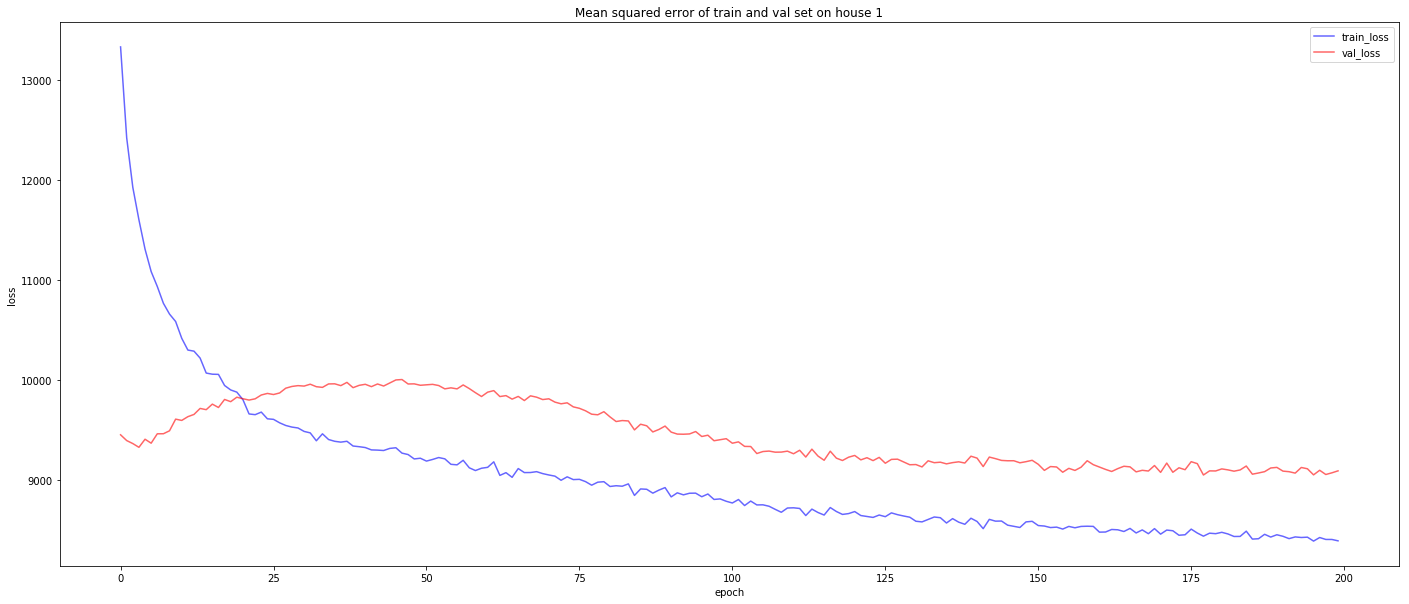

In [36]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

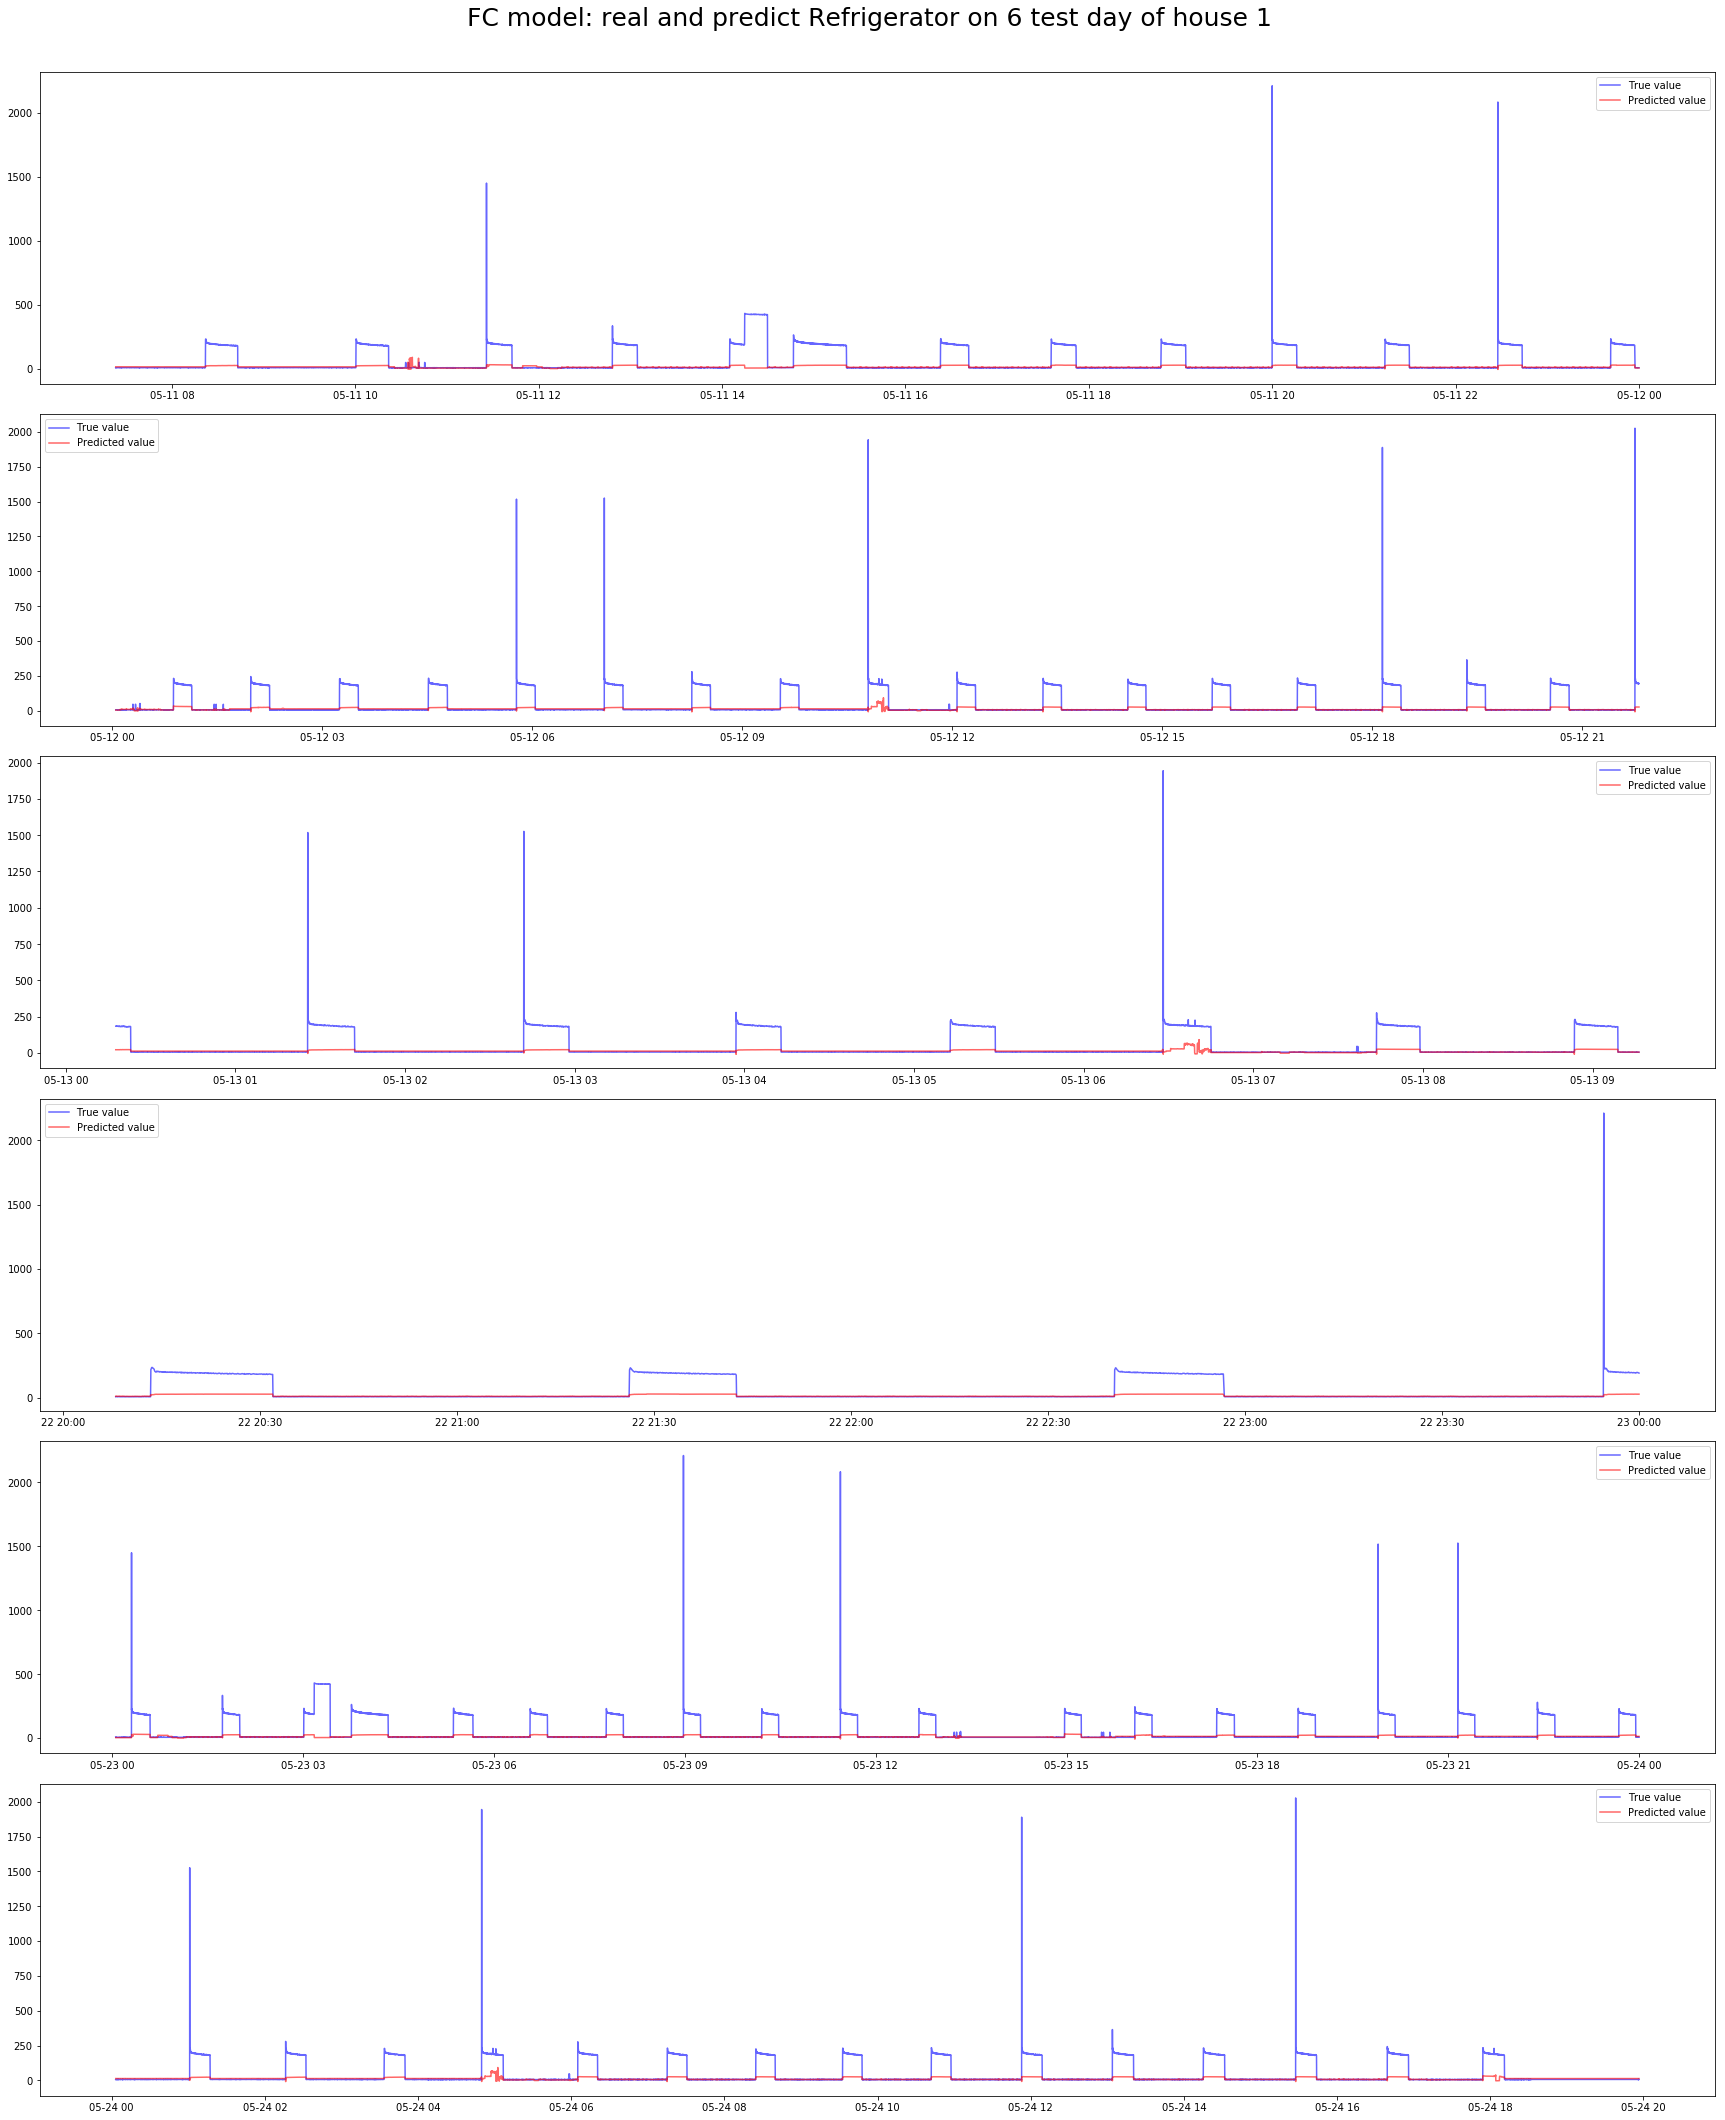

In [37]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Use this model on house 2

In [38]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

Mean square error on test set:  13083.282513864106
Mean absolute error on the test set:  74.95729135690421


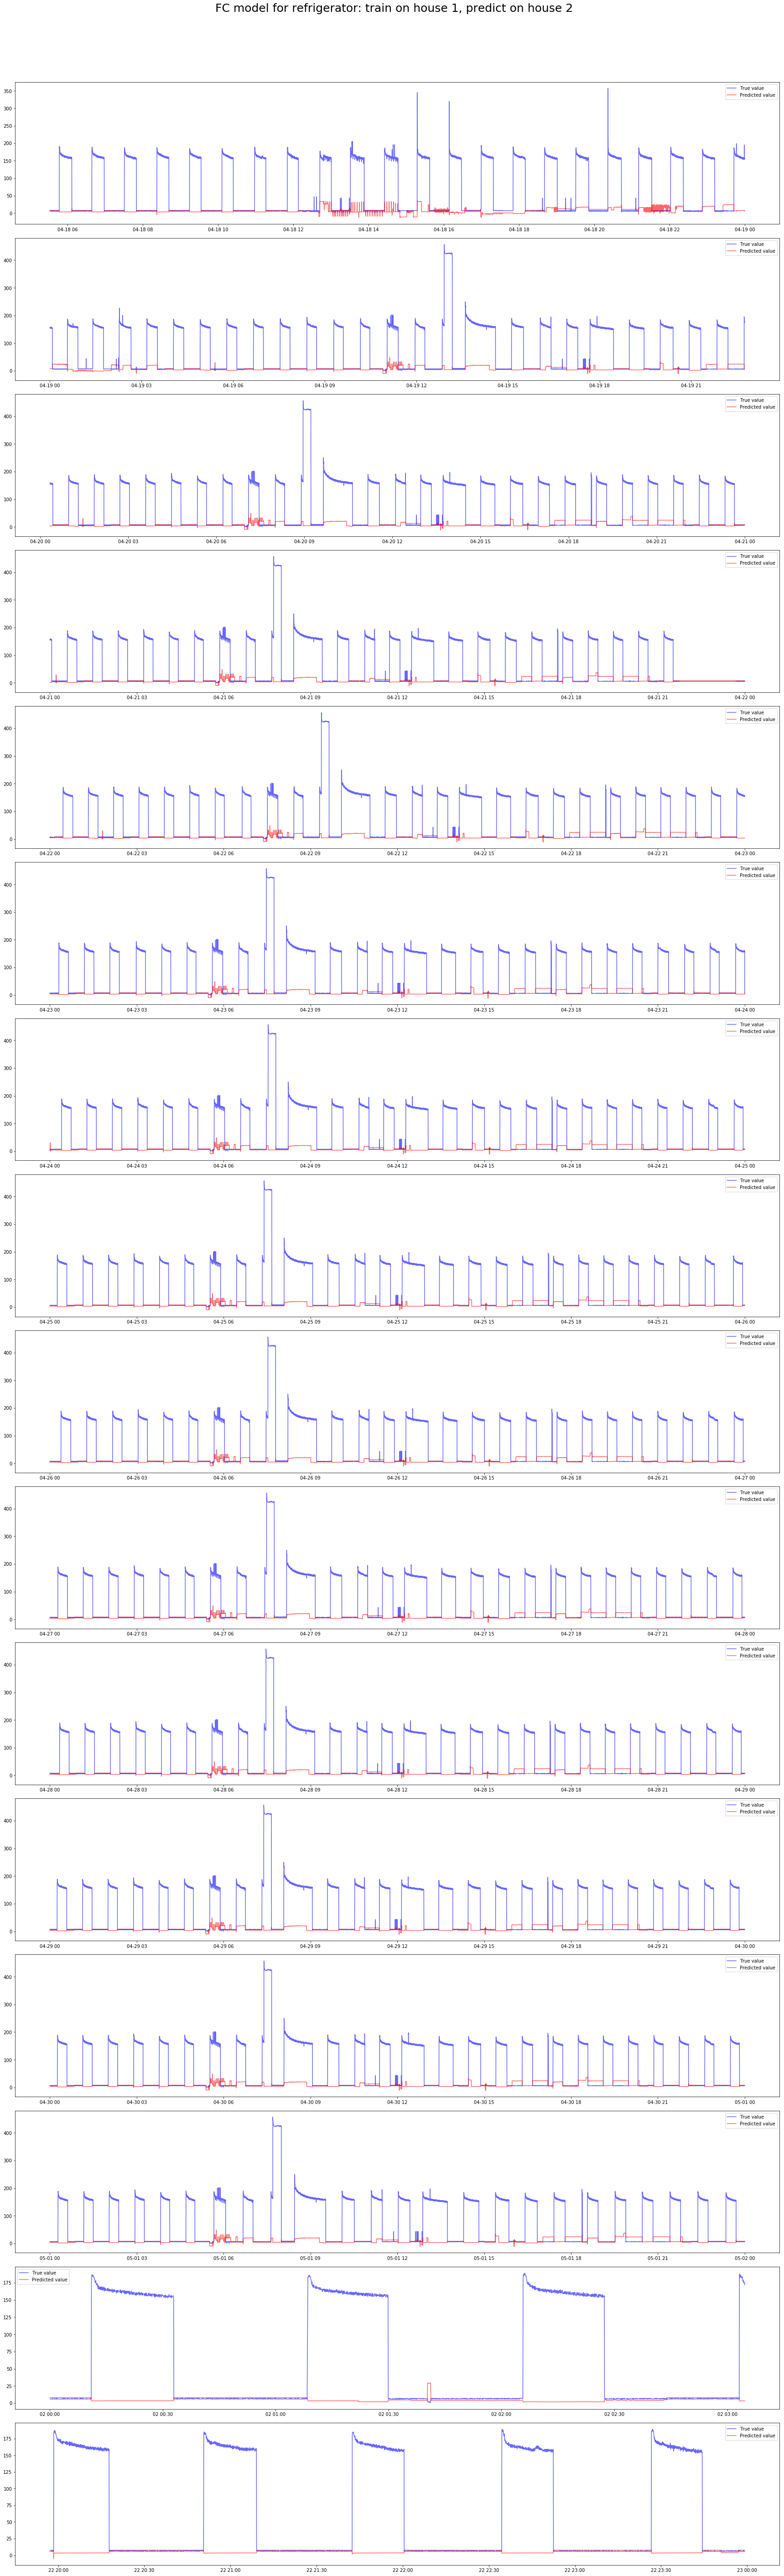

In [39]:
plot_each_app(df[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

### Let's use 50 consecutive total consumtions to predict energy consumption of each appliance

In [40]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.ix[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [41]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:17], ['mains_1','mains_2'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][17:], ['mains_1','mains_2'], df[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  441.93997287750244
(318841, 50, 2) (318841, 18) (86757, 50, 2) (86757, 18)


#### Let's use fully connected neural network again, but this time we use the past 50 consecutive main values to predict the present value of refrigerator


In [42]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
__________

In [43]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

(318841, 100) (318841,)


In [44]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, nb_epoch= 20,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Train on 213623 samples, validate on 105218 samples
Epoch 1/20
213623/213623 [==============================] - 4s 18us/step - loss: 130344.8516 - val_loss: 14933.2367
Epoch 2/20
213623/213623 [==============================] - 3s 14us/step - loss: 94003.5137 - val_loss: 13749.0185
Epoch 3/20
213623/213623 [==============================] - 3s 14us/step - loss: 72602.0780 - val_loss: 10408.5905
Epoch 4/20
213623/213623 [==============================] - 3s 14us/step - loss: 60879.9678 - val_loss: 9685.4816
Epoch 5/20
213623/213623 [==============================] - 3s 14us/step - loss: 49416.6631 - val_loss: 10496.6649
Epoch 6/20
213623/213623 [==============================] - 3s 14us/step - loss: 41248.4676 - val_loss: 9307.1154
Epoch 7/20
213623/213623 [==============================] - 3s 14us/step - loss: 37373.5516 - val_loss: 9051.2841
Epoch 8/20
213623/213623 [==============================] - 3s 14us/step - loss: 30294.8731 - val_loss: 8973.8617
Epoch 9/20
213623/213623 [=====

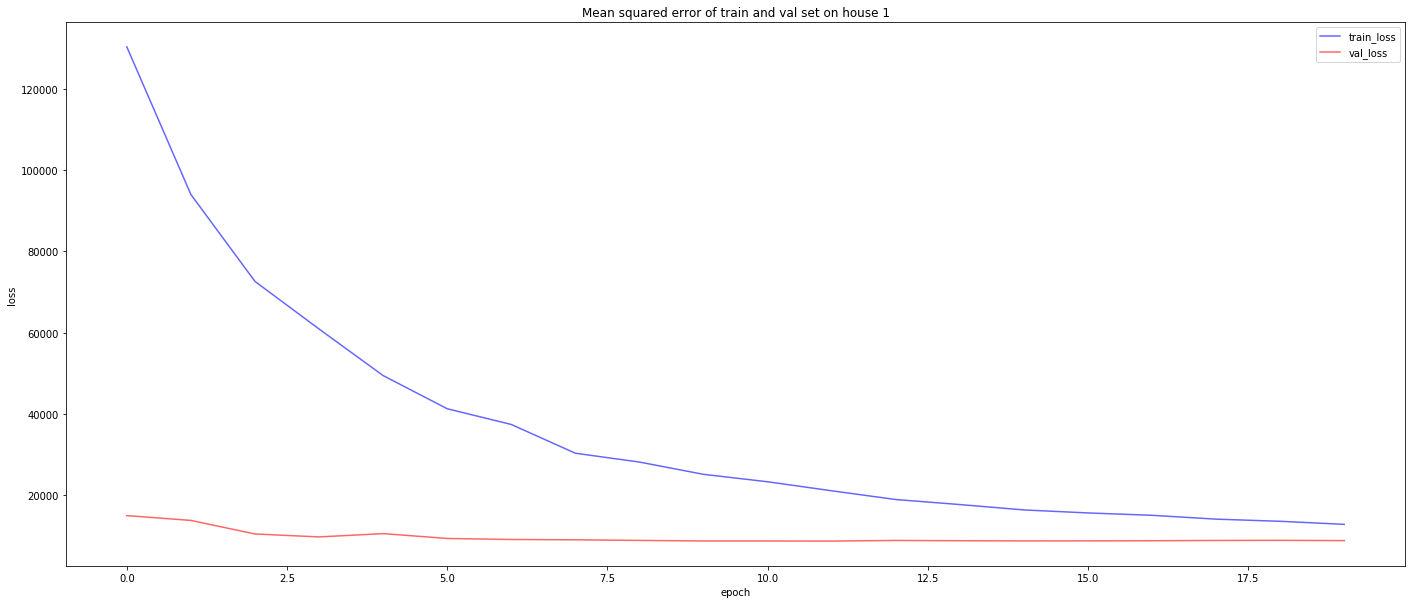

In [45]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [46]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(86757,)


In [47]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

Mean square error on test set:  9730.314122546853
Mean absolute error on the test set:  51.72173349514818


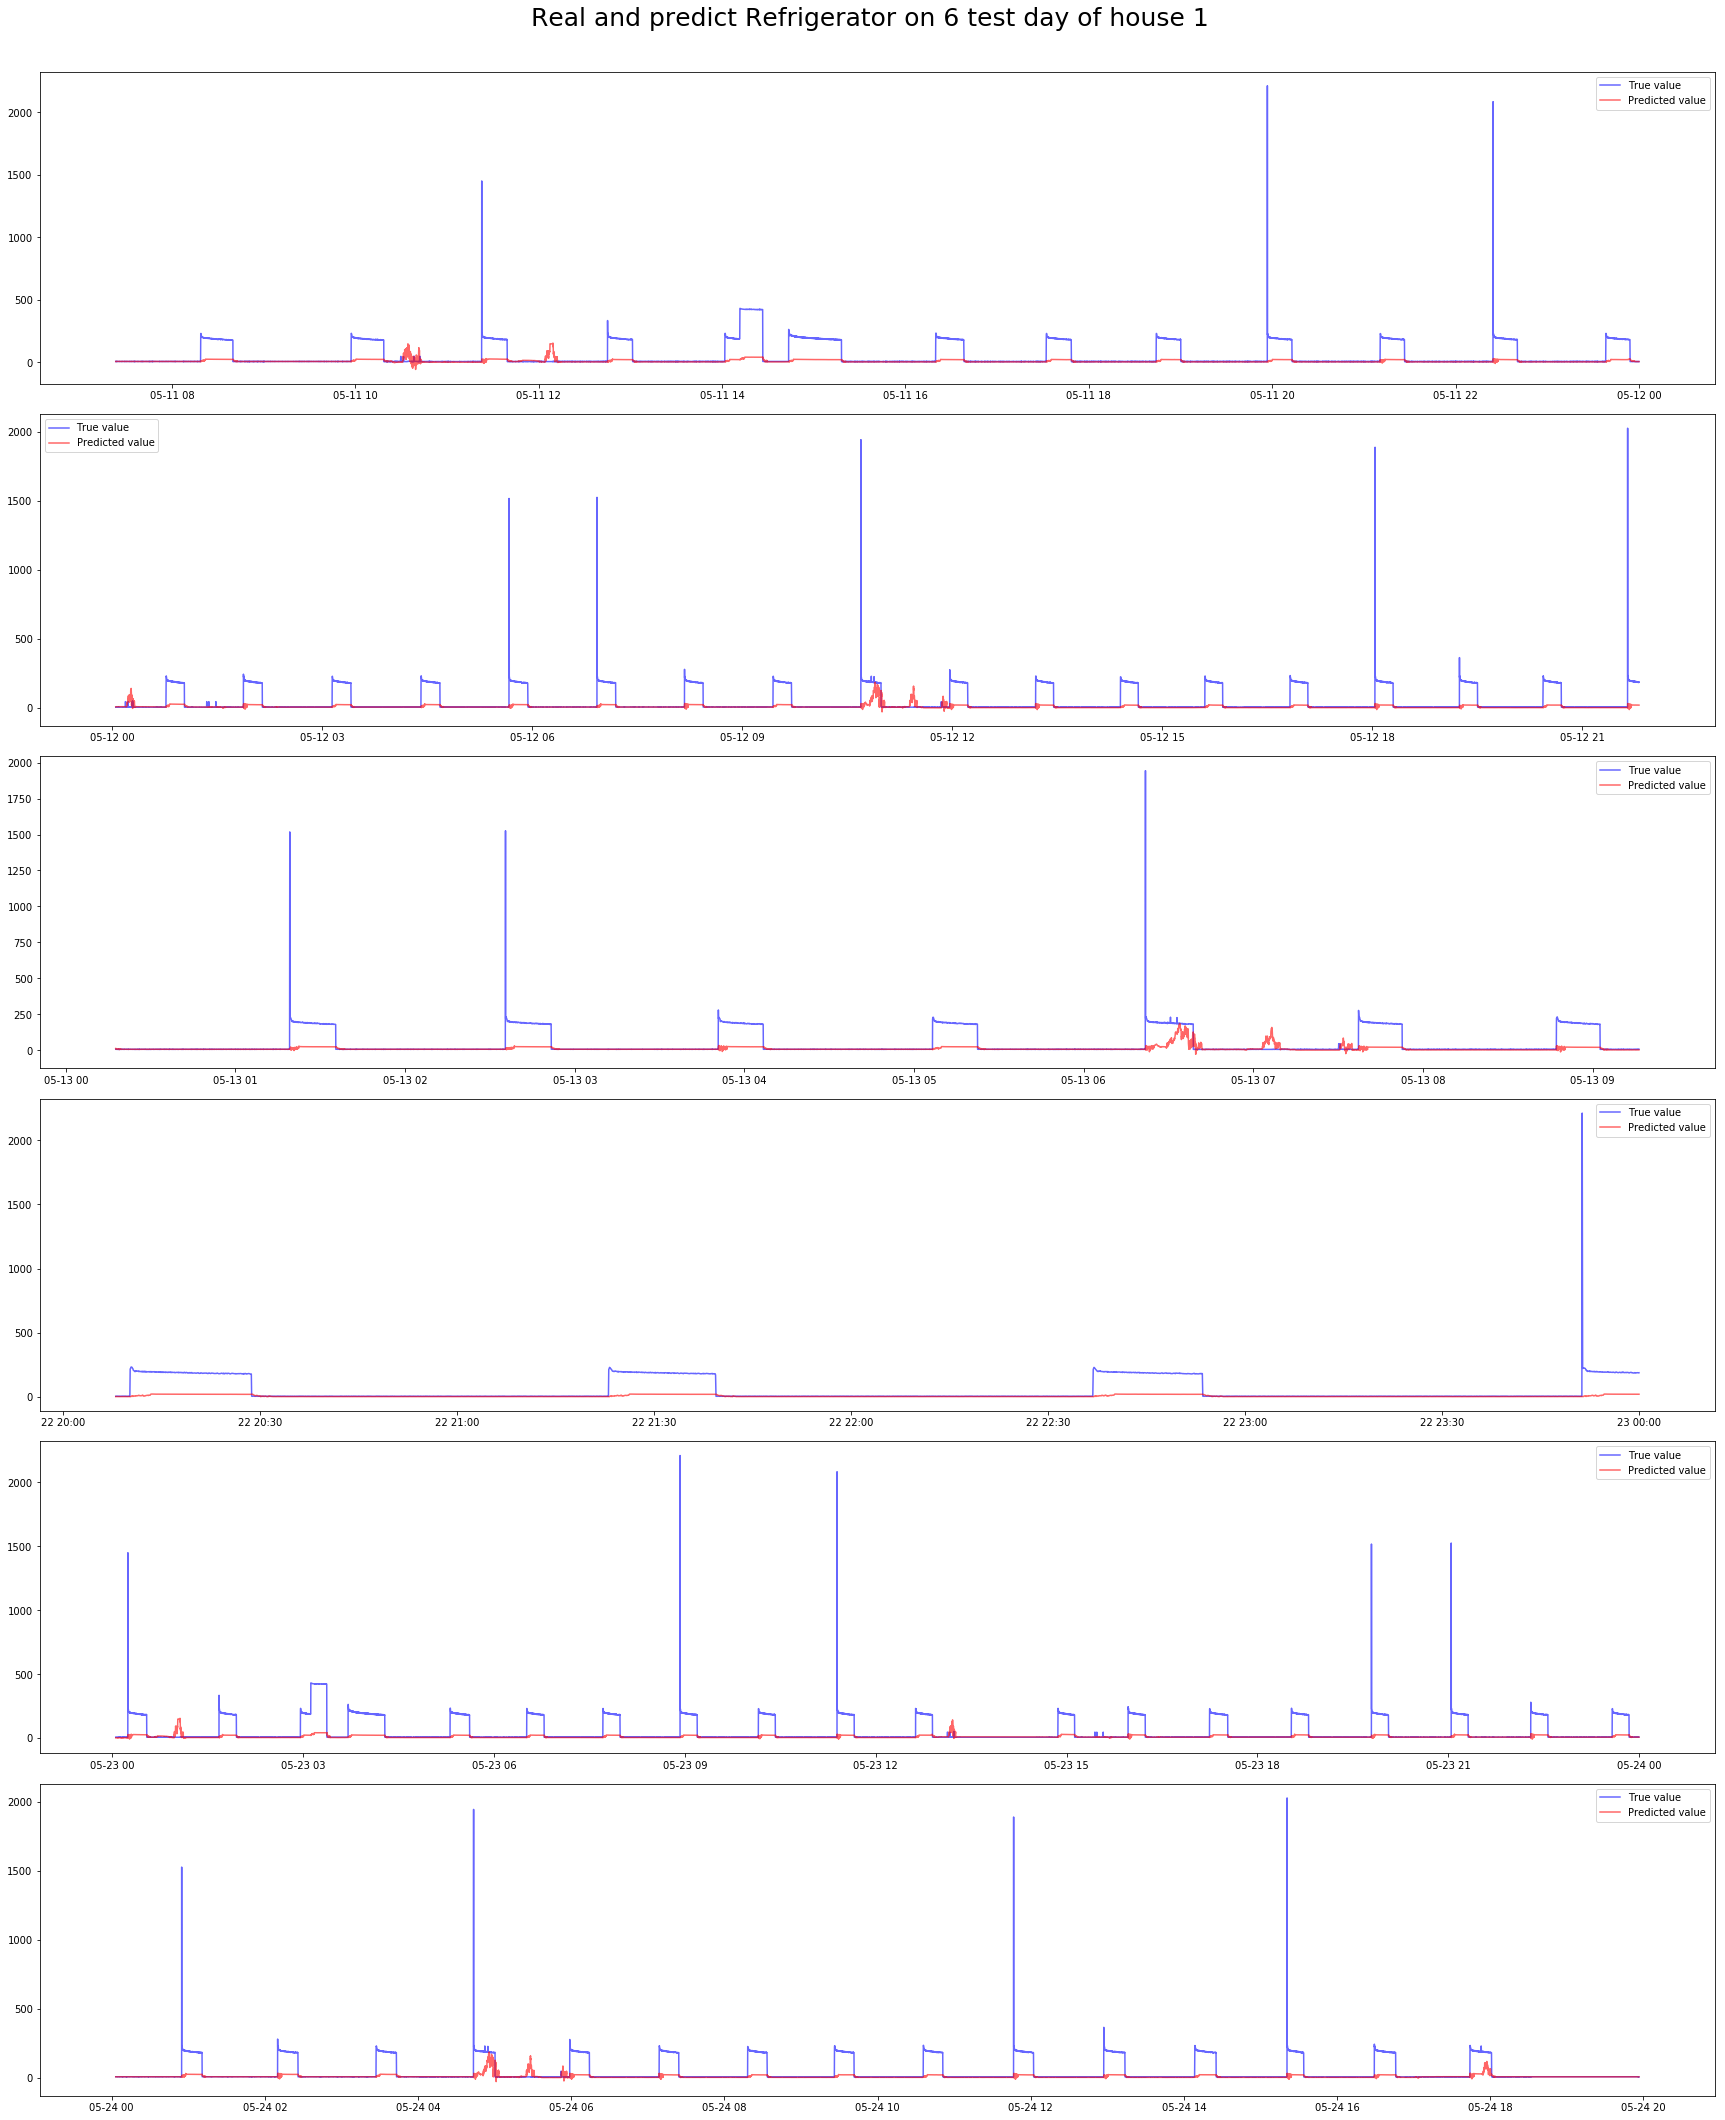

In [48]:
plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test on house 2

In [49]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  332.52189803123474
(316040, 100) (316040,)


In [50]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

Mean square error on test set:  10698.072720805652
Mean absolute error on the test set:  69.71812500228549


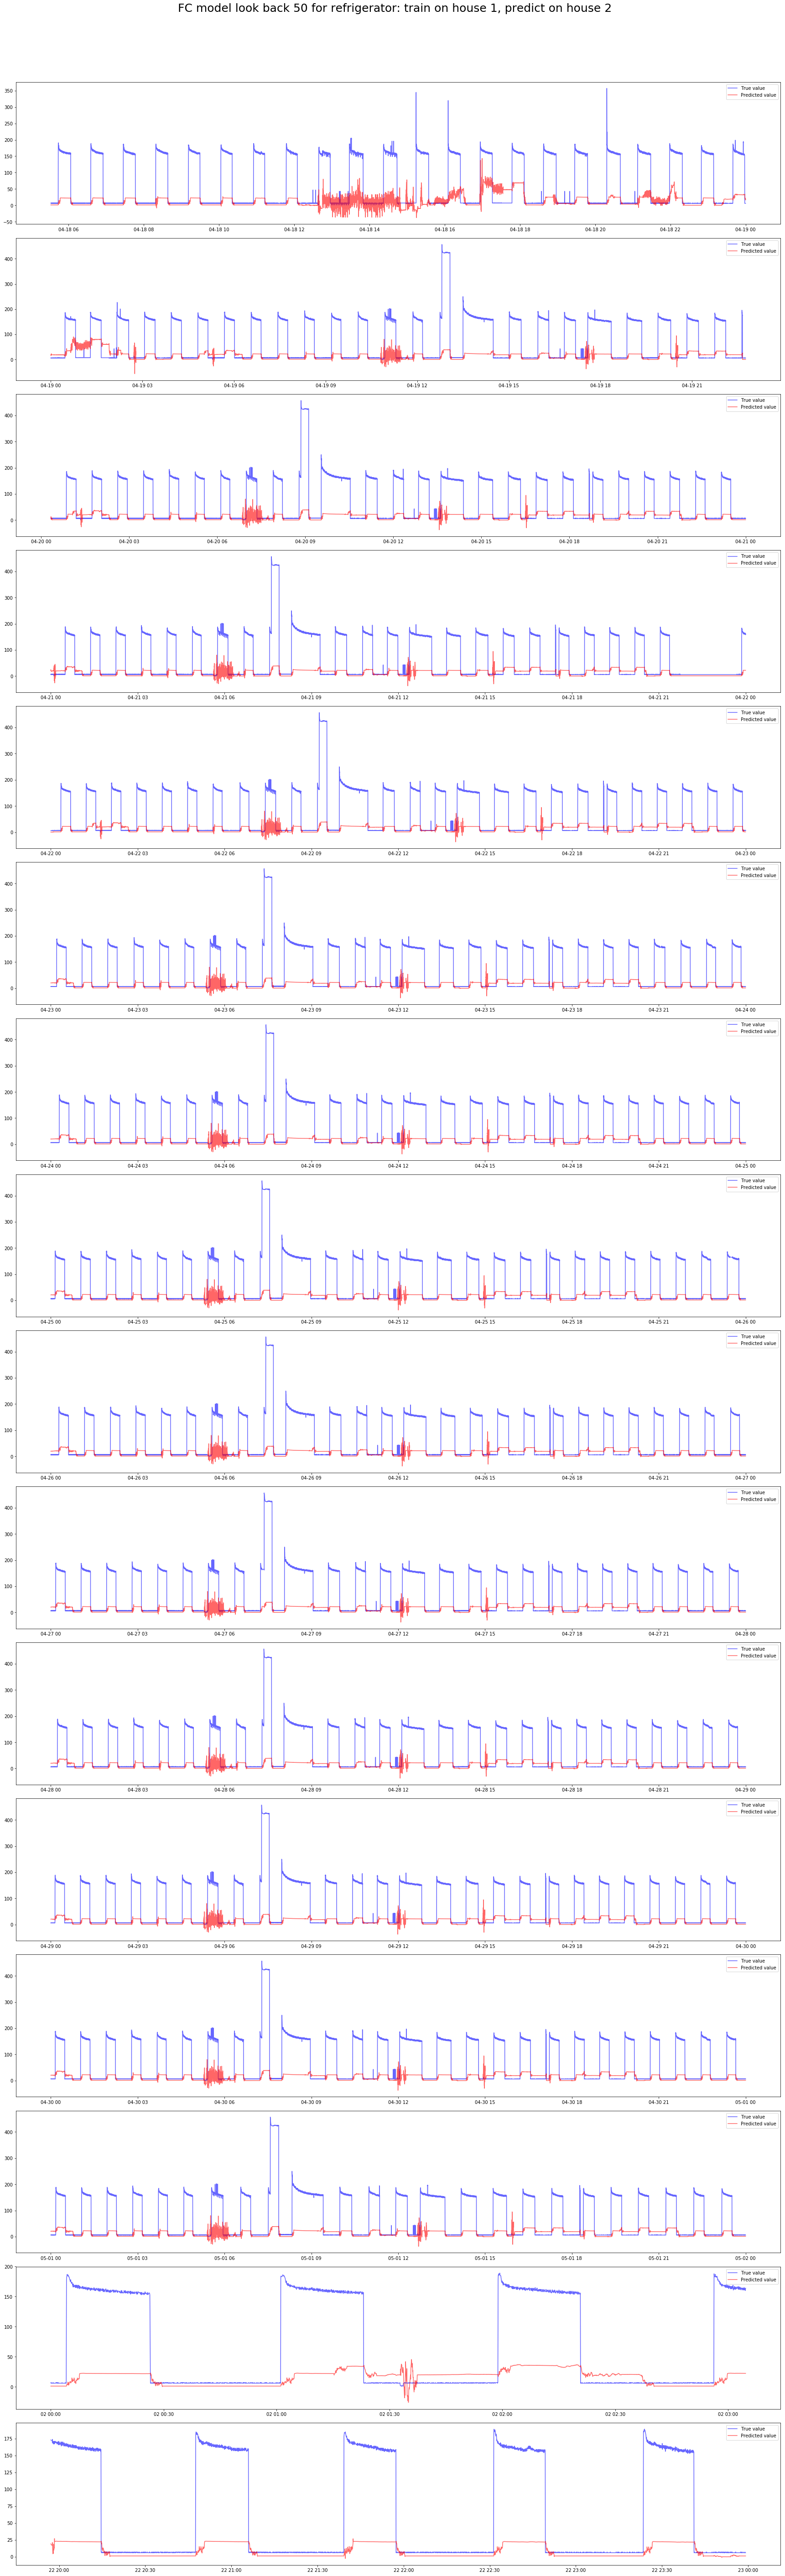

In [51]:
plot_each_app(df[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

### Long term short term memory neural network
#### Now we will try a type of recurrent neural network called long term short term memory model

In [52]:
def build_lstm_model(layers):
    model = Sequential()
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            output_dim=layers[i+1], 
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 64)          17152     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total para

In [ ]:
start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,2],
            batch_size=512,
            verbose=1,
            nb_epoch=200,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 223188 samples, validate on 95653 samples
Epoch 1/200
223188/223188 [==============================] - 139s 623us/step - loss: 9168.5641 - val_loss: 8762.0743
Epoch 2/200
223188/223188 [==============================] - 136s 610us/step - loss: 8501.1940 - val_loss: 8442.2115
Epoch 3/200
223188/223188 [==============================] - 136s 610us/step - loss: 8181.3950 - val_loss: 8113.6144
Epoch 4/200
223188/223188 [==============================] - 136s 610us/step - loss: 7805.8802 - val_loss: 7855.2530
Epoch 5/200
223188/223188 [==============================] - 136s 610us/step - loss: 7457.2232 - val_loss: 7146.9339
Epoch 6/200
223188/223188 [==============================] - 136s 610us/step - loss: 6760.9544 - val_loss: 6720.2729
Epoch 7/200
223188/223188 [==============================] - 136s 610us/step - loss: 6313.8114 - val_loss: 6268.0785
Epoch 8/200
223188/223188 [=========

223188/223188 [==============================] - 136s 610us/step - loss: 987.4048 - val_loss: 1836.6495
Epoch 137/200
223188/223188 [==============================] - 136s 610us/step - loss: 982.5518 - val_loss: 1832.3087
Epoch 138/200
223188/223188 [==============================] - 136s 610us/step - loss: 990.5691 - val_loss: 1881.8743
Epoch 139/200
223188/223188 [==============================] - 136s 611us/step - loss: 985.1308 - val_loss: 1665.8874
Epoch 140/200
223188/223188 [==============================] - 136s 610us/step - loss: 1019.4569 - val_loss: 1951.6442
Epoch 141/200
223188/223188 [==============================] - 136s 611us/step - loss: 983.1371 - val_loss: 1569.5332
Epoch 142/200
223188/223188 [==============================] - 136s 612us/step - loss: 978.4078 - val_loss: 1806.7939
Epoch 143/200
223188/223188 [==============================] - 136s 612us/step - loss: 986.6125 - val_loss: 1805.2459
Epoch 144/200
223188/223188 [==============================] - 137s 6

In [ ]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [ ]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)

In [ ]:
mse_loss_lstm = mse_loss(pred_lstm, y_test[:,2])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,2])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test LST model on house 2 

In [ ]:
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)

print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)


In [ ]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2, 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)

In [ ]:
import pickle
pickle.dump(model,open('model.pkl','wb'))